# Backpropagation in Multilayer Neural Networks

### Goals:
- implementing a real gradient descent in `Numpy`

### Dataset:
- Similar as first Lab - Digits: 10 class handwritten digits
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

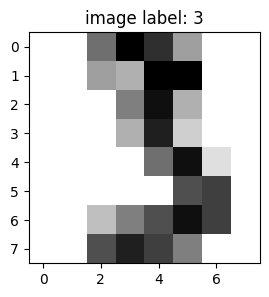

In [5]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

In [7]:
X_train.shape

(1527, 64)

In [8]:
X_train.dtype

dtype('float32')

In [9]:
X_test.shape

(270, 64)

In [10]:
y_train.shape

(1527,)

In [11]:
y_train.dtype

dtype('int32')

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [12]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [13]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [14]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [15]:
def softmax(X):
    # TODO:
    normalised_factor = sum(np.exp(X))
    return (1/normalised_factor) * np.exp(X)

Make sure that this works one vector at a time (and check that the components sum to one):

In [16]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [17]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99983299e-01 4.74258732e-02 9.99999959e-01]
 [1.67014218e-05 9.52574127e-01 4.13993755e-08]]


Here is a way to implement softmax that works both for an individual vector of activations and for a batch of activation vectors at once:

In [18]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Probabilities should sum to 1:

In [19]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [20]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [21]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [22]:
a = np.array([[1, 0, 0], [0, 1,0], [0, 0, 1]])
b = np.array([[0.9, 0.05, 0.05], [0, 1, 0], [0.1, 0, 0.9]])
np.sum(a*b, axis =1)

array([0.9, 1. , 0.9])

In [23]:
a*b

array([[0.9, 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 0.9]])

In [24]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # TODO
    output = -np.sum(Y_true * np.log(Y_pred + 1e-20)) # I've add 1e-20 to avoid nan values from log function
    return output


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [25]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [26]:
def nll(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)

    # TODO
    loss_per_sample = -np.sum(Y_true * np.log(Y_pred + 1e-20))
    output = np.mean(loss_per_sample)
    return output

In [27]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.01005033585350145


In [28]:
# %load solutions/numpy_nll.py

Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [29]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size

    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [30]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 3485.0408, train acc: 0.135, test acc: 0.152


Evaluate the randomly initialized model on the first example:

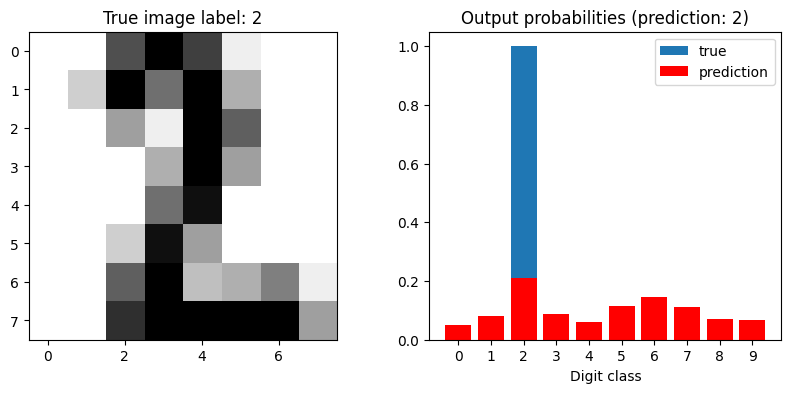

In [31]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx:sample_idx+1]).reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)

In [29]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 3753.0246, train acc: 0.102, test acc: 0.119
Update #100, train loss: 2122.5921, train acc: 0.629, test acc: 0.637
Update #200, train loss: 1347.9927, train acc: 0.839, test acc: 0.844
Update #300, train loss: 986.6114, train acc: 0.898, test acc: 0.911
Update #400, train loss: 810.5090, train acc: 0.905, test acc: 0.907
Update #500, train loss: 698.1115, train acc: 0.921, test acc: 0.919
Update #600, train loss: 616.7204, train acc: 0.927, test acc: 0.926
Update #700, train loss: 557.8338, train acc: 0.935, test acc: 0.941
Update #800, train loss: 526.3719, train acc: 0.935, test acc: 0.941
Update #900, train loss: 487.8793, train acc: 0.938, test acc: 0.948
Update #1000, train loss: 460.7673, train acc: 0.944, test acc: 0.952
Update #1100, train loss: 432.2777, train acc: 0.944, test acc: 0.956
Update #1200, train loss: 414.1115, train acc: 0.948, test acc: 0.970
Update #1300, train loss: 405.9156, train acc: 0.950, test acc: 0.944
Update #1400, train loss: 378

Evaluate the trained model on the first example:

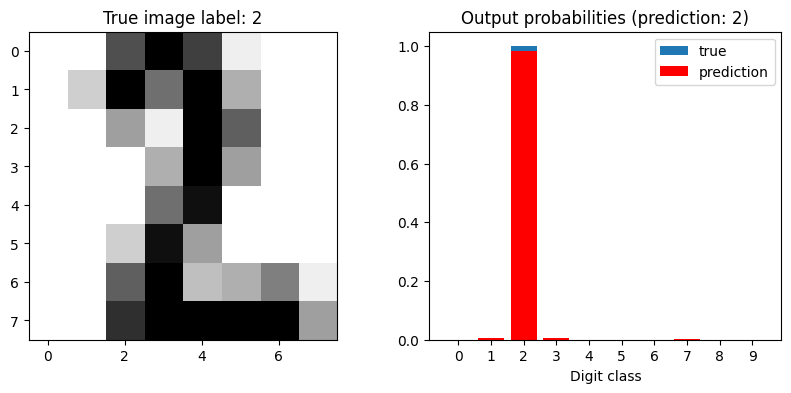

In [30]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

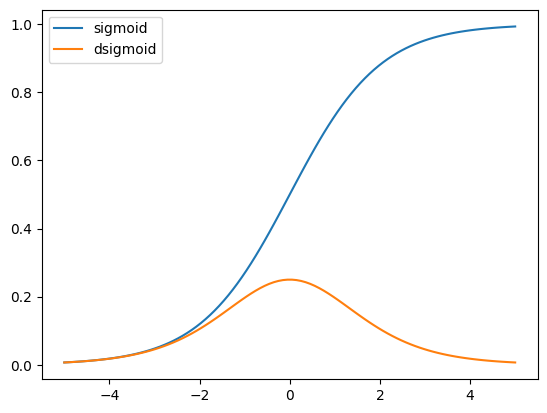

In [32]:
def sigmoid(X):
    # TODO
    output = 1/(1 + np.exp(-X))
    return output


def dsigmoid(X):
    # TODO
    output = sigmoid(X) * (1 - sigmoid(X))
    return output


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes:
  - try to keep the code as similar as possible as the previous one;
  - `forward` now has a keep activations parameter to also return hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

**Bonus**: reimplementing all from scratch only using the lecture slides but without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [54]:

class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = np.random.randn(input_size, hidden_size)
        self.b_h = np.random.randn(hidden_size)
        self.W_o = np.random.randn(hidden_size, output_size)
        self.b_o = np.random.randn(output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        # TODO
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h

    def forward(self, X):
        y, h, z_h = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        # TODO
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, x, y_true):
        # TODO
        y_pred, h, z_h = self.forward_keep_activations(x)
        output1 =  y_pred - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, output1)
        grad_b_o = output1
        output2 = np.dot(output1, self.W_o.T) * dsigmoid(z_h)
        grad_W_h = np.outer(x, output2)
        grad_b_h = output2

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # TODO
        grads = self.grad_loss(x, y)
        self.W_h -= learning_rate * grads['W_h']
        self.W_o -= learning_rate * grads['W_o']
        self.b_h -= learning_rate * grads['b_h']
        self.b_o -= learning_rate * grads['b_o']


    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [57]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [58]:
model.loss(X_train, y_train)

6601.27378029225

In [59]:
model.accuracy(X_train, y_train)

0.056319580877537655

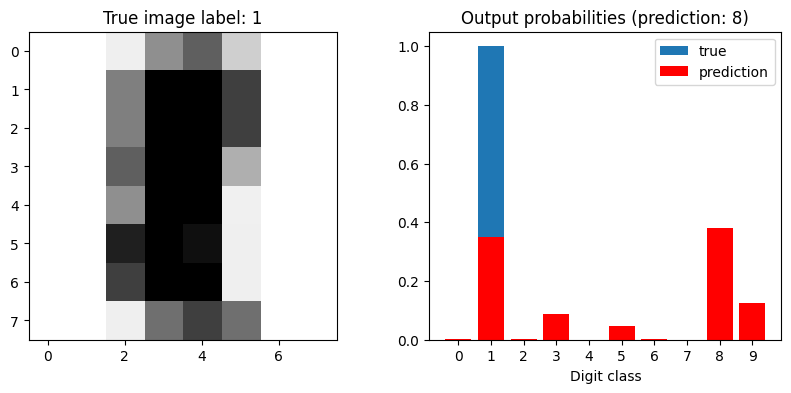

In [36]:
plot_prediction(model, sample_idx=5)

In [60]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 6601.27378, train acc: 0.056, test acc: 0.030
Epoch #1, train loss: 681.27251, train acc: 0.872, test acc: 0.889
Epoch #2, train loss: 374.56518, train acc: 0.937, test acc: 0.922
Epoch #3, train loss: 259.53758, train acc: 0.954, test acc: 0.919
Epoch #4, train loss: 200.92398, train acc: 0.968, test acc: 0.922
Epoch #5, train loss: 163.25495, train acc: 0.974, test acc: 0.933
Epoch #6, train loss: 135.15003, train acc: 0.978, test acc: 0.933
Epoch #7, train loss: 110.68700, train acc: 0.984, test acc: 0.944
Epoch #8, train loss: 94.85076, train acc: 0.988, test acc: 0.944
Epoch #9, train loss: 84.57852, train acc: 0.990, test acc: 0.944
Epoch #10, train loss: 75.28413, train acc: 0.991, test acc: 0.941
Epoch #11, train loss: 66.24905, train acc: 0.993, test acc: 0.944
Epoch #12, train loss: 59.02563, train acc: 0.994, test acc: 0.941
Epoch #13, train loss: 52.97983, train acc: 0.993, test acc: 0.933
Epoch #14, train loss: 48.15250, train acc: 0.995, test acc:

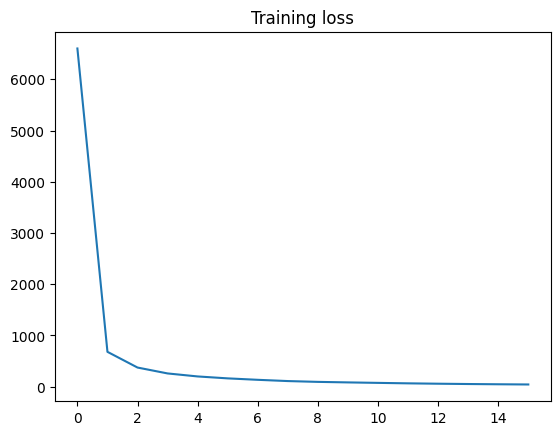

In [61]:
plt.plot(losses)
plt.title("Training loss");

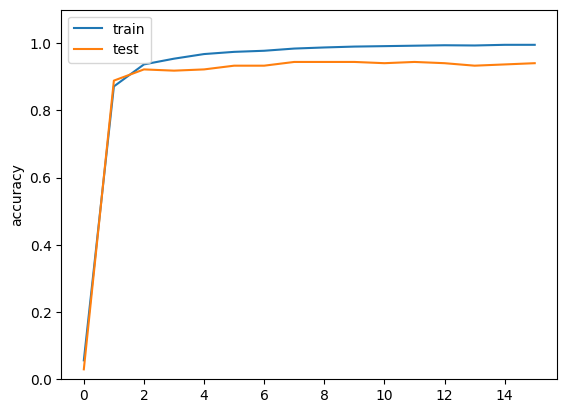

In [62]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

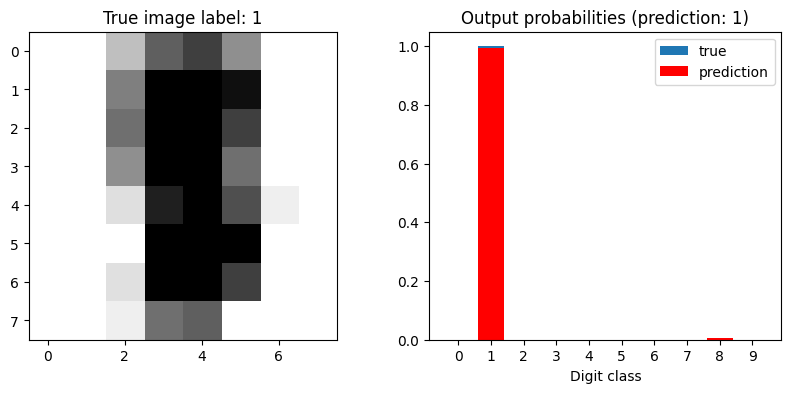

In [63]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

**Solution**

Finding the samples having the worst predictions.


In [41]:
predictions = model.predict(X_test)
worst_predictions_indices = np.where(predictions != y_test)
X_test[worst_predictions_indices]

array([[ 0.        , -0.32798812,  1.2258583 , ...,  1.5504359 ,
         3.4381592 ,  3.1771472 ],
       [ 0.        , -0.32798812, -1.0960567 , ..., -1.1518219 ,
        -0.5122314 , -0.19234262],
       [ 0.        , -0.32798812,  0.3815256 , ..., -1.1518219 ,
        -0.5122314 , -0.19234262],
       ...,
       [ 0.        , -0.32798812,  0.8036919 , ..., -0.6451486 ,
        -0.5122314 , -0.19234262],
       [ 0.        , -0.32798812, -1.0960567 , ...,  1.3815448 ,
         1.2160646 , -0.19234262],
       [ 0.        , -0.32798812, -0.46280715, ...,  0.3681981 ,
        -0.5122314 , -0.19234262]], dtype=float32)

Looking at the model predictions for the worst predictions found.



<ipython-input-28-61307295a4a7>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


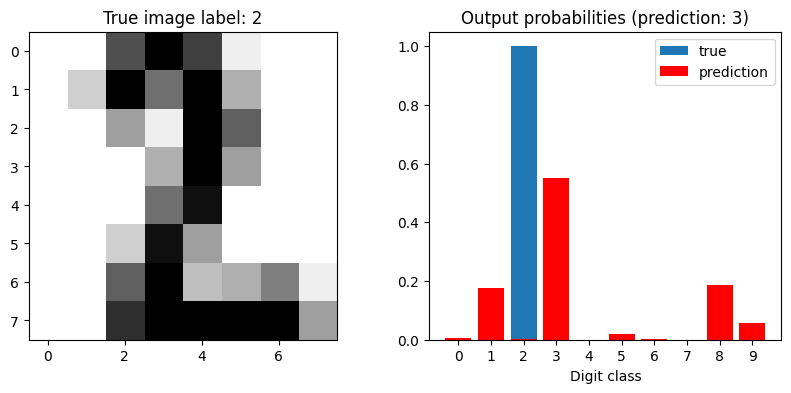

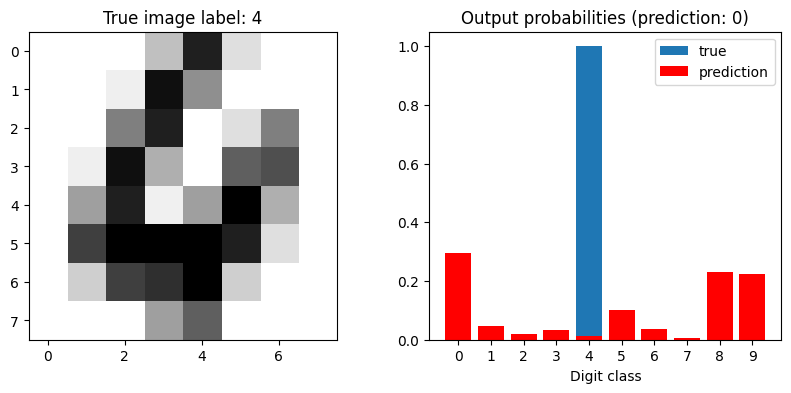

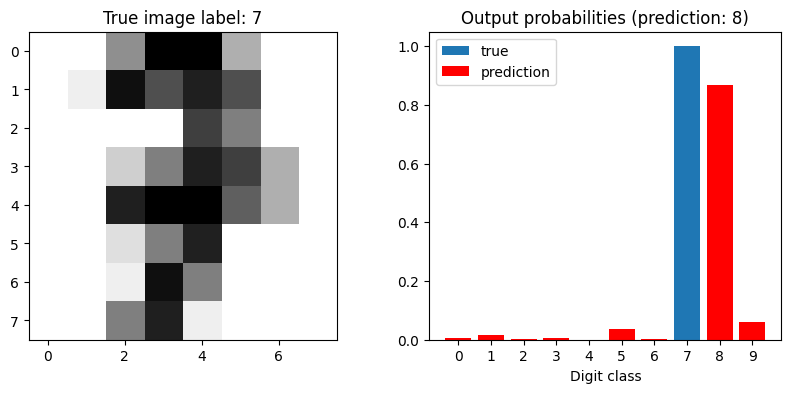

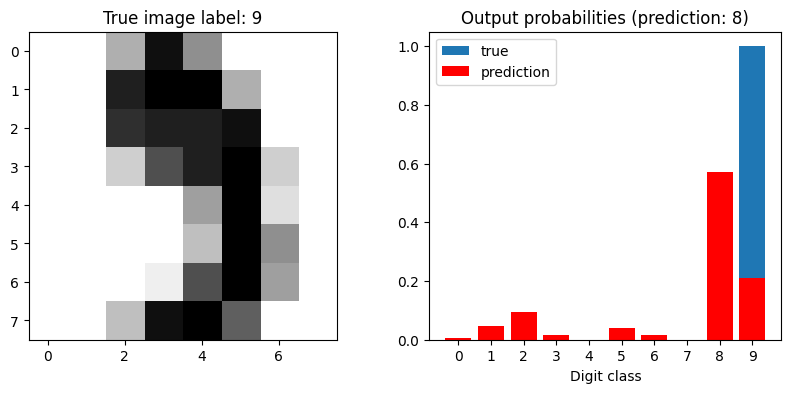

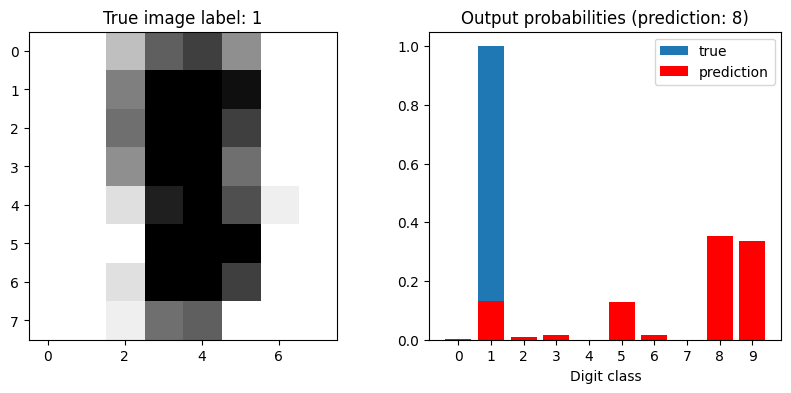

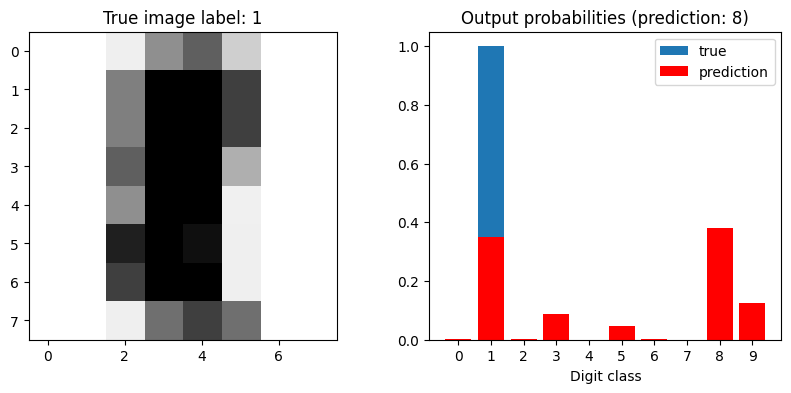

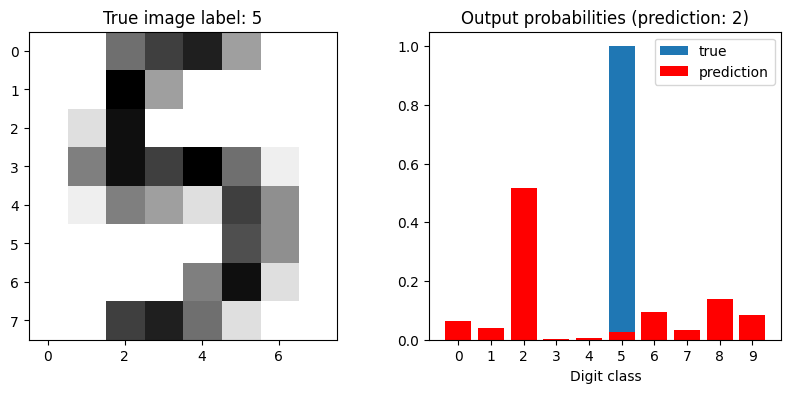

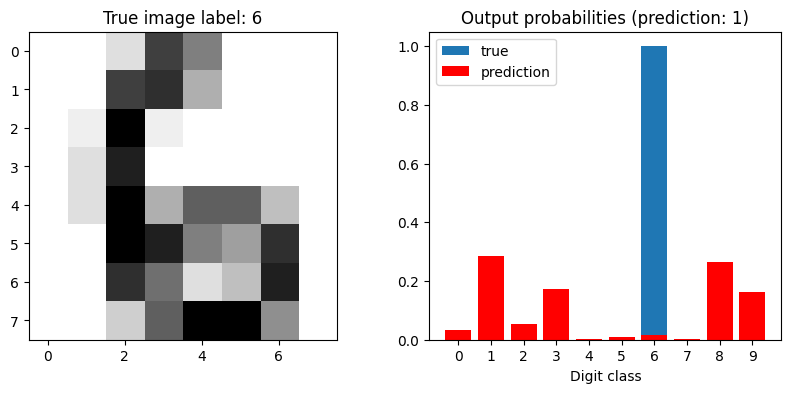

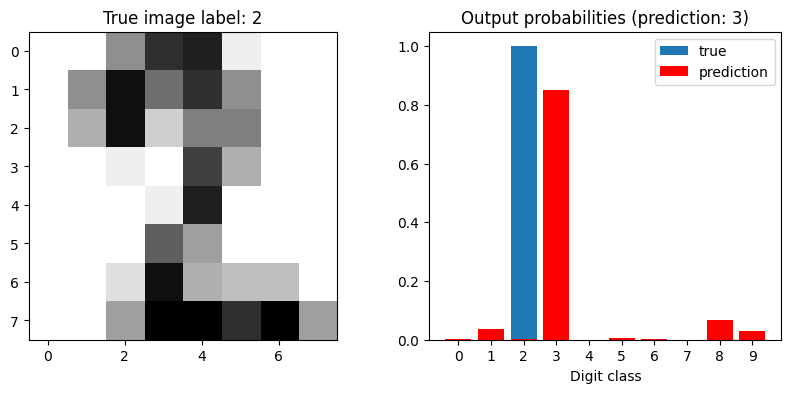

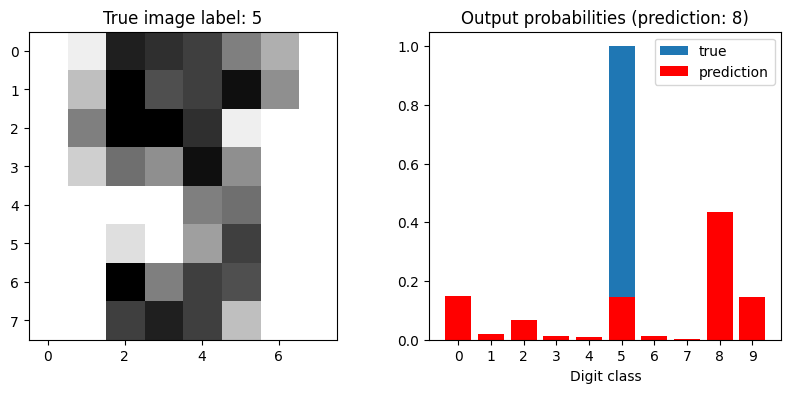

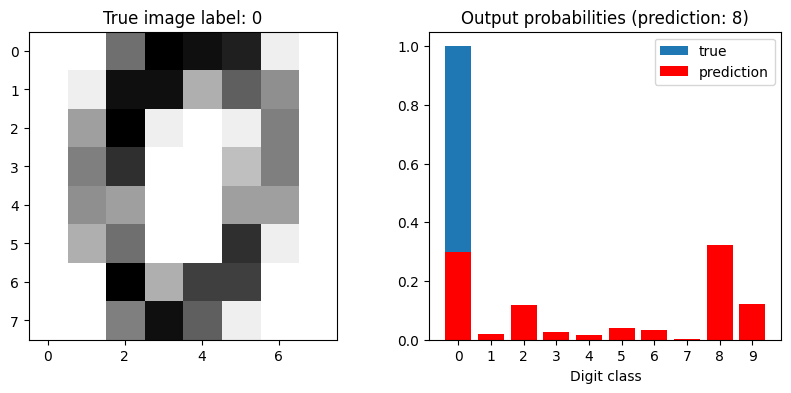

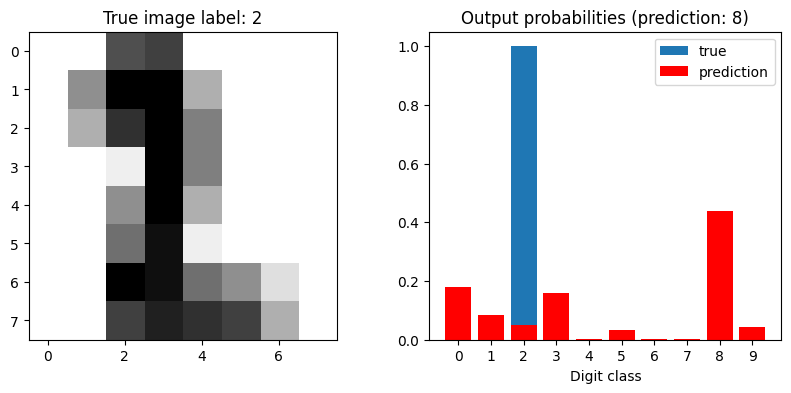

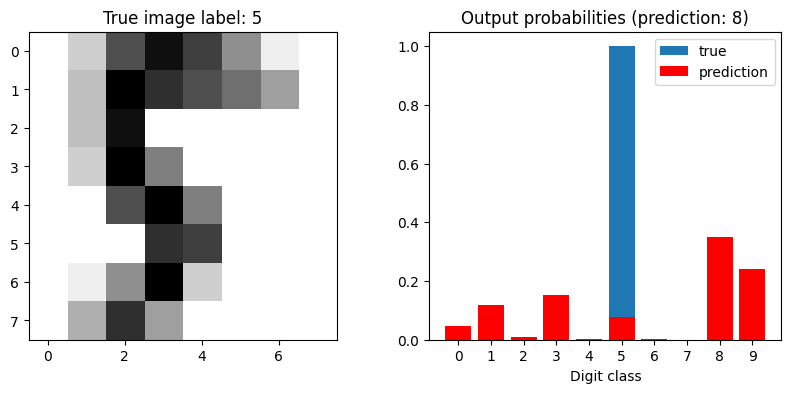

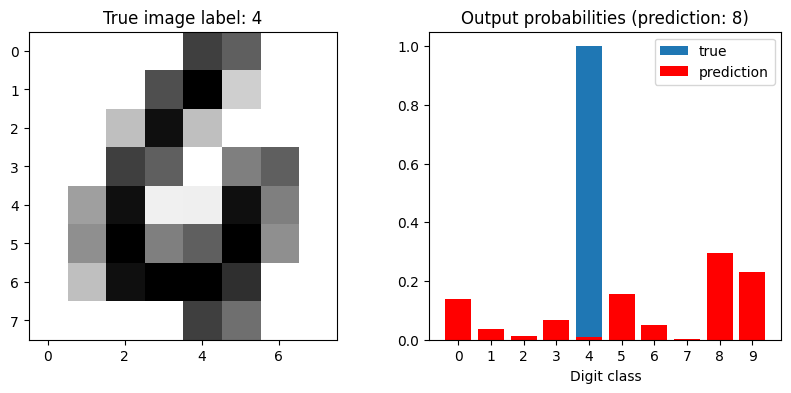

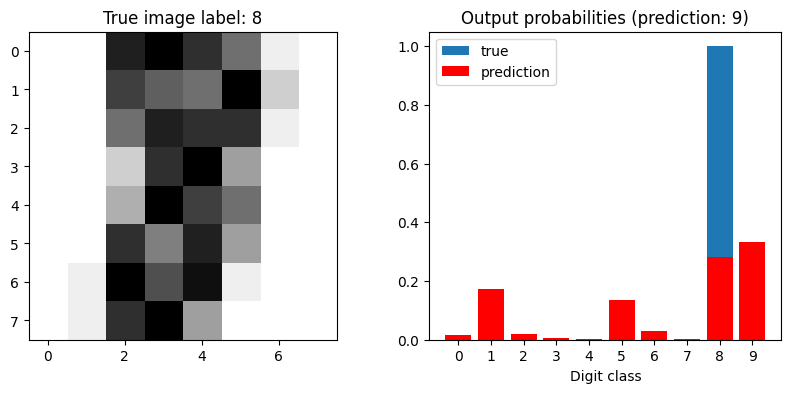

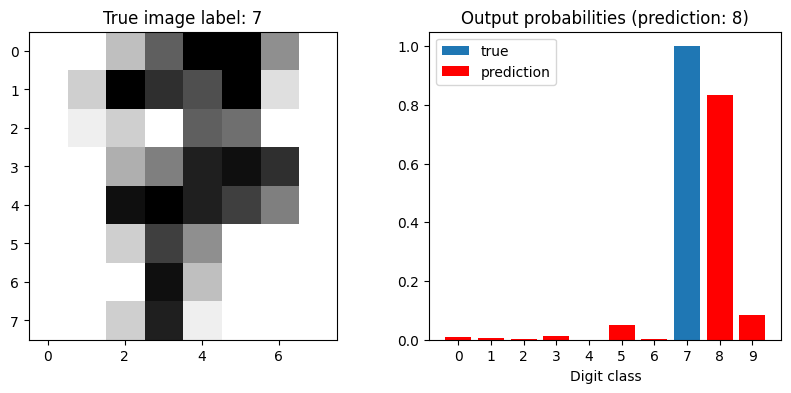

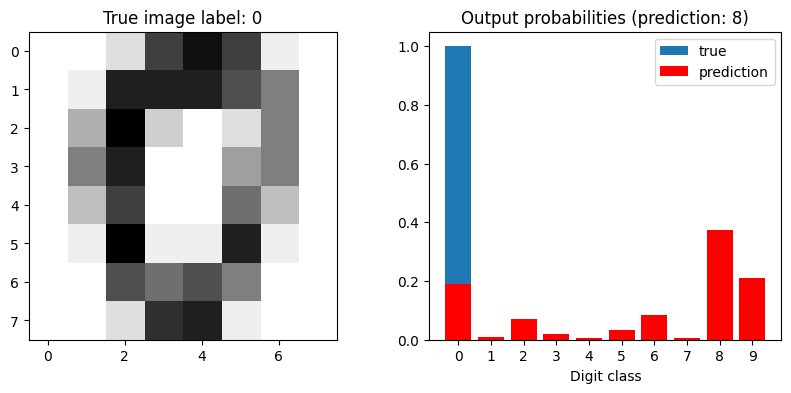

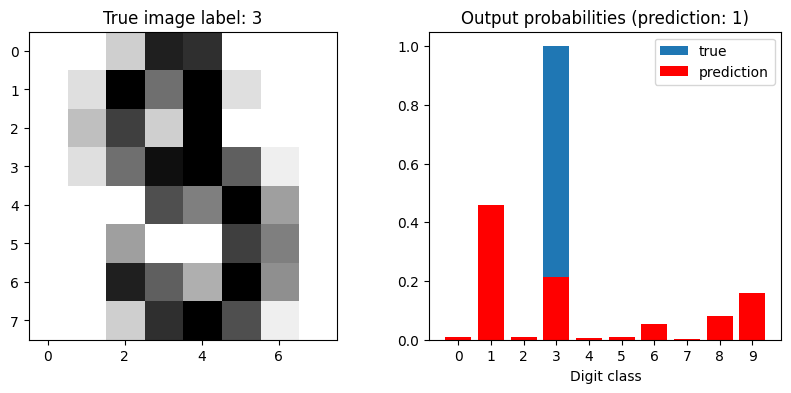

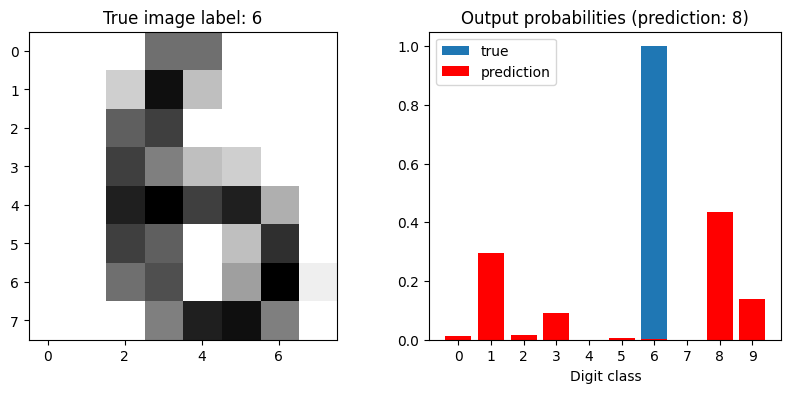

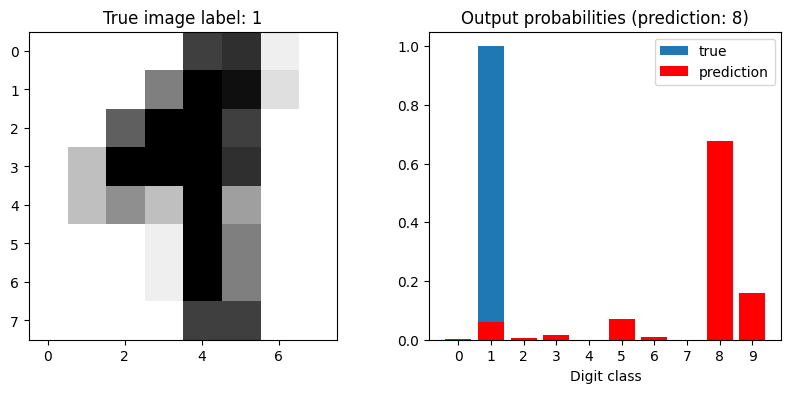

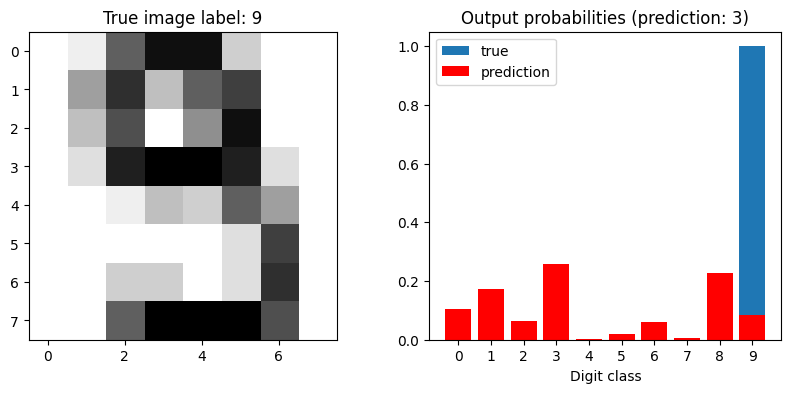

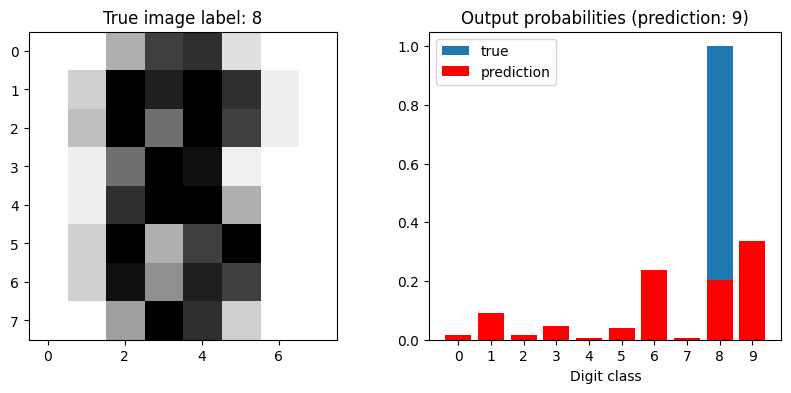

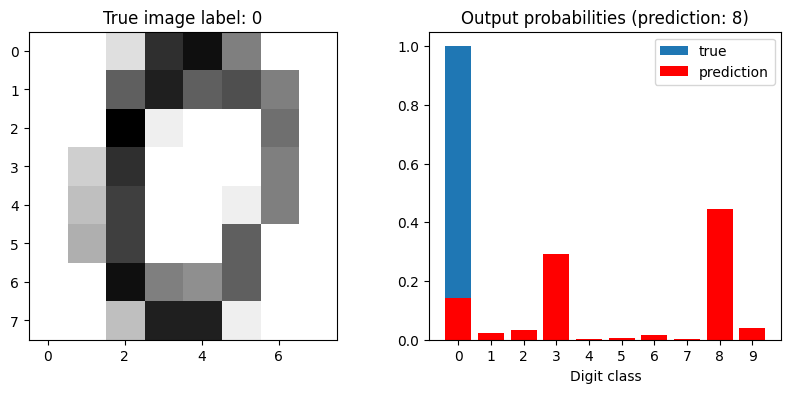

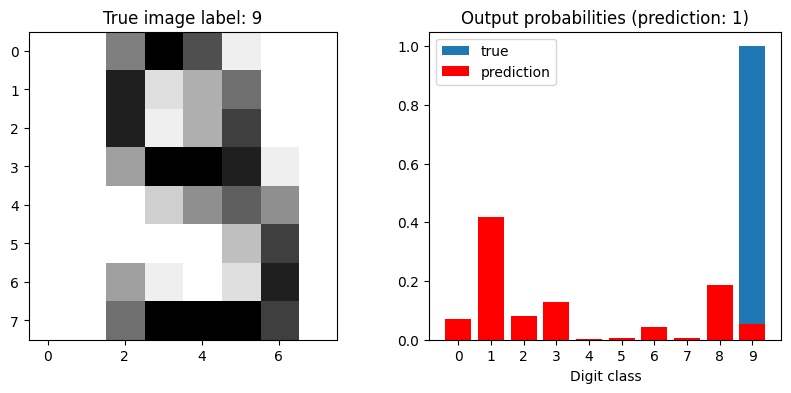

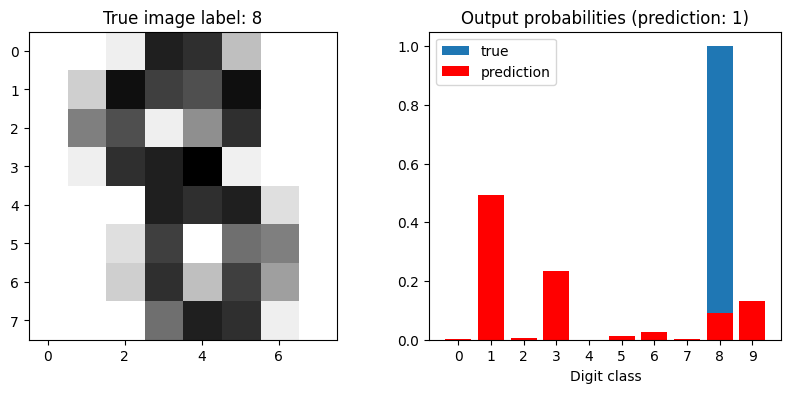

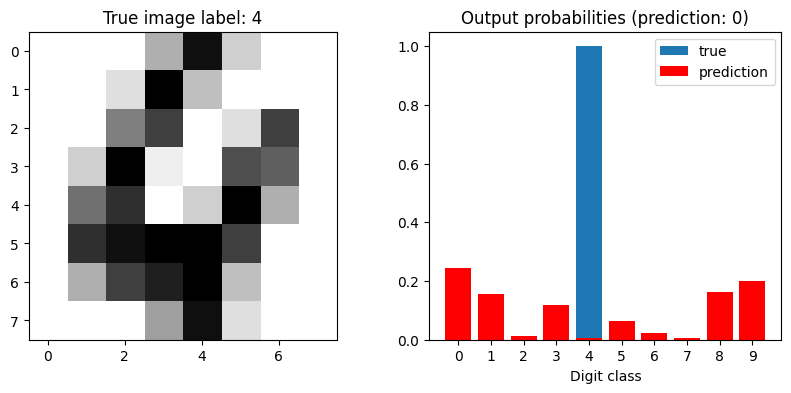

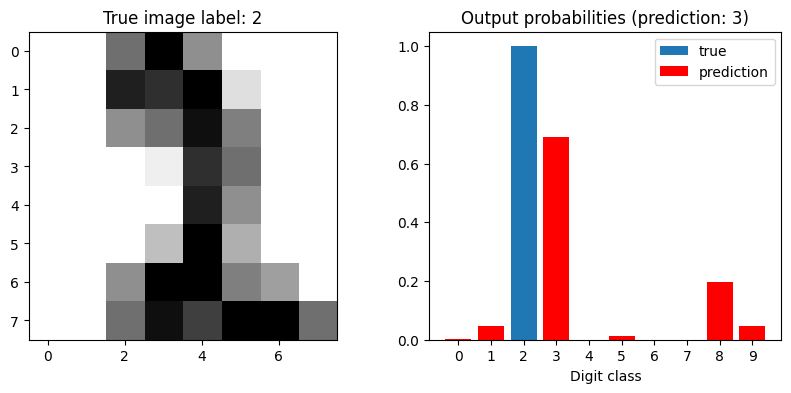

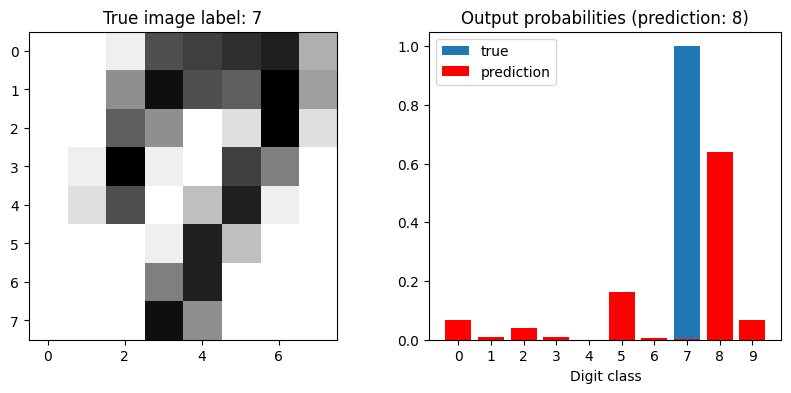

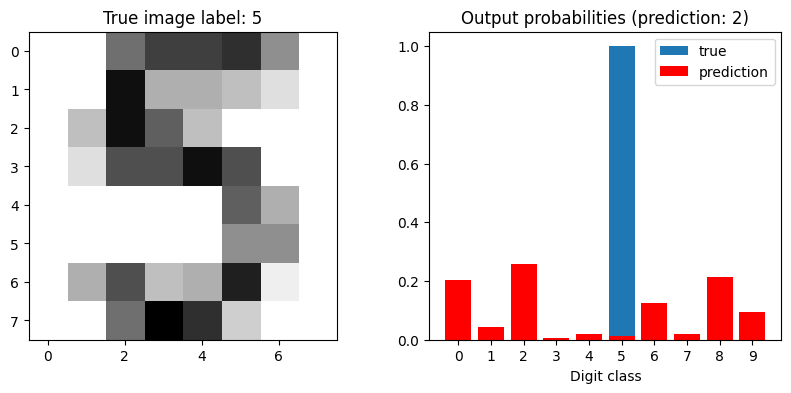

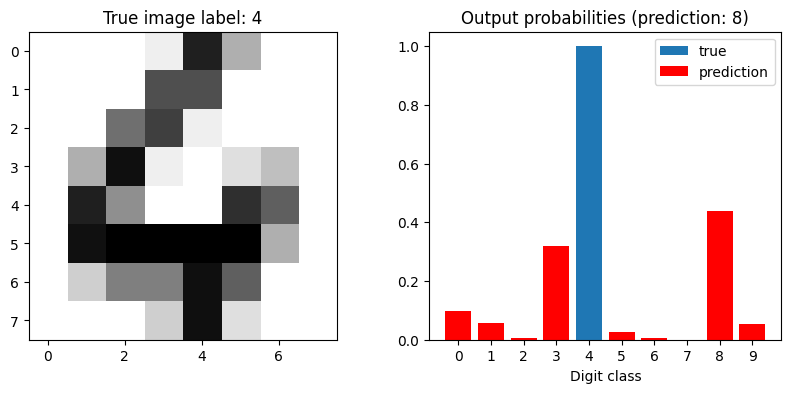

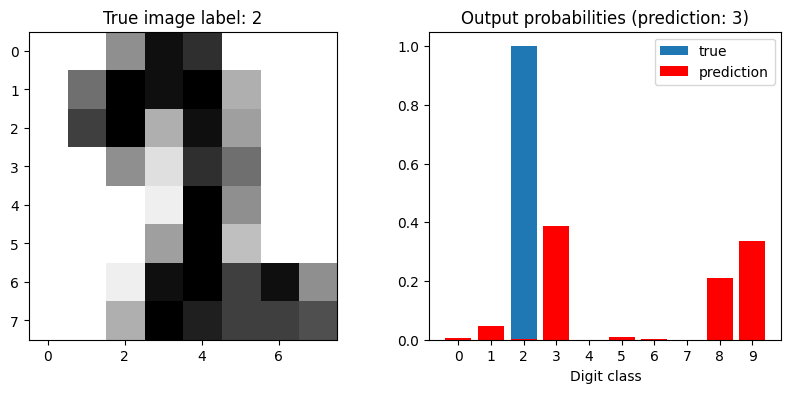

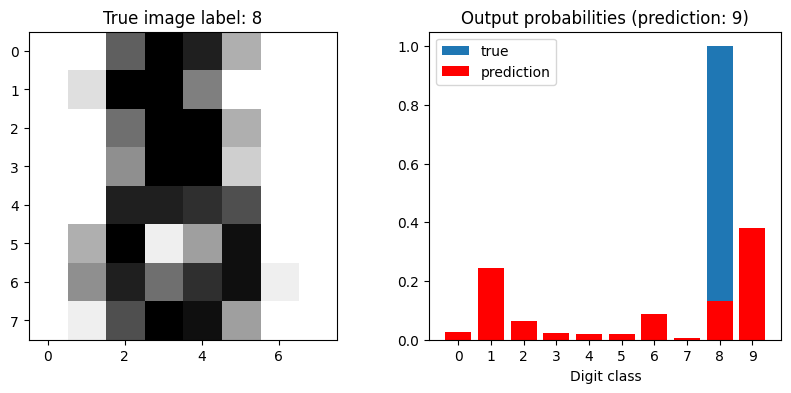

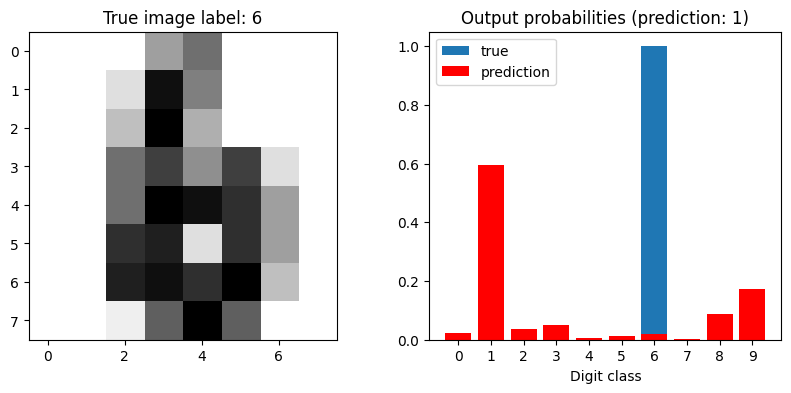

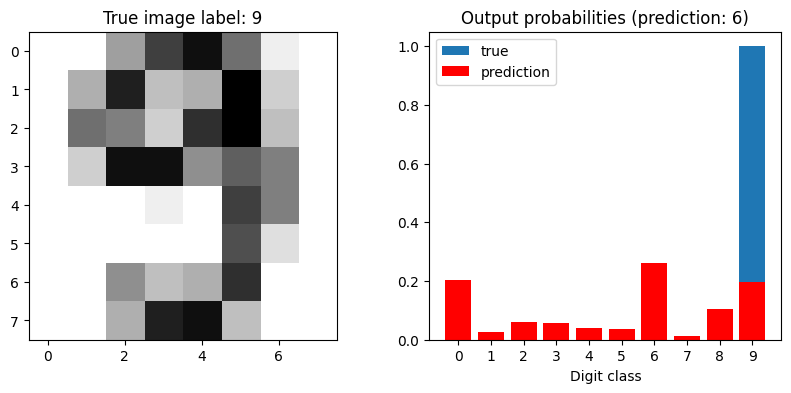

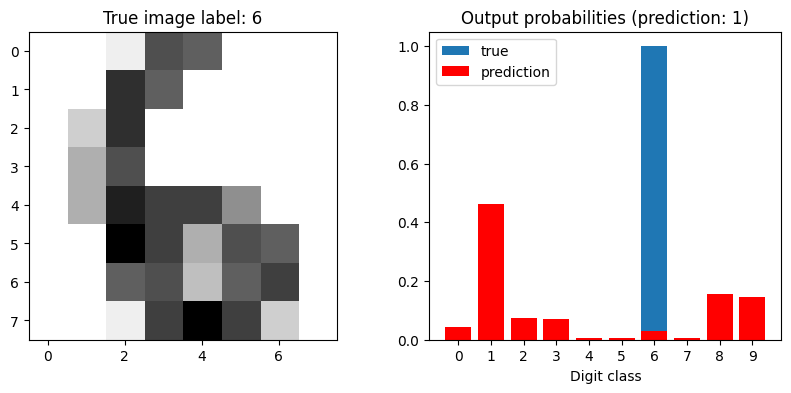

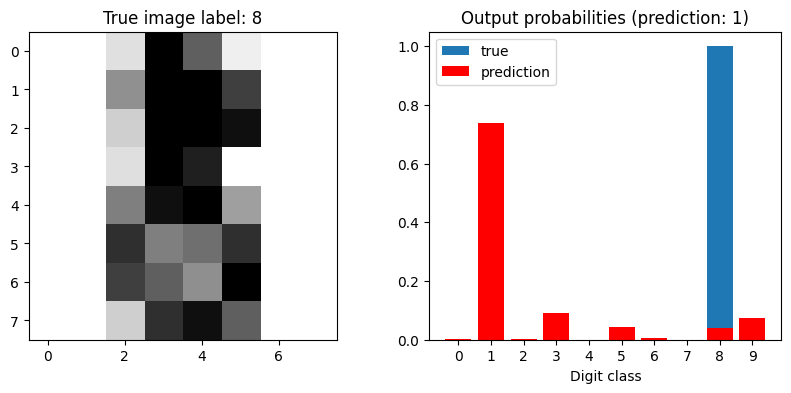

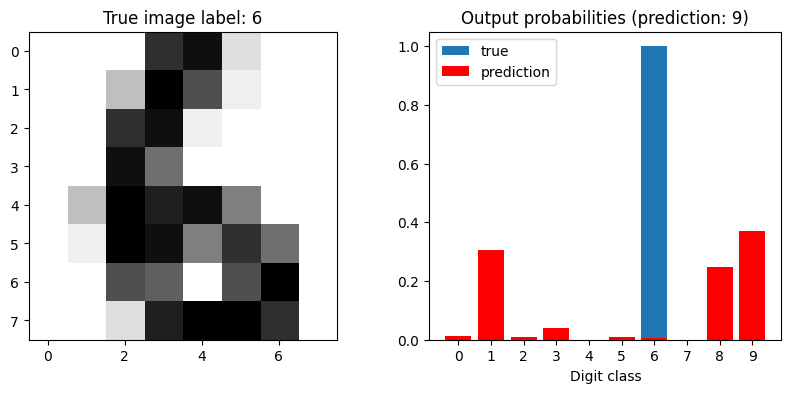

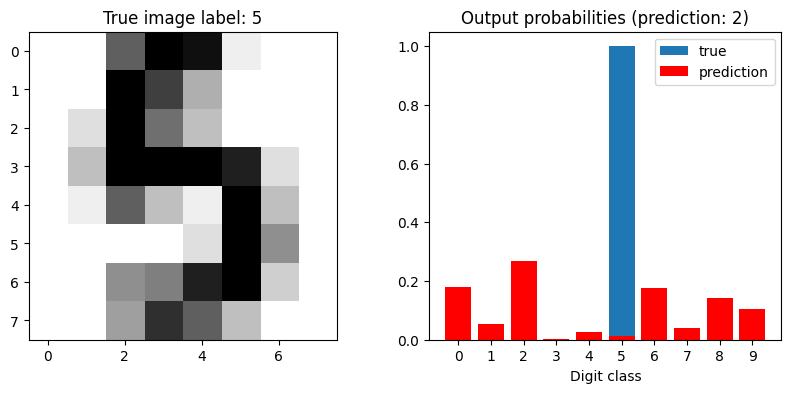

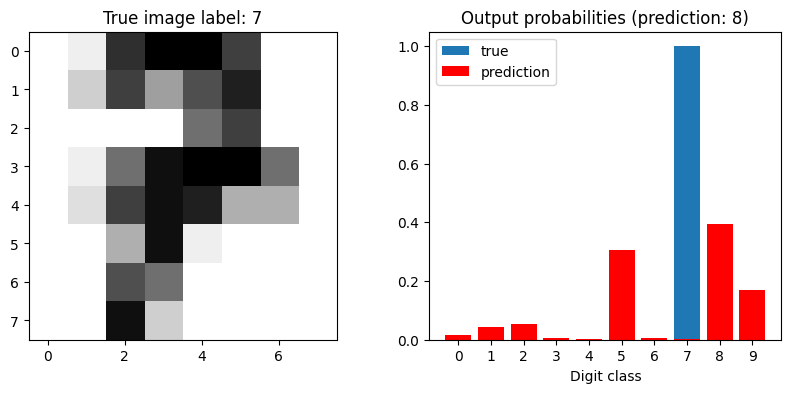

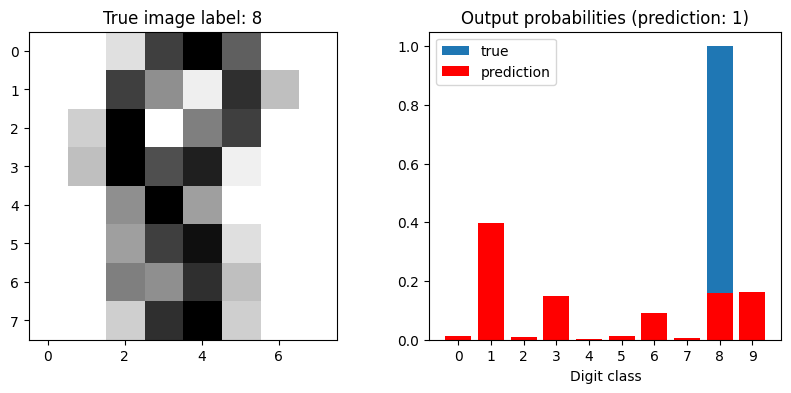

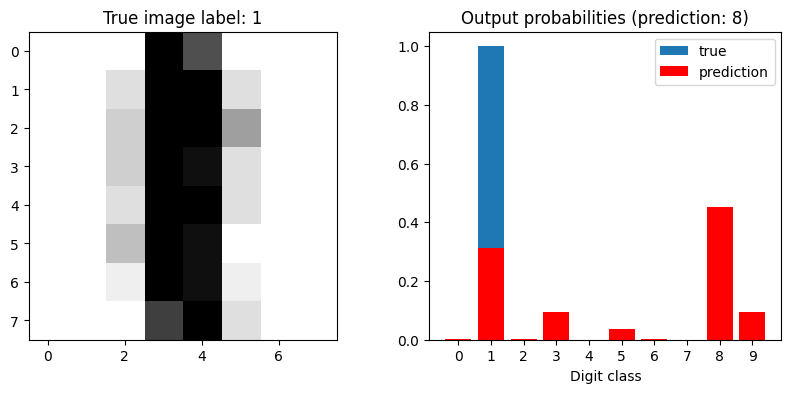

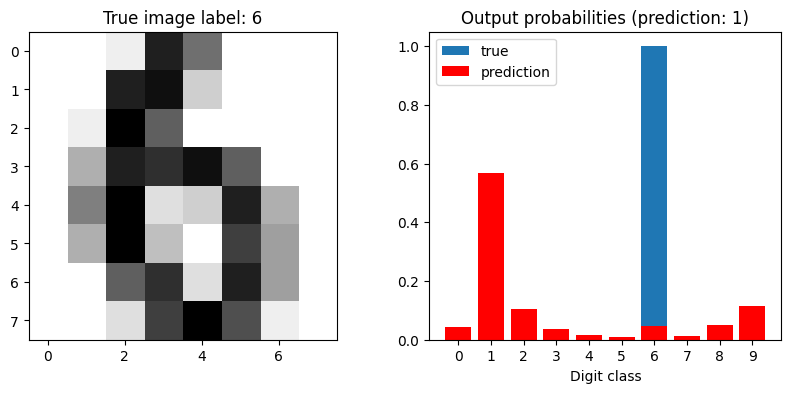

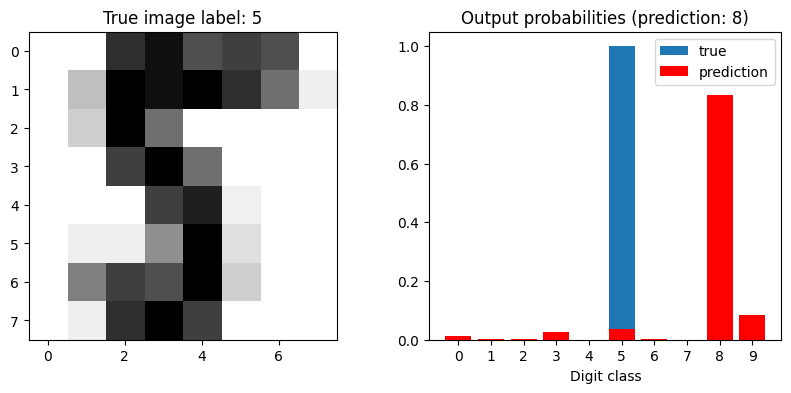

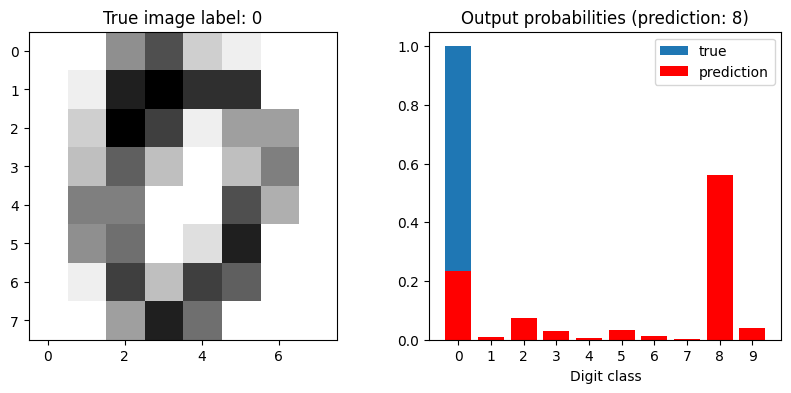

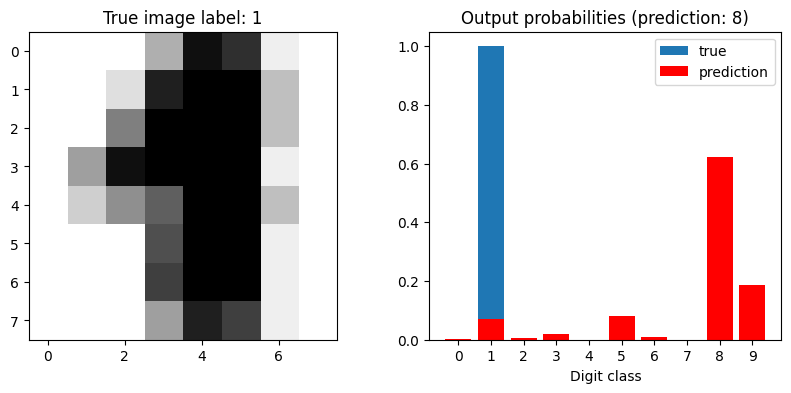

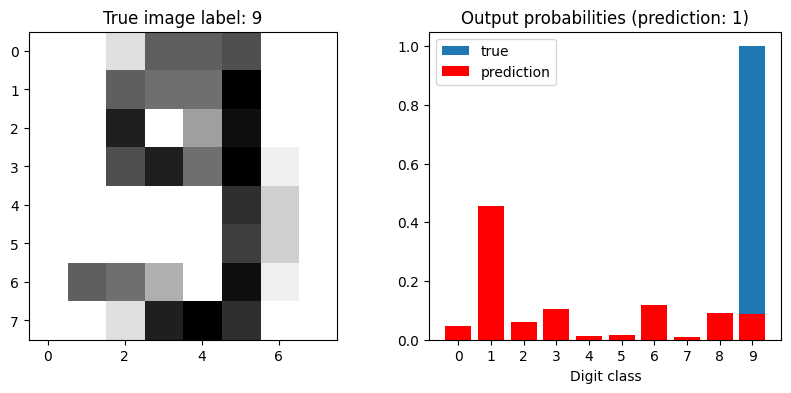

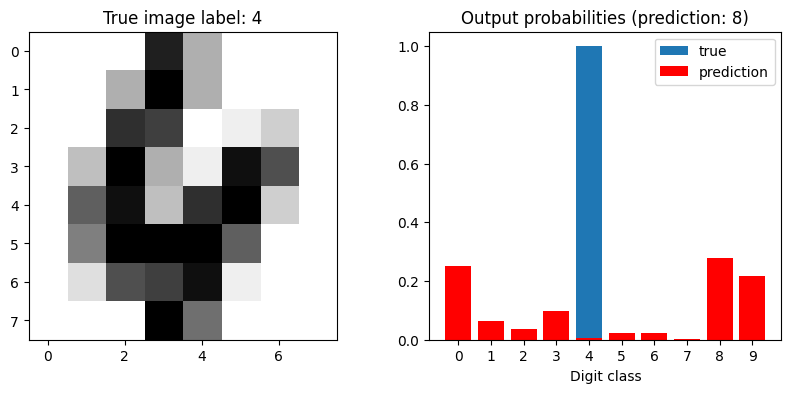

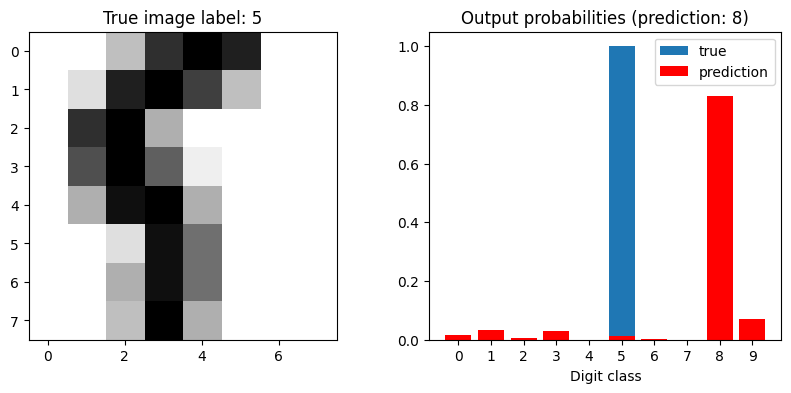

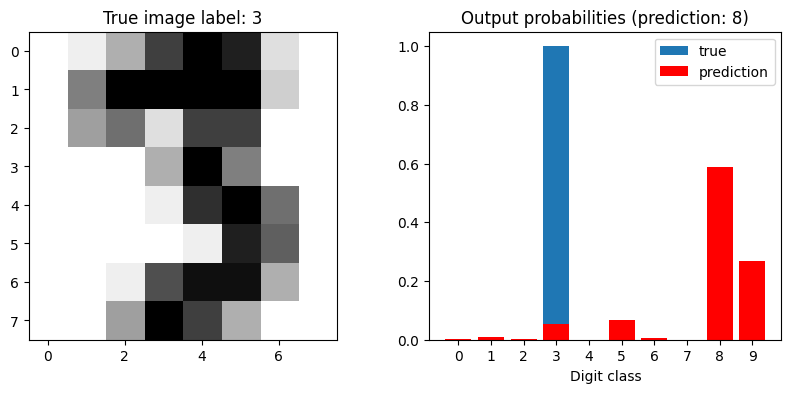

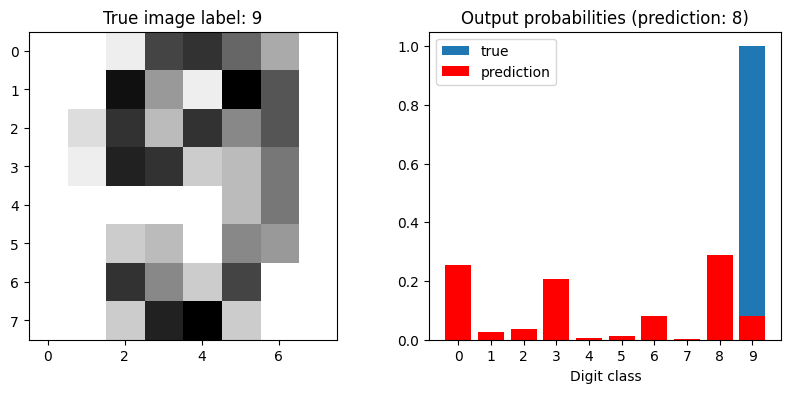

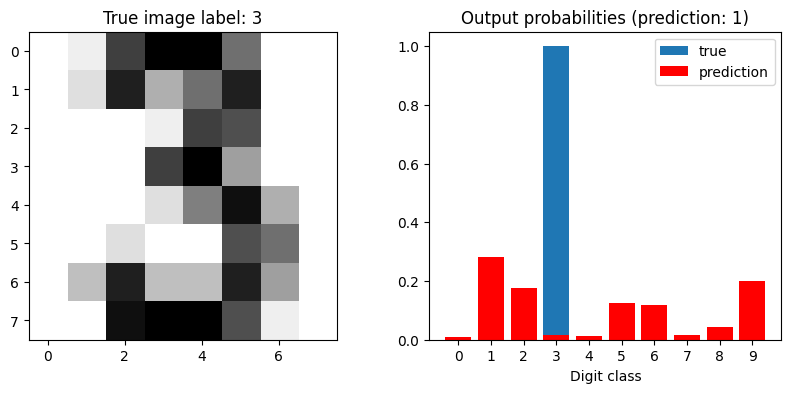

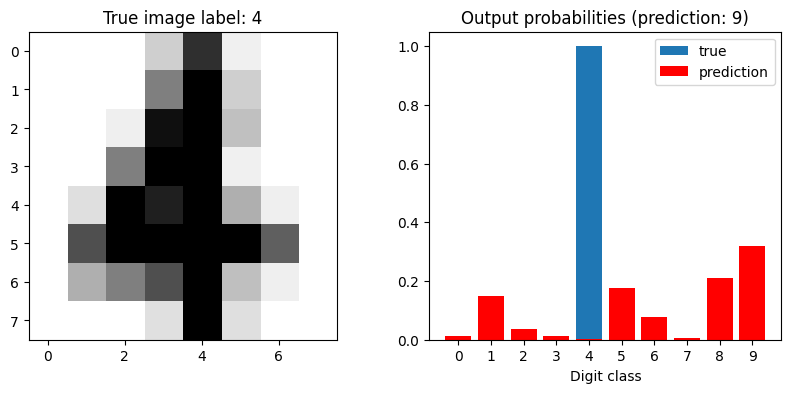

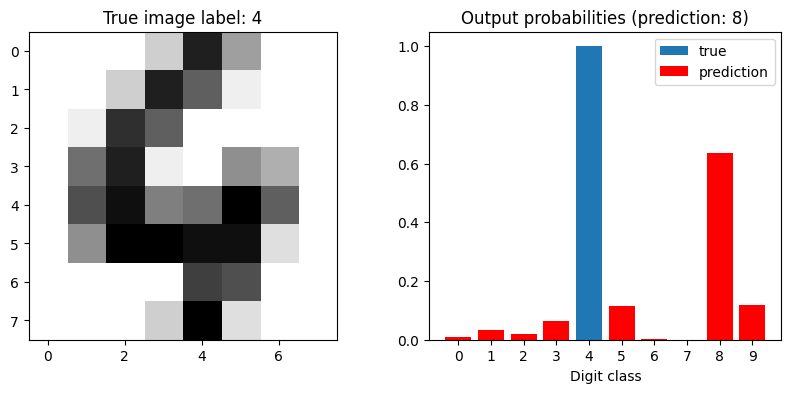

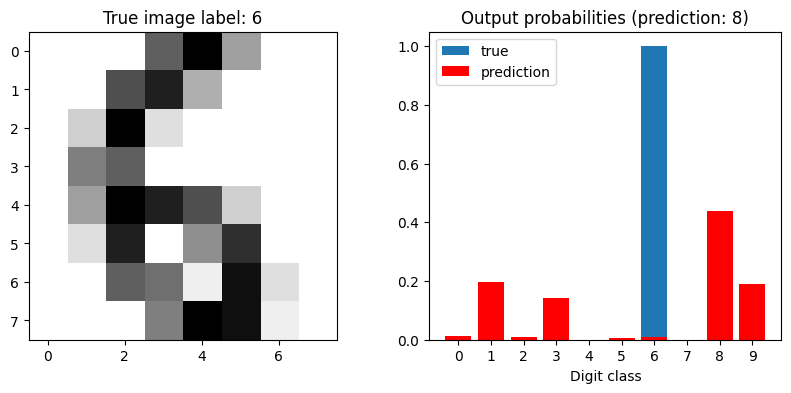

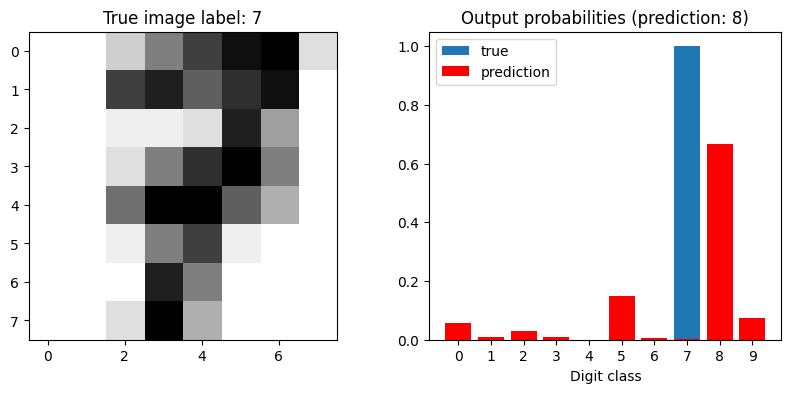

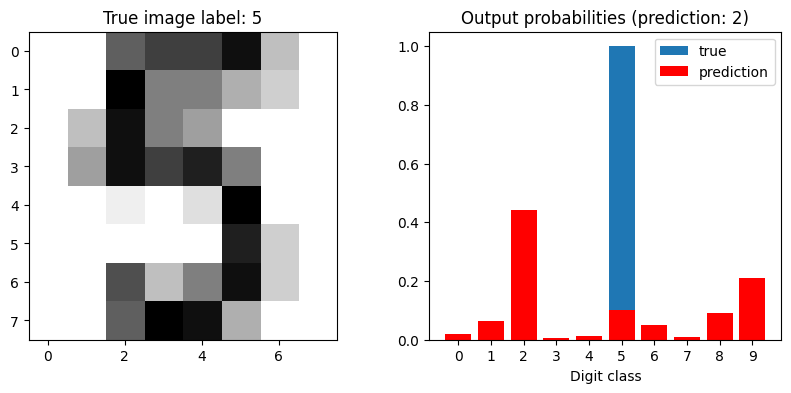

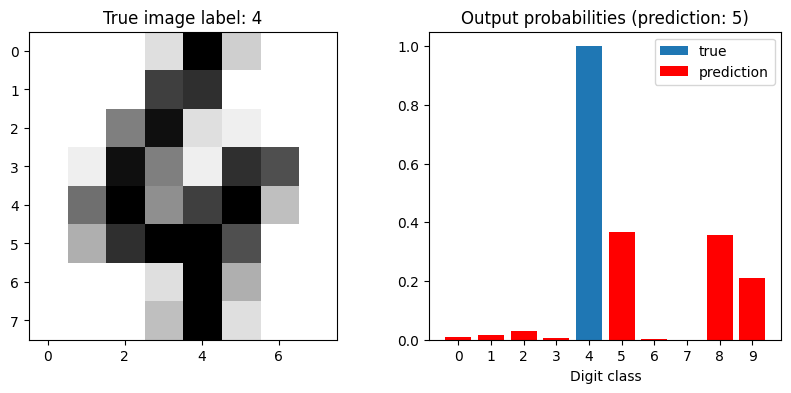

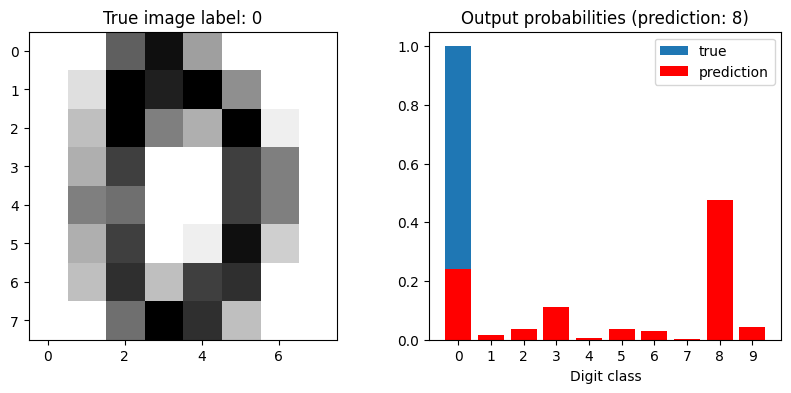

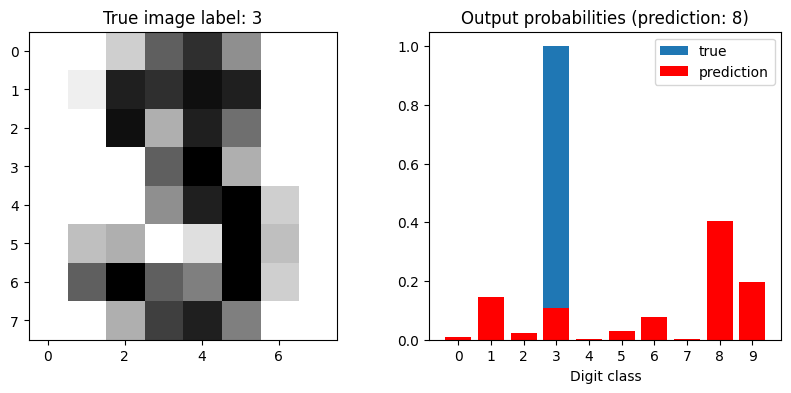

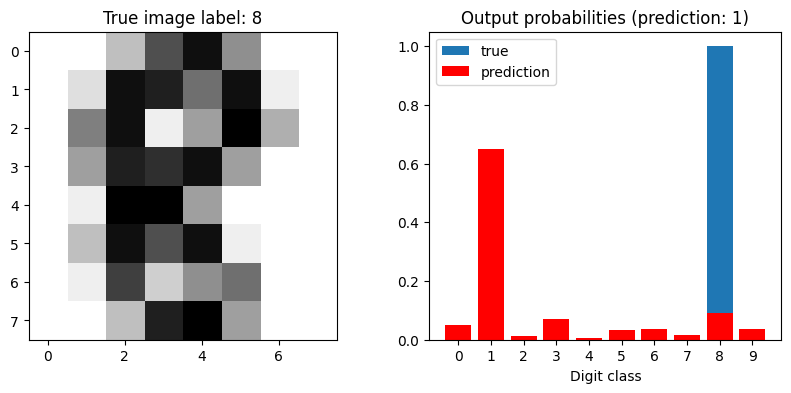

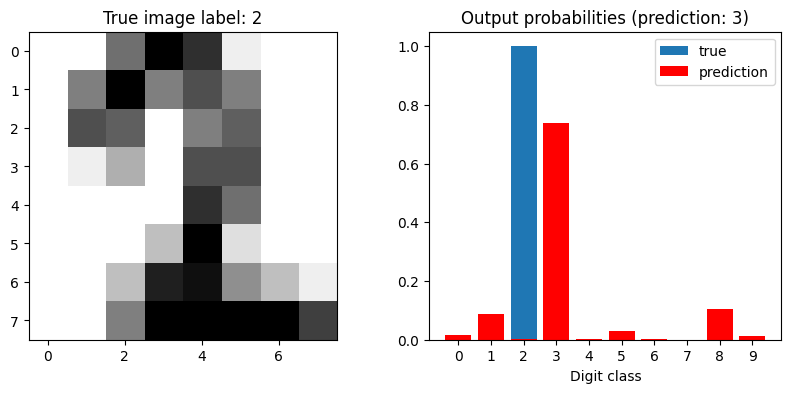

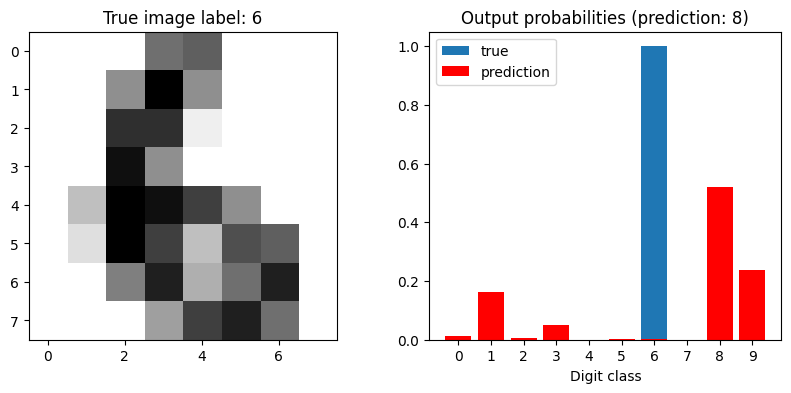

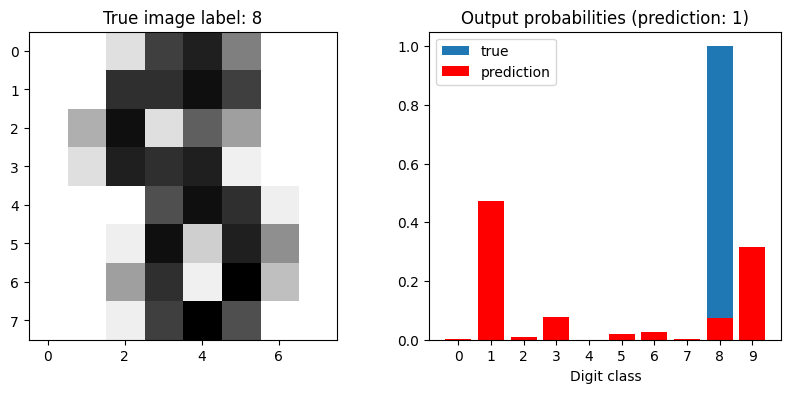

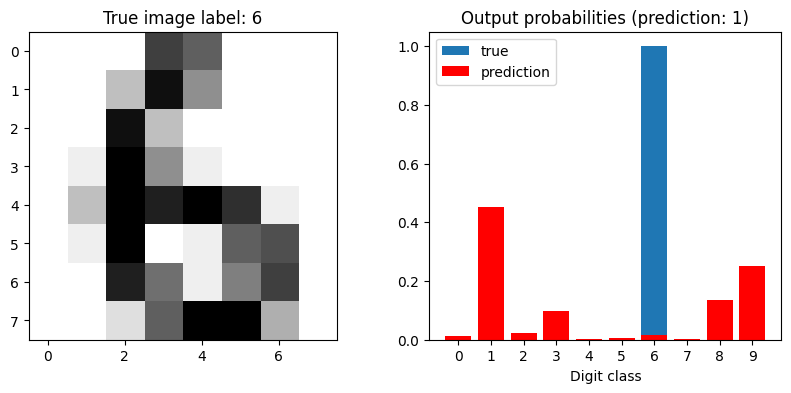

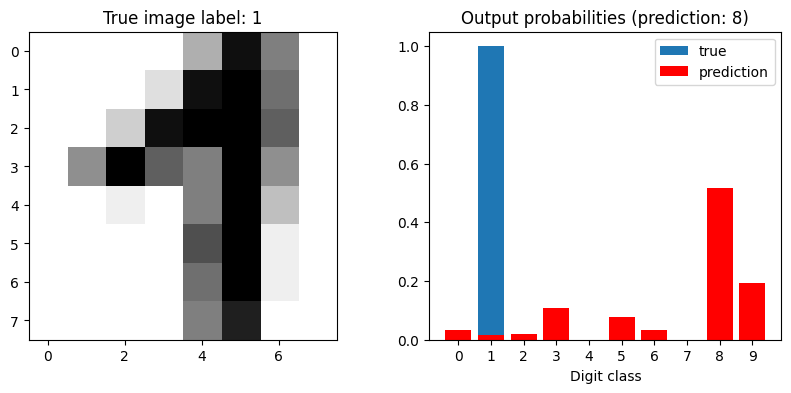

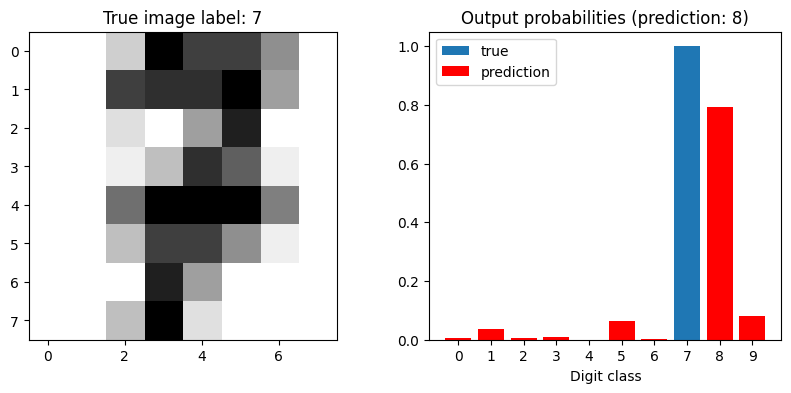

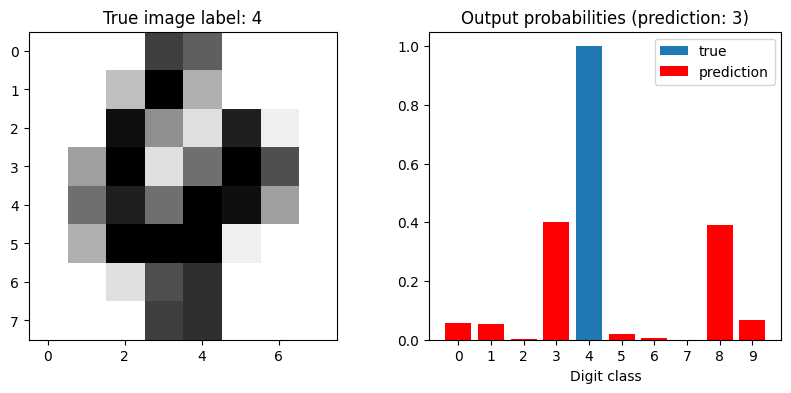

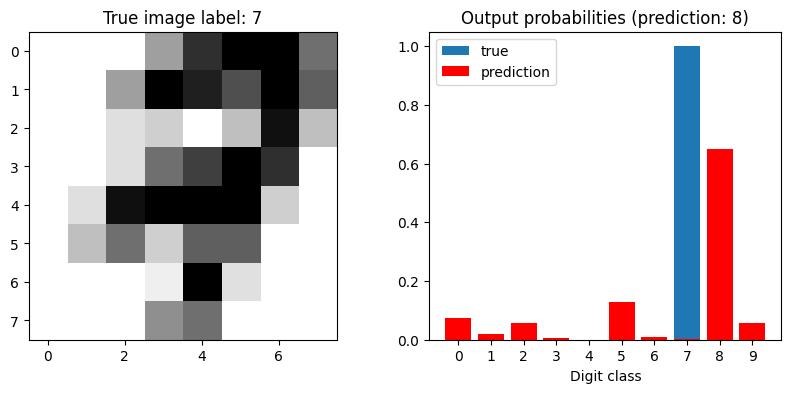

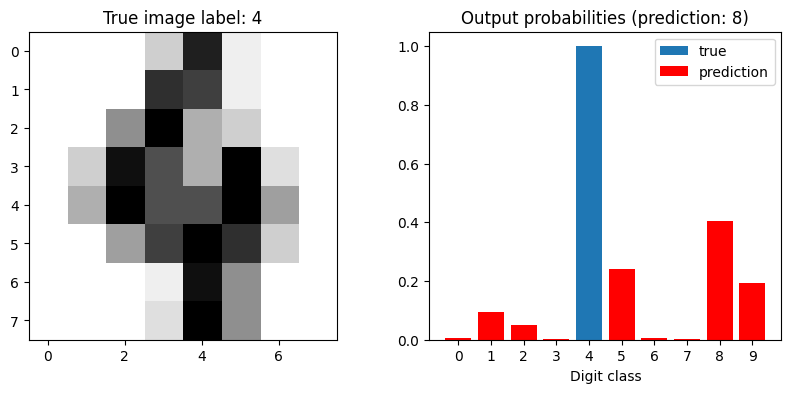

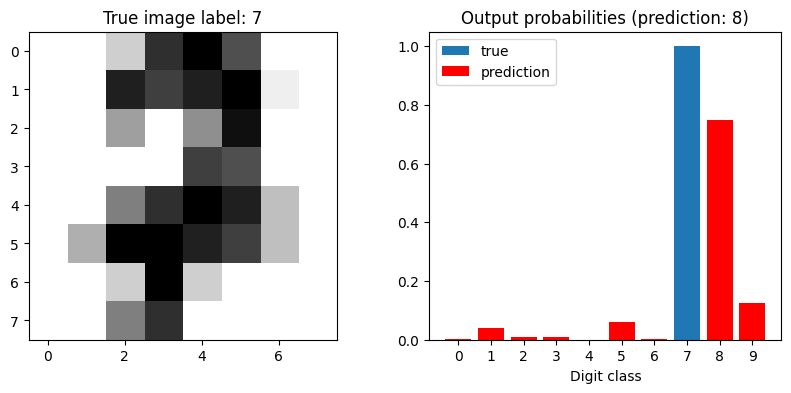

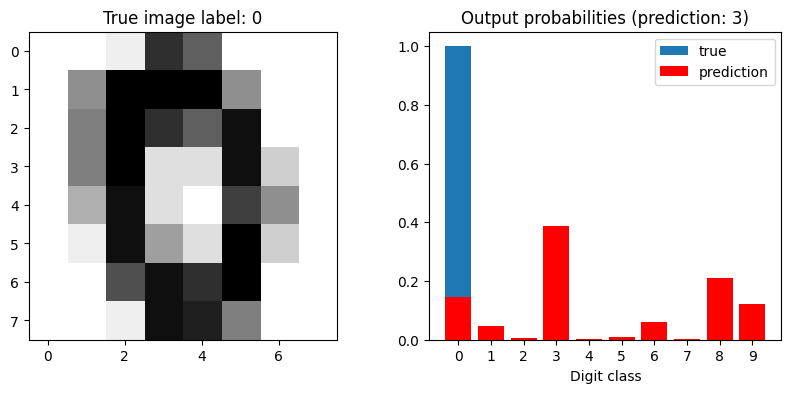

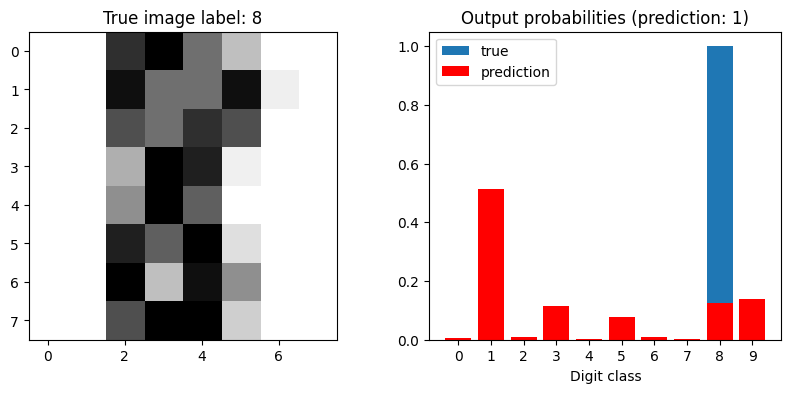

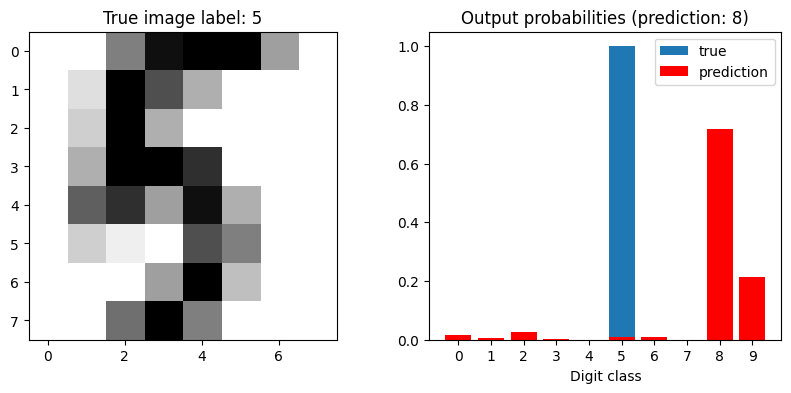

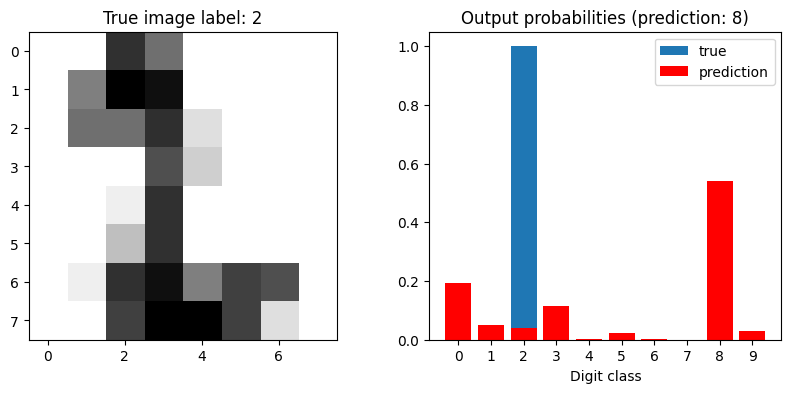

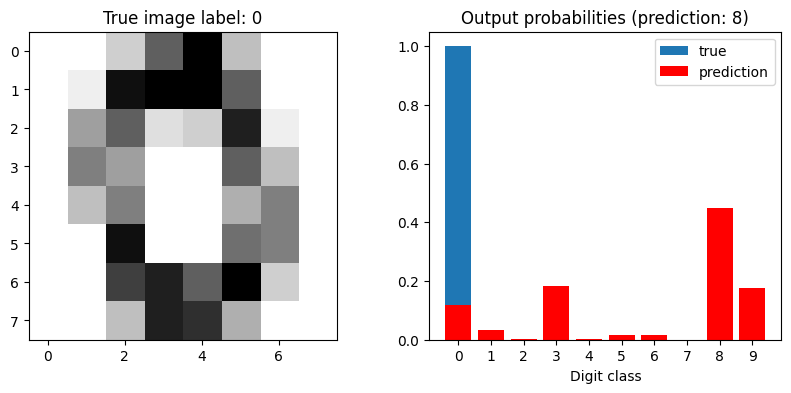

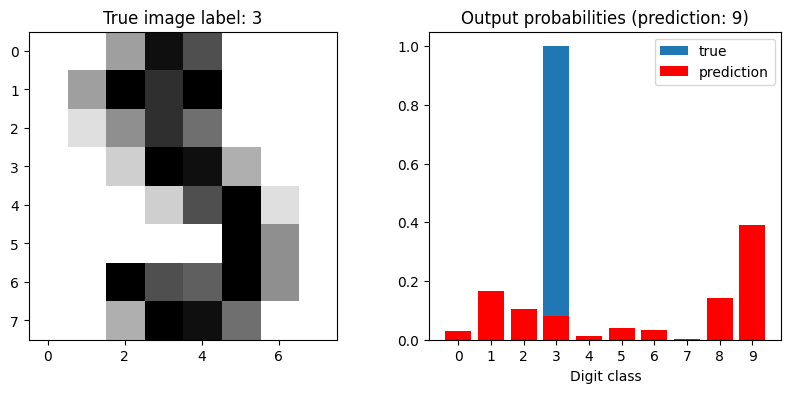

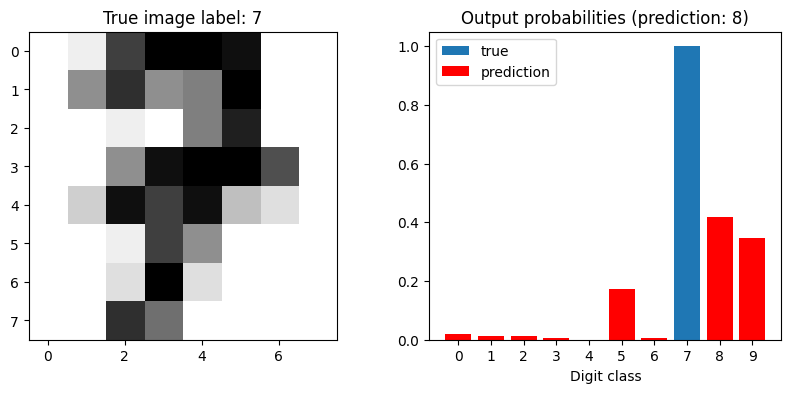

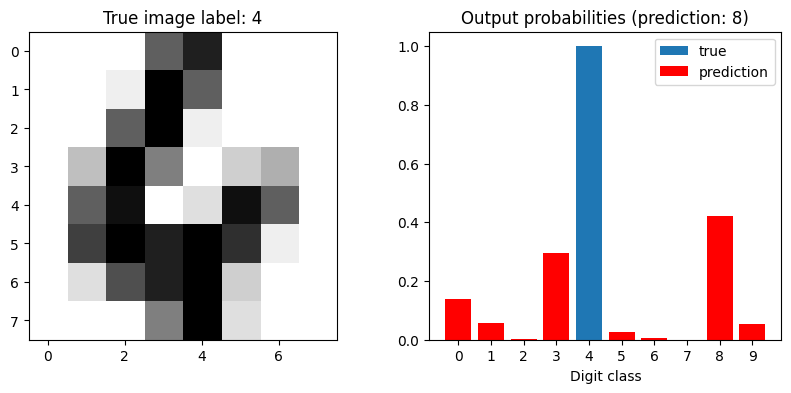

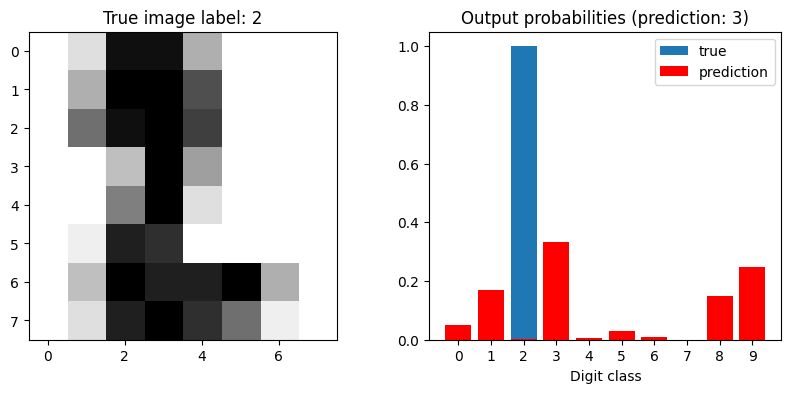

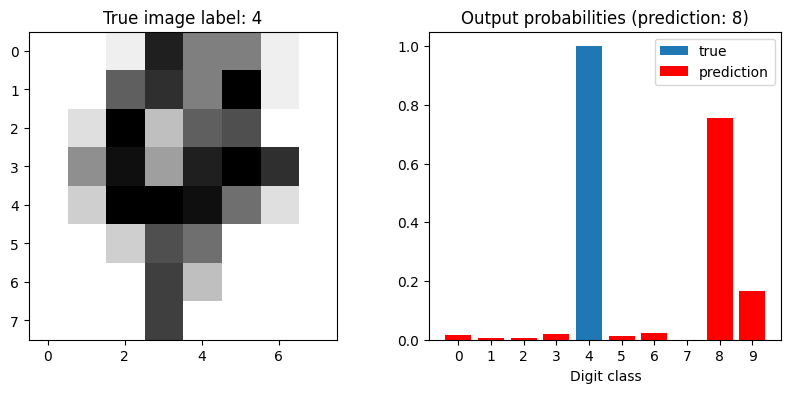

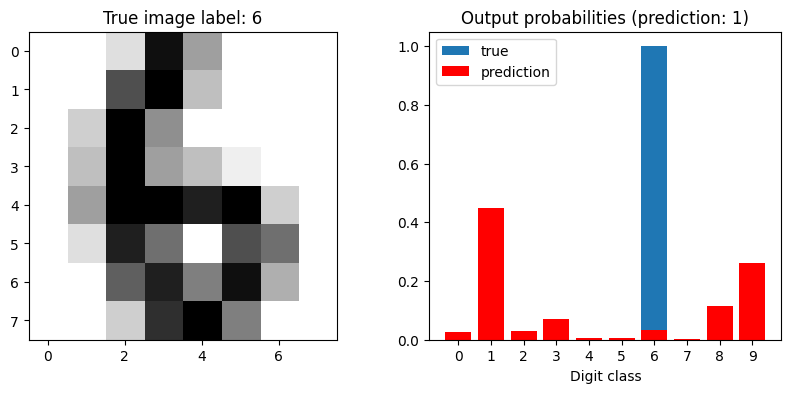

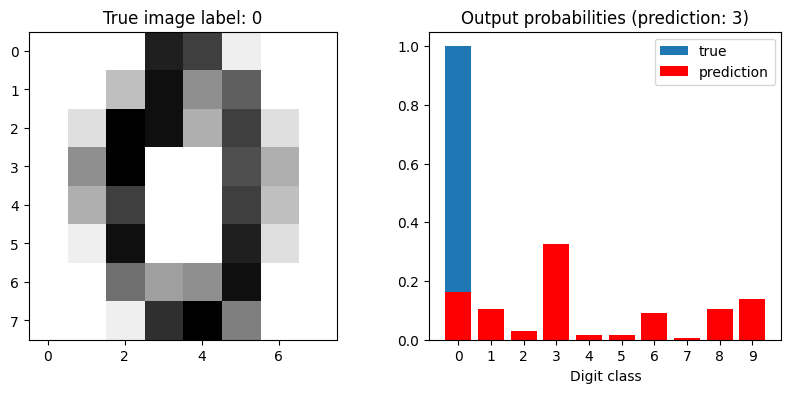

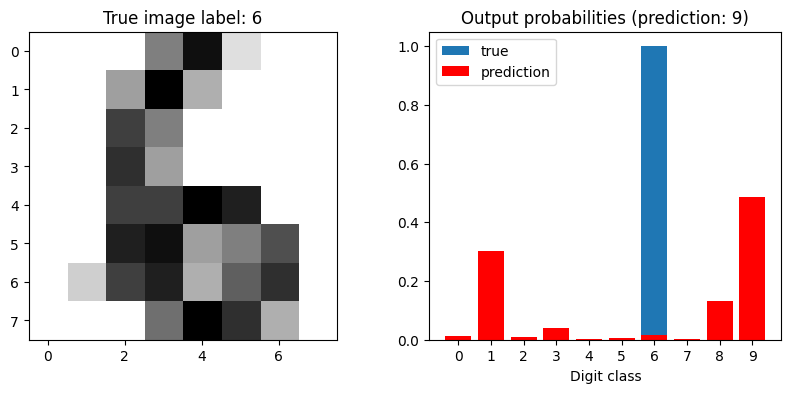

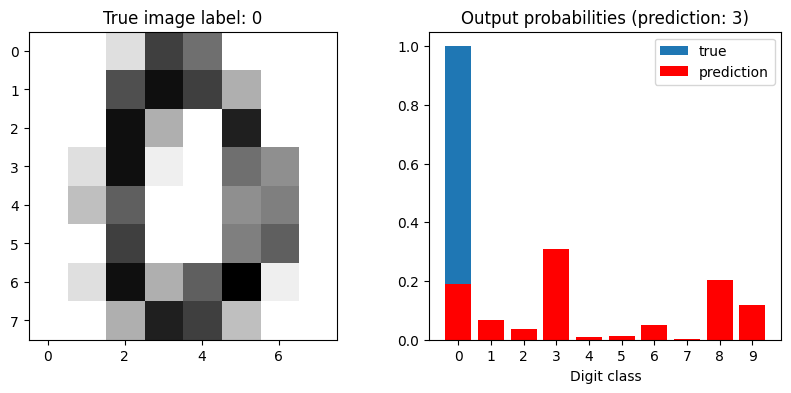

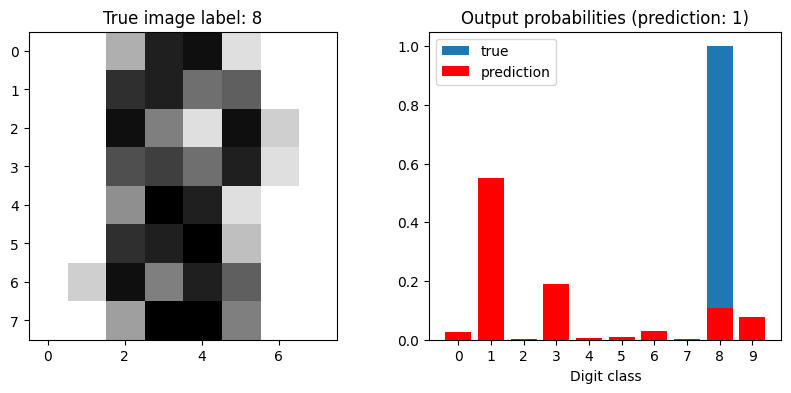

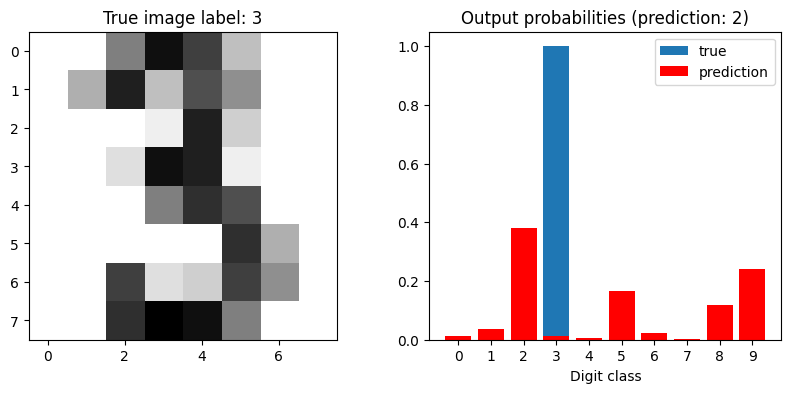

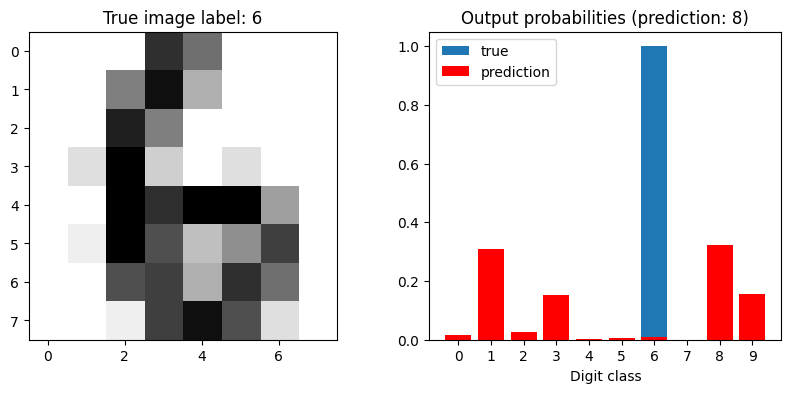

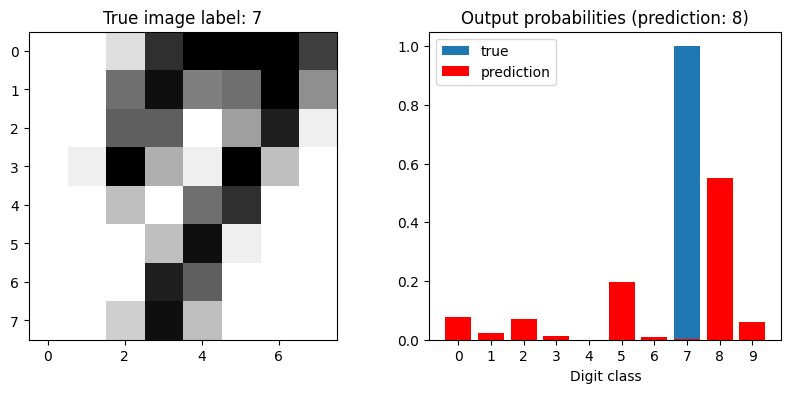

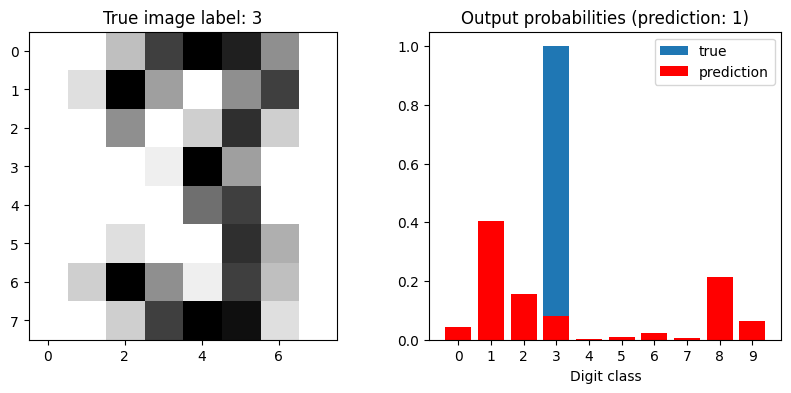

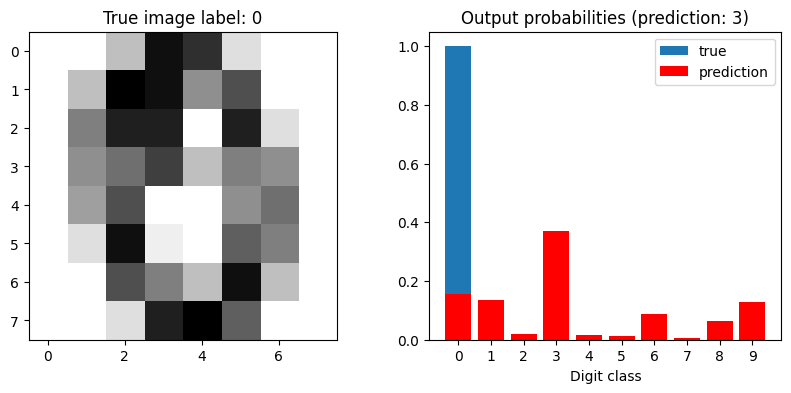

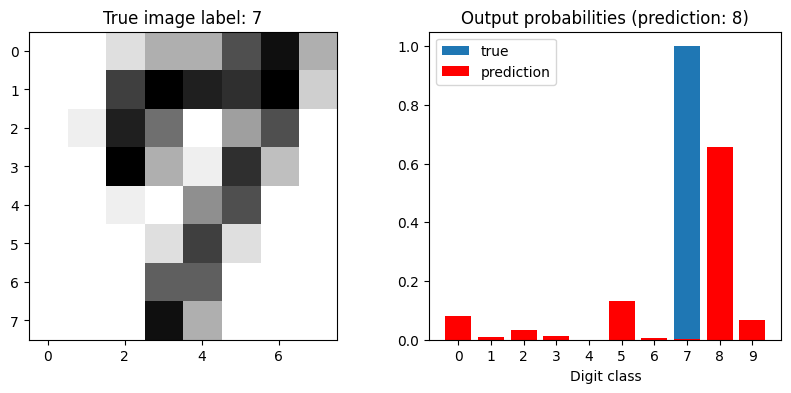

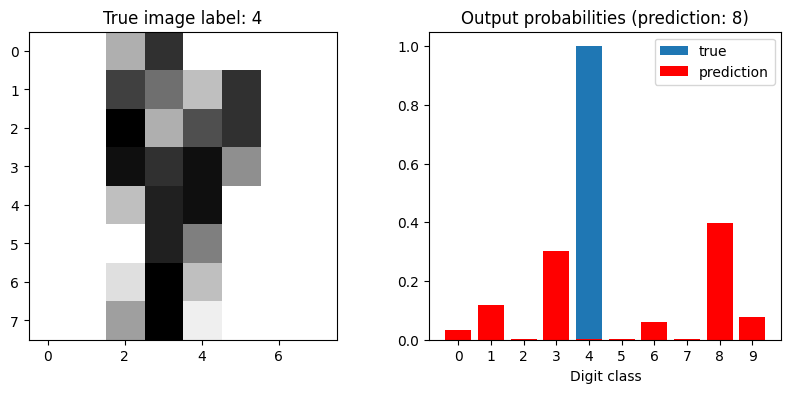

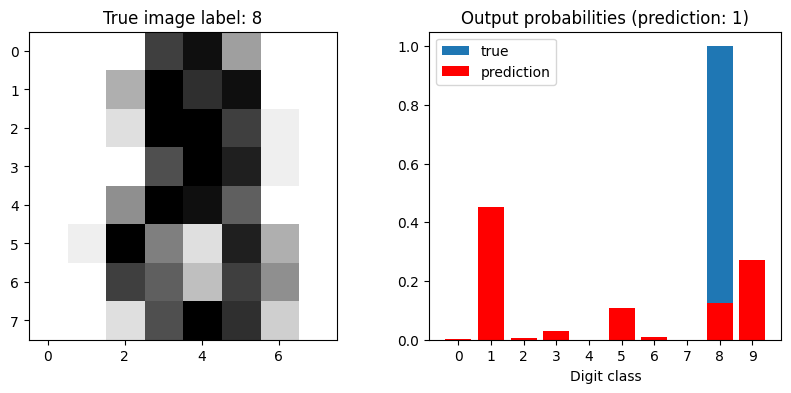

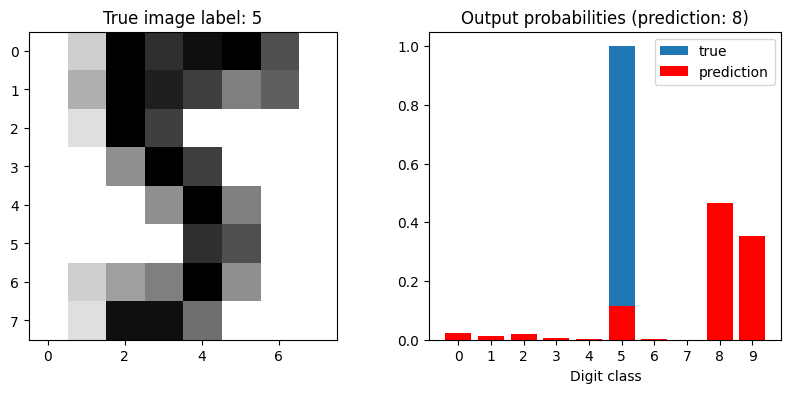

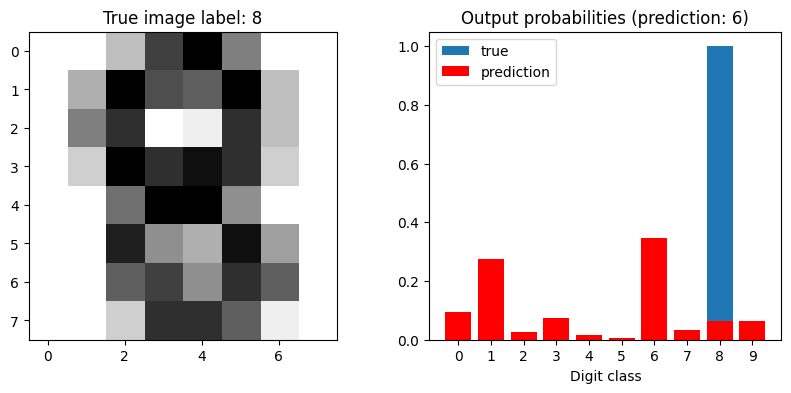

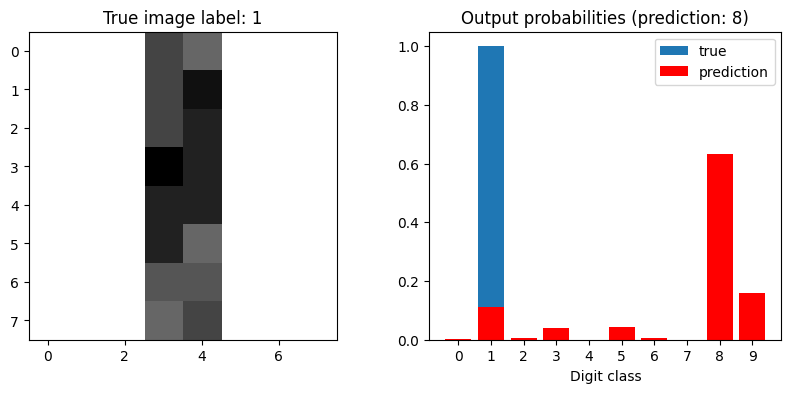

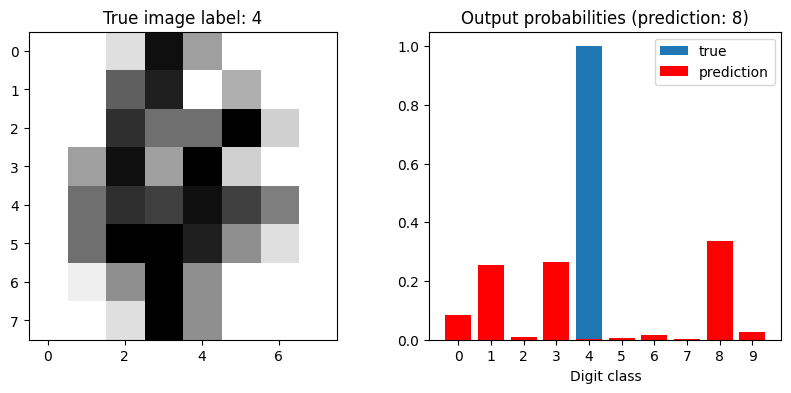

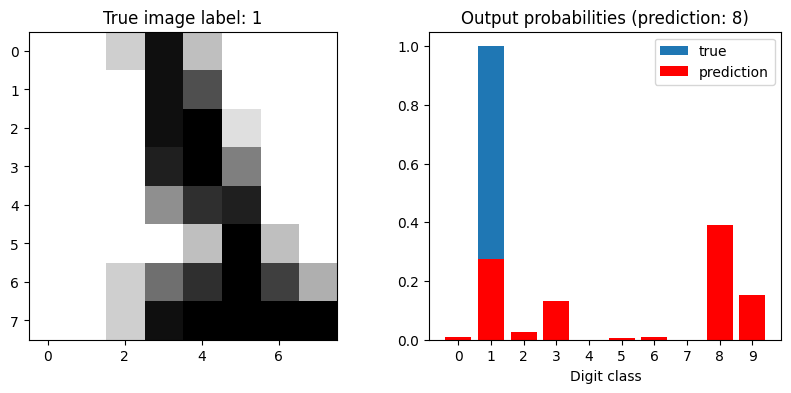

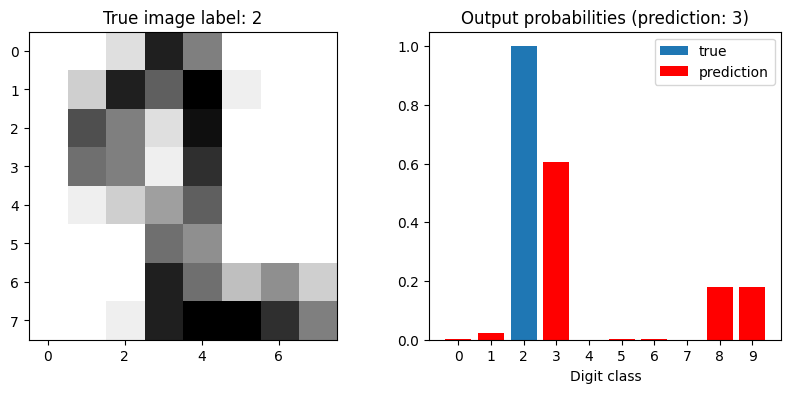

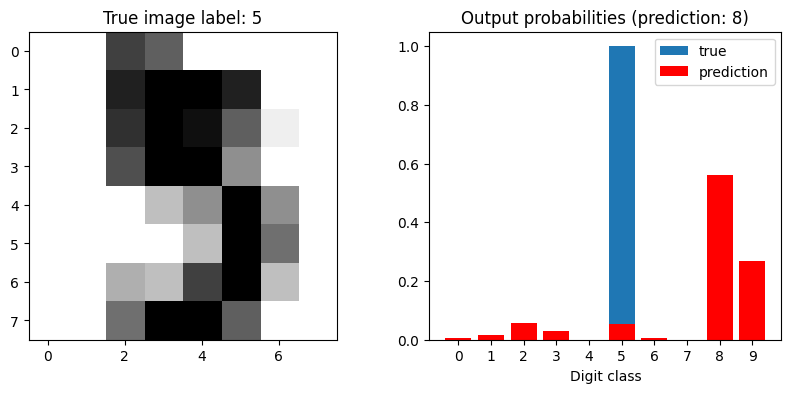

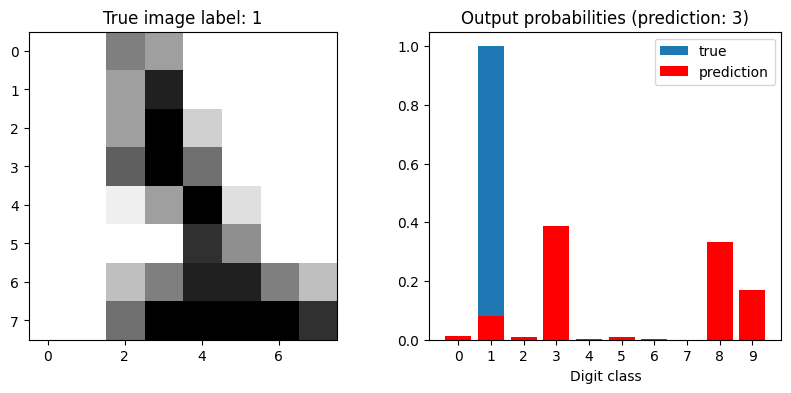

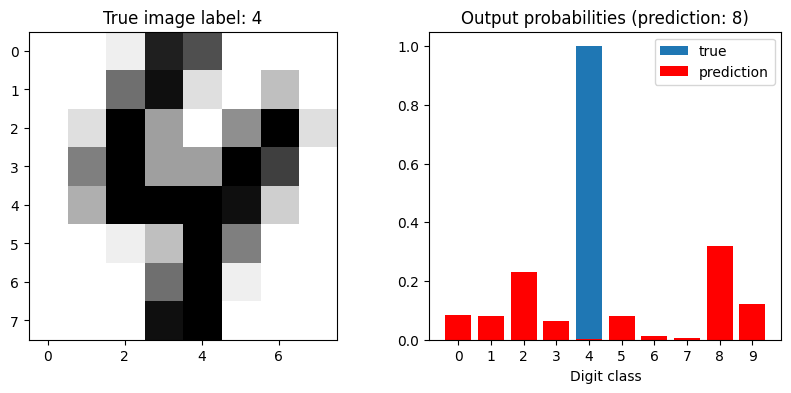

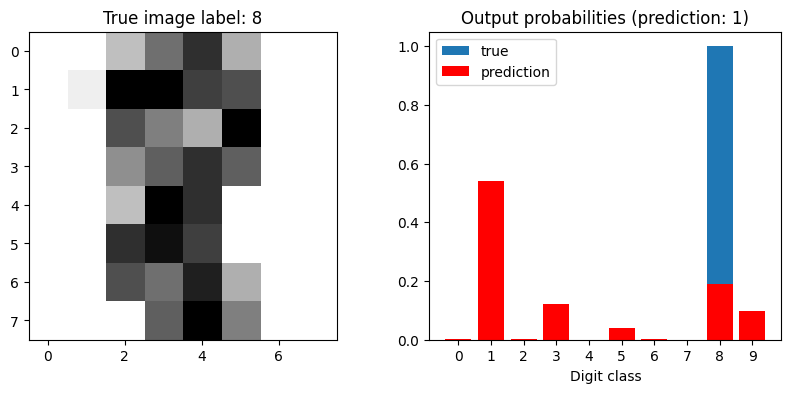

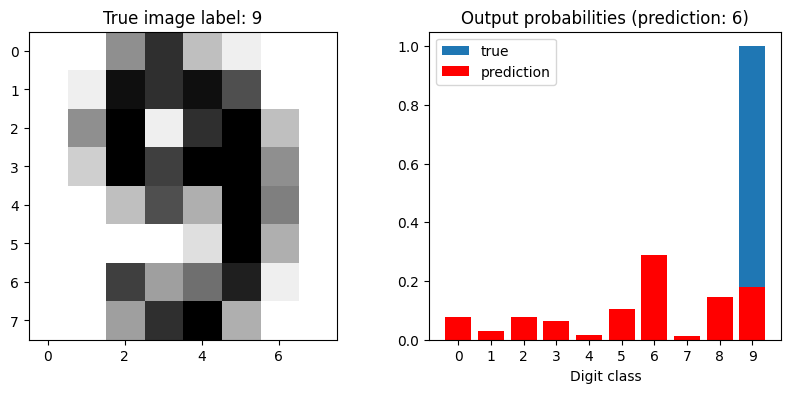

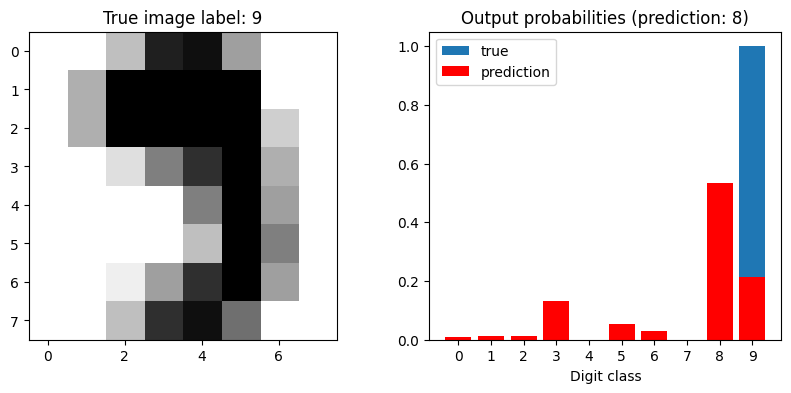

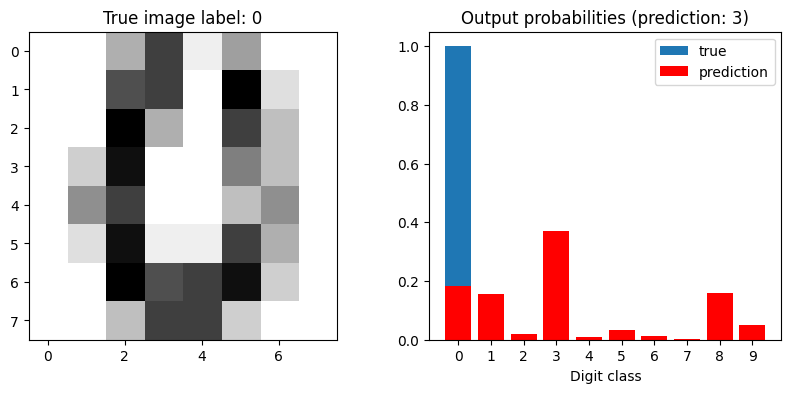

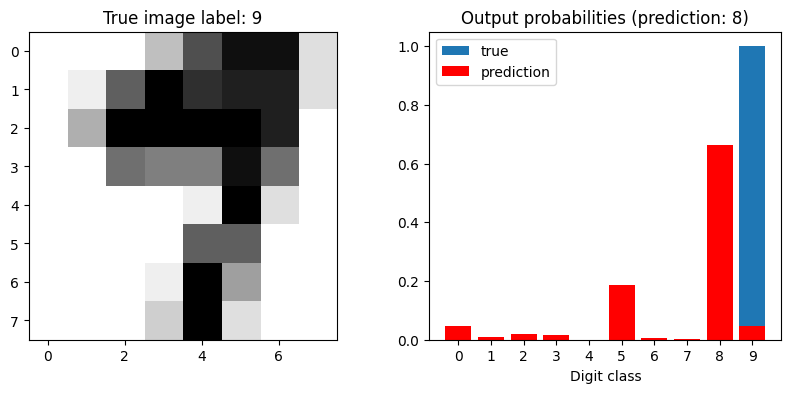

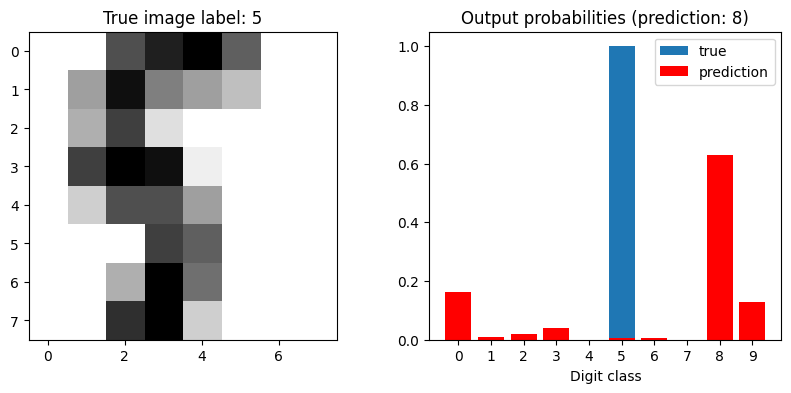

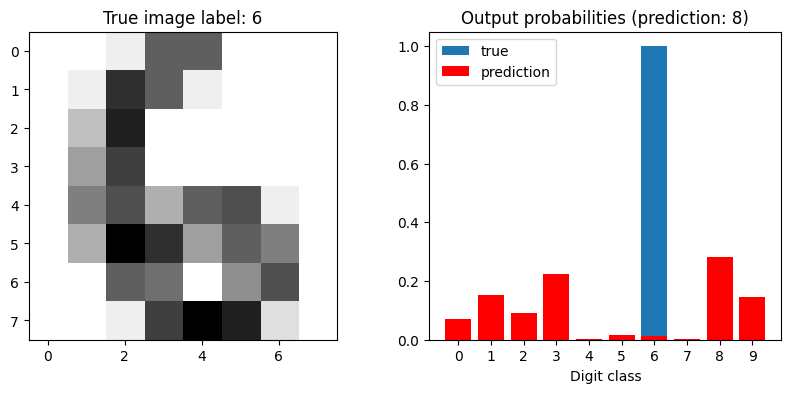

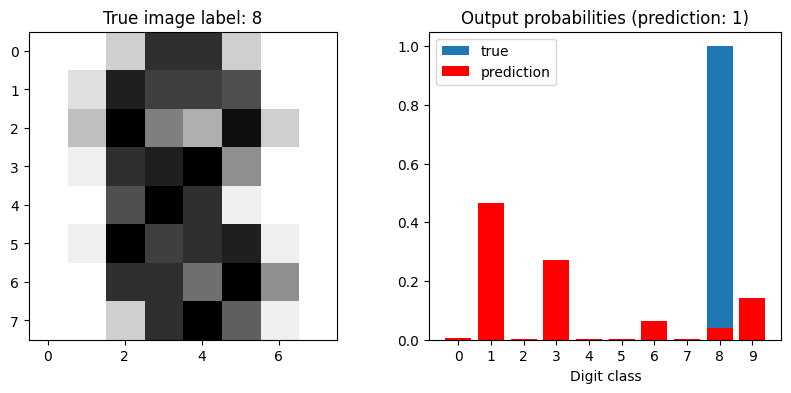

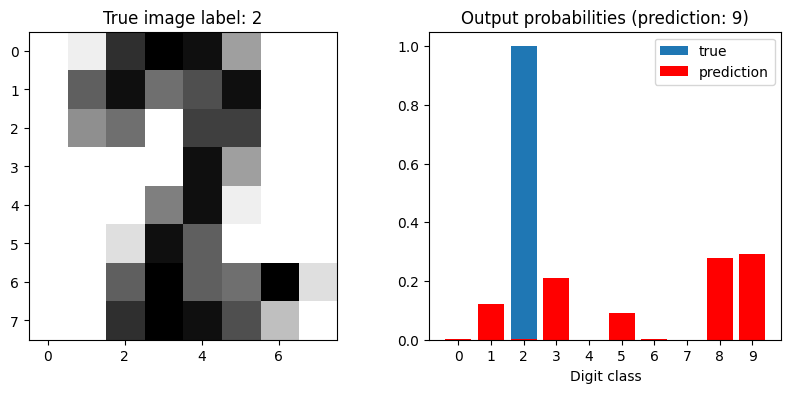

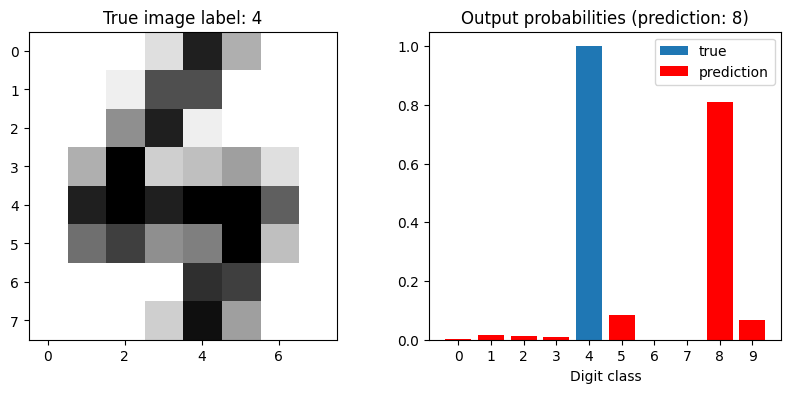

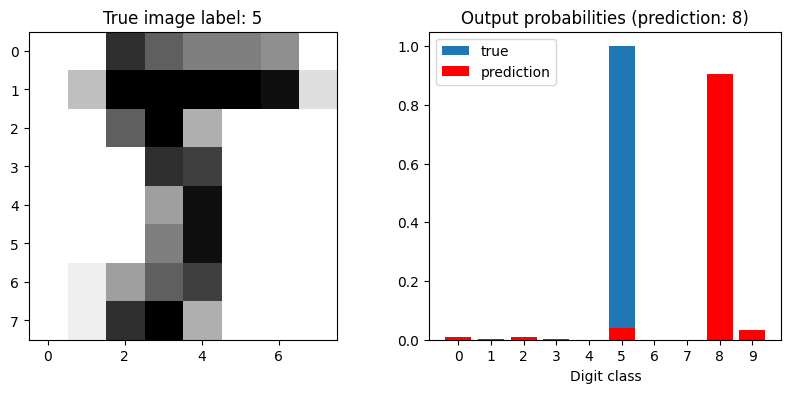

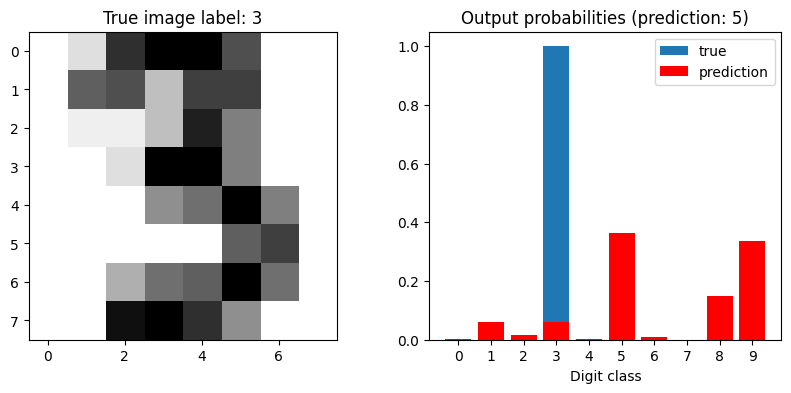

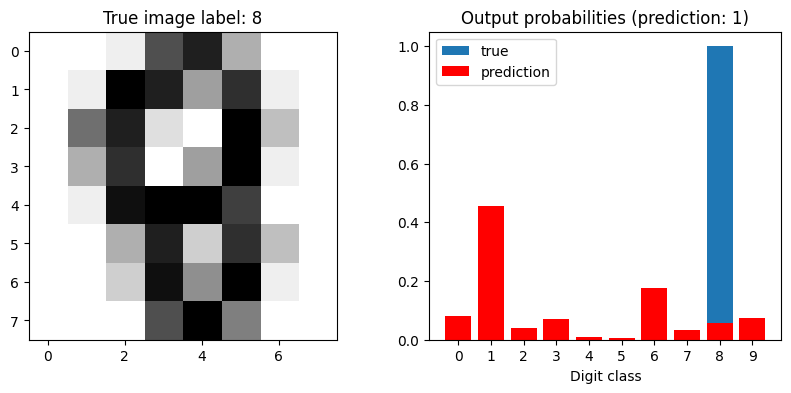

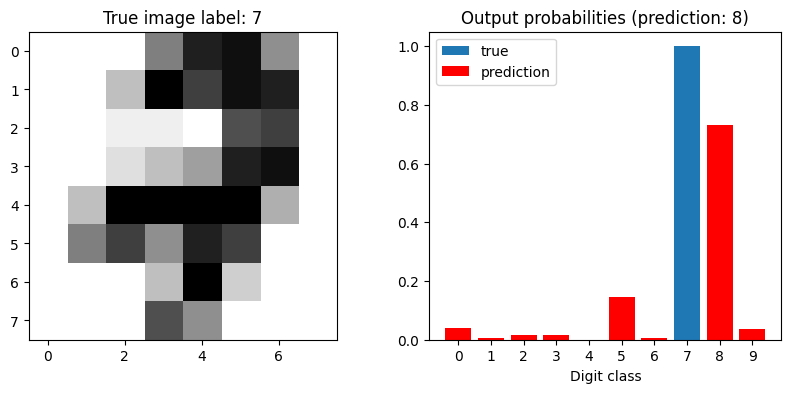

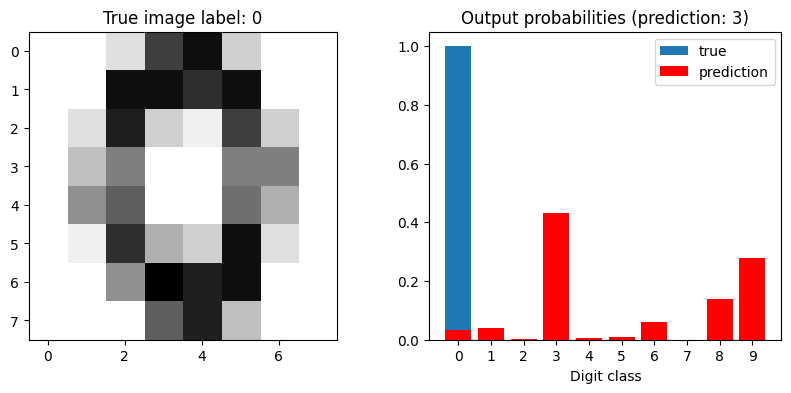

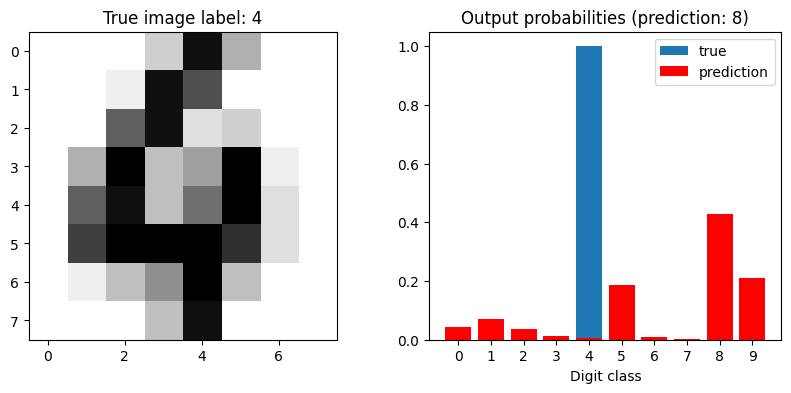

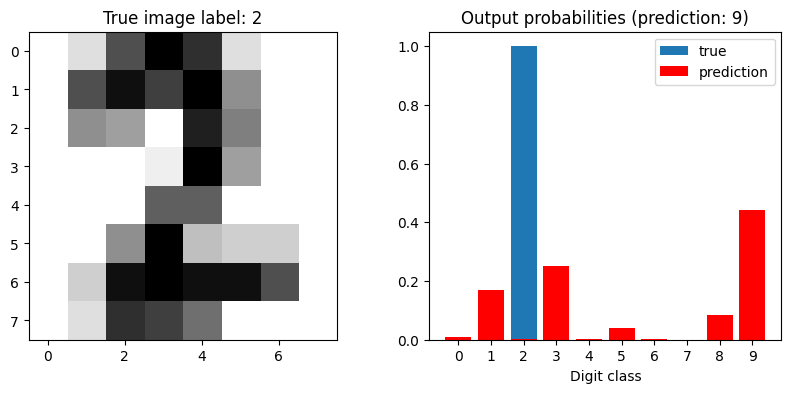

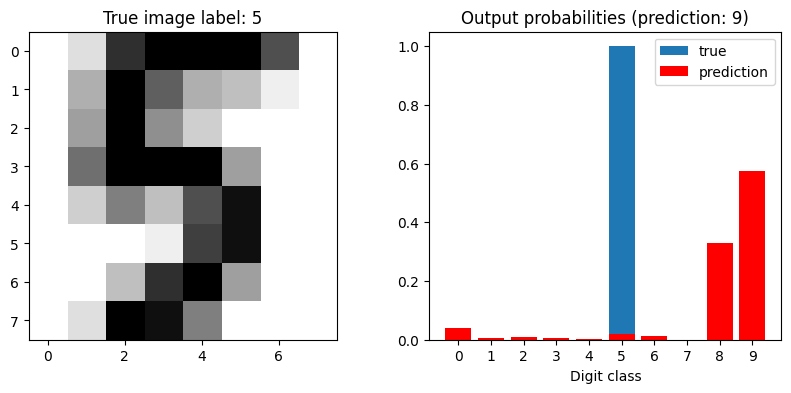

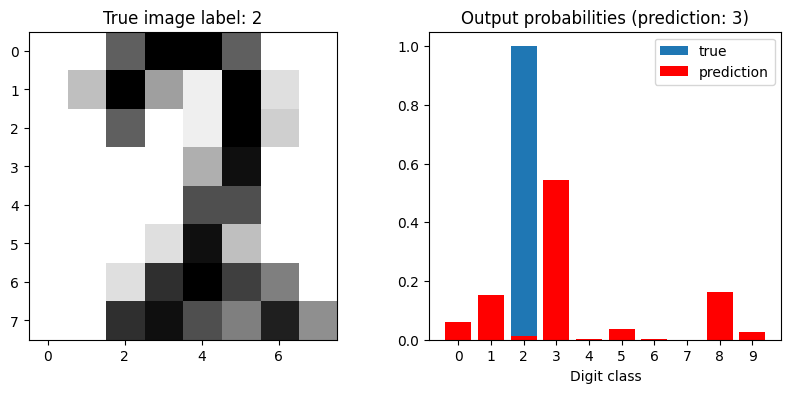

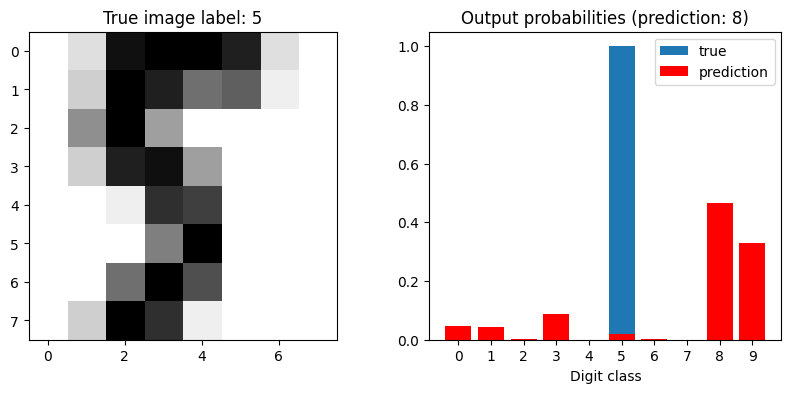

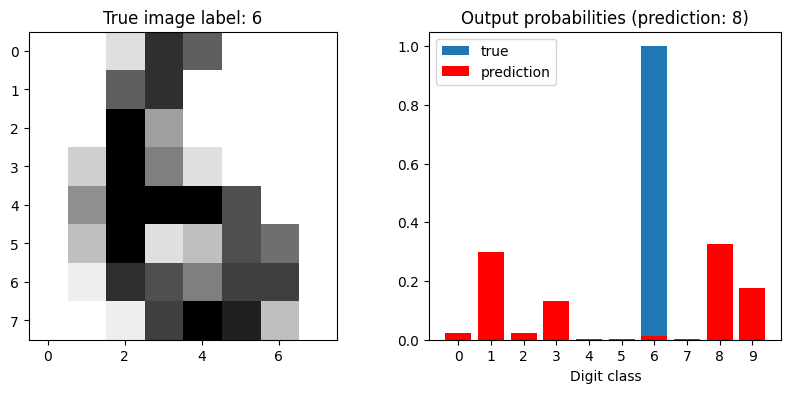

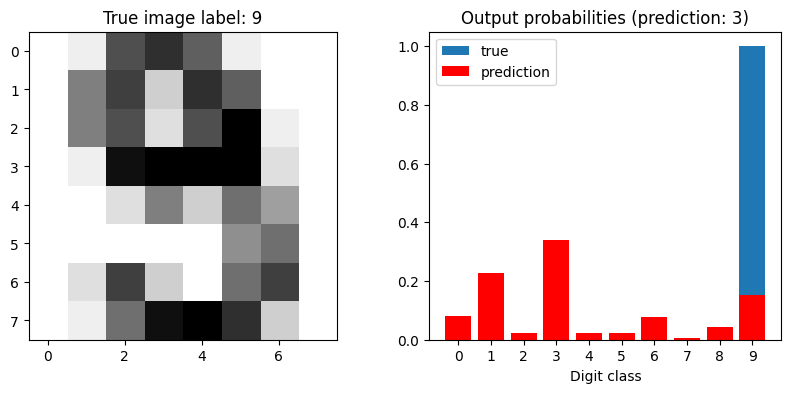

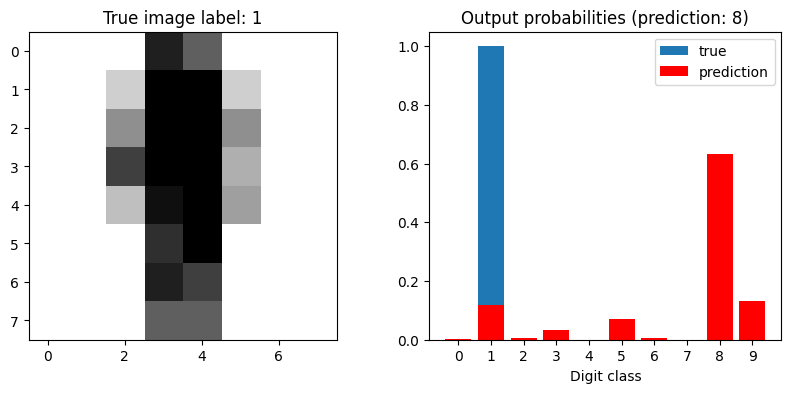

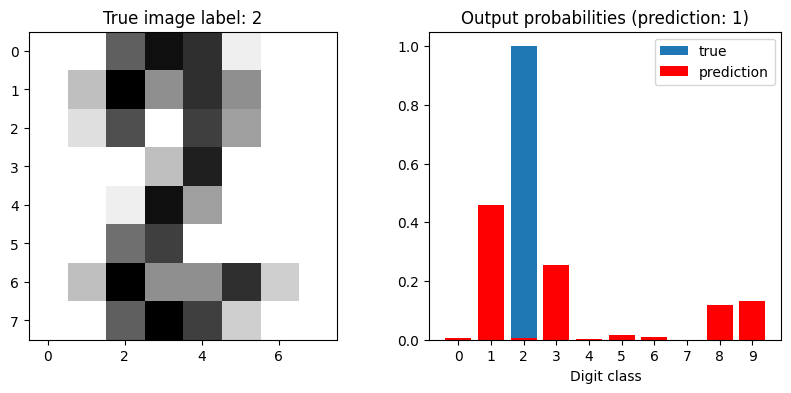

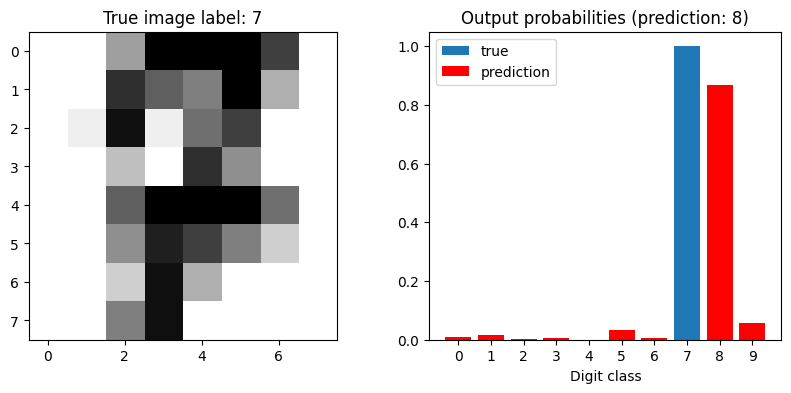

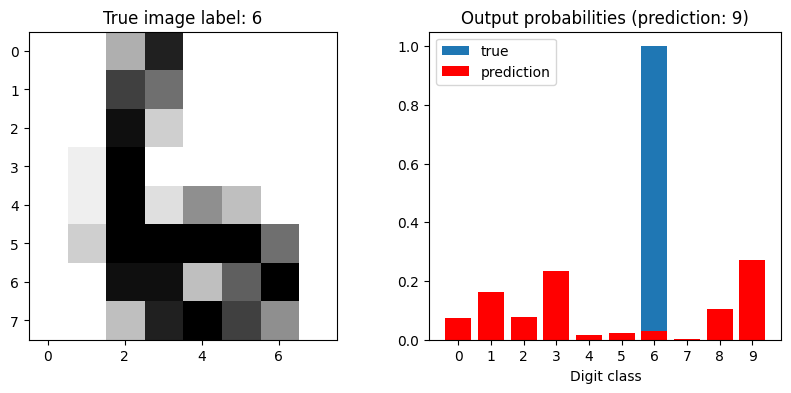

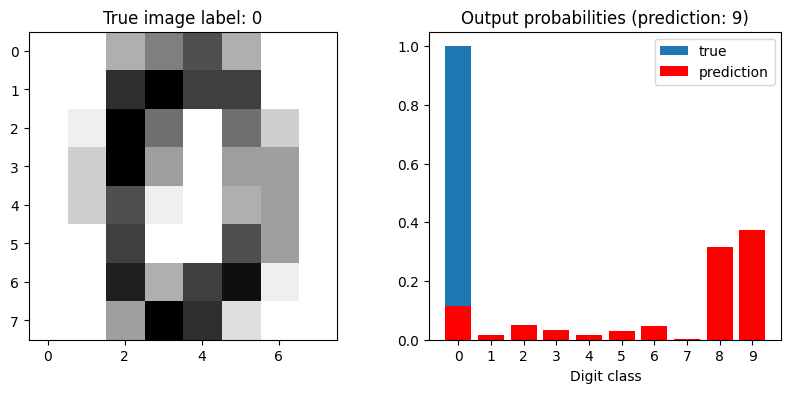

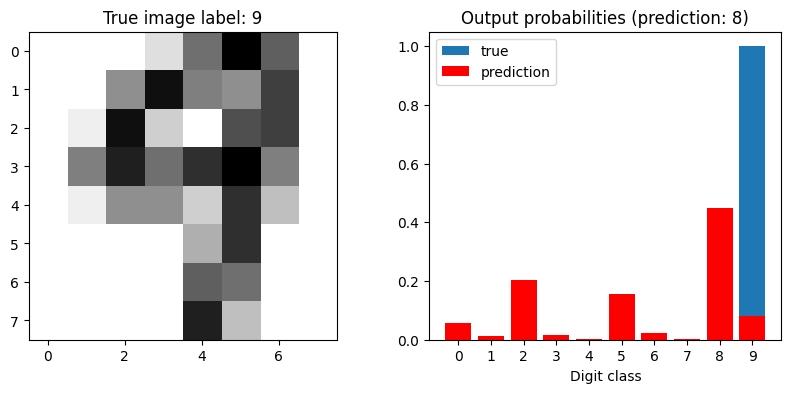

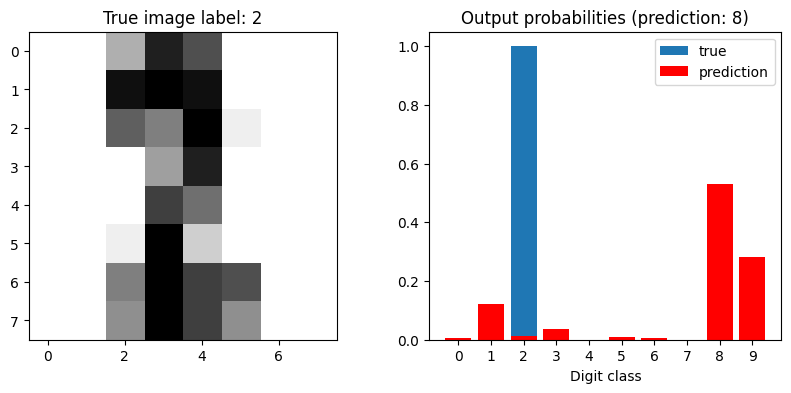

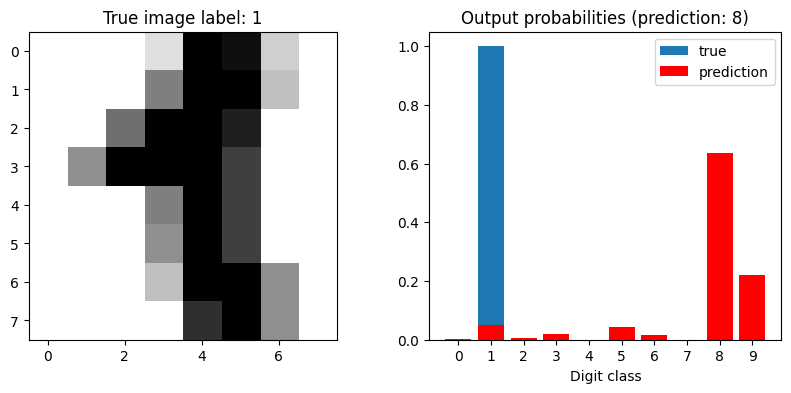

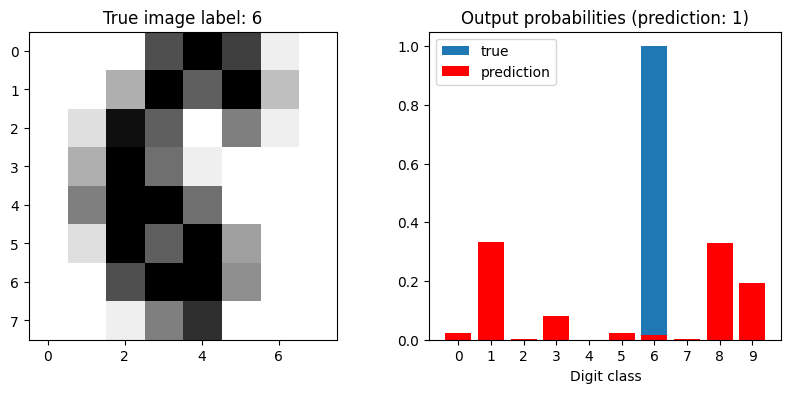

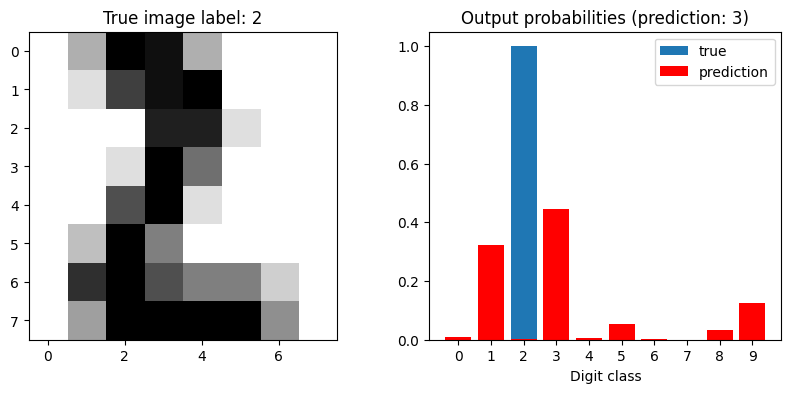

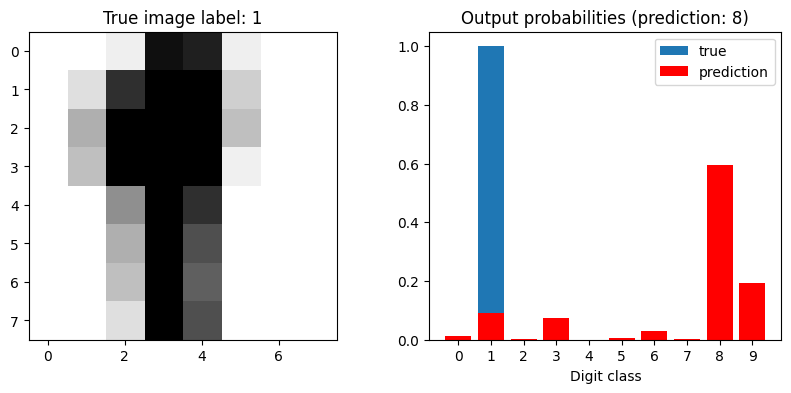

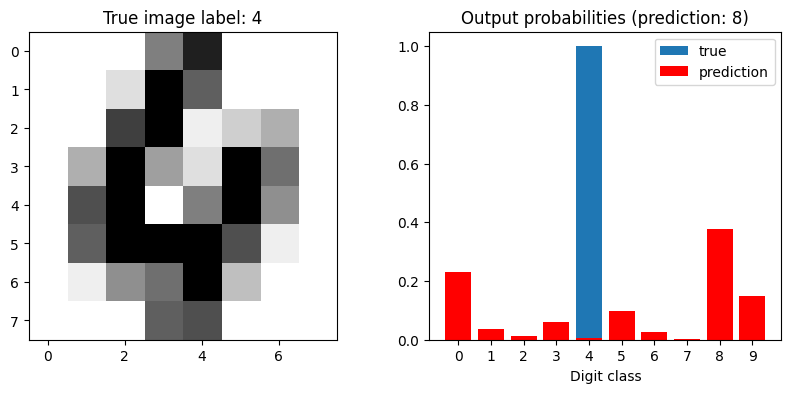

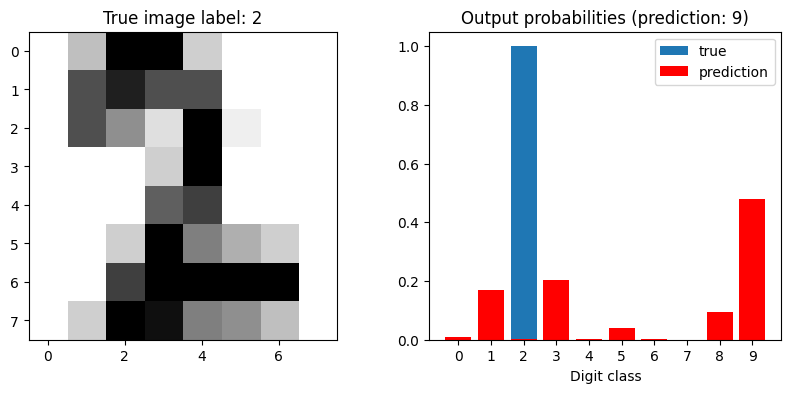

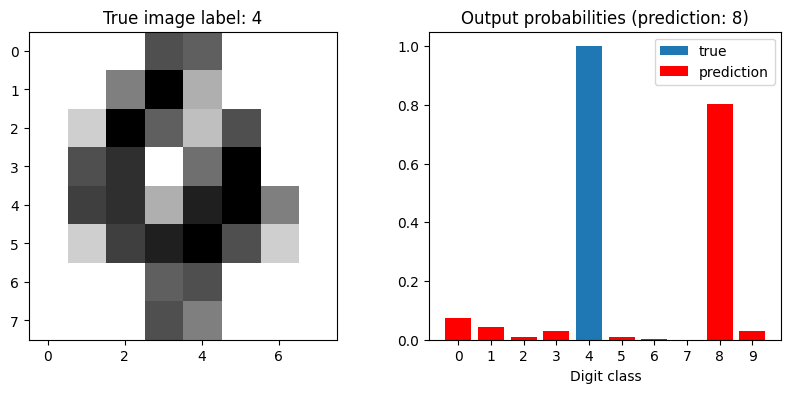

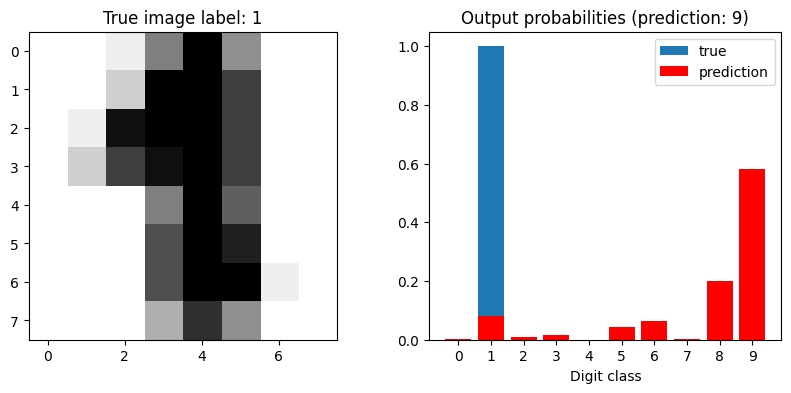

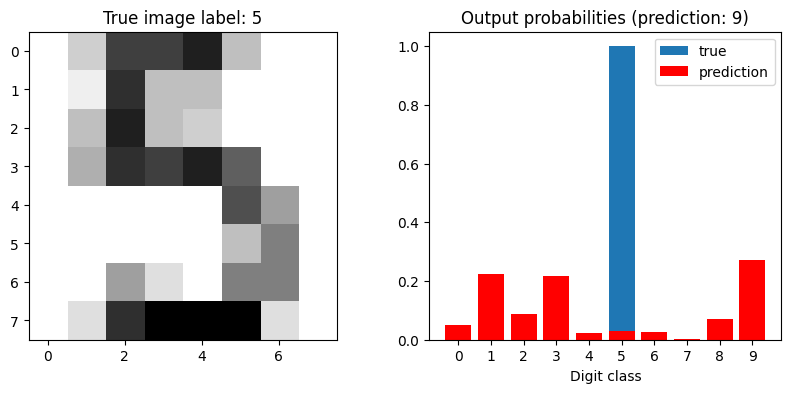

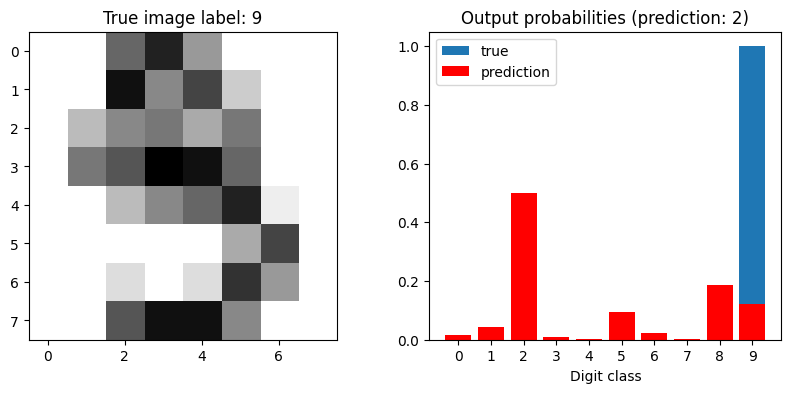

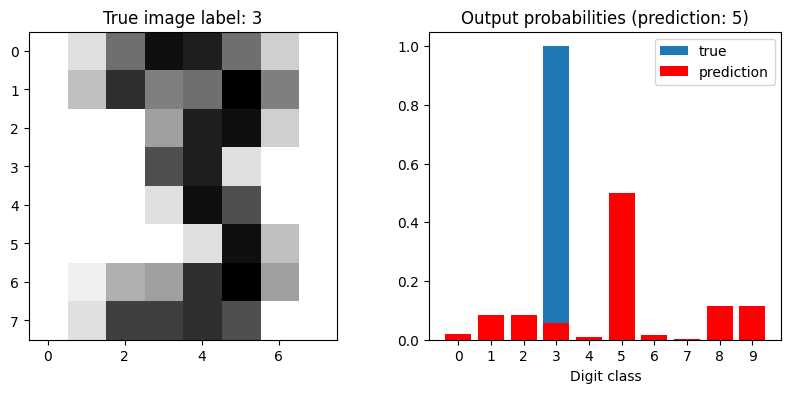

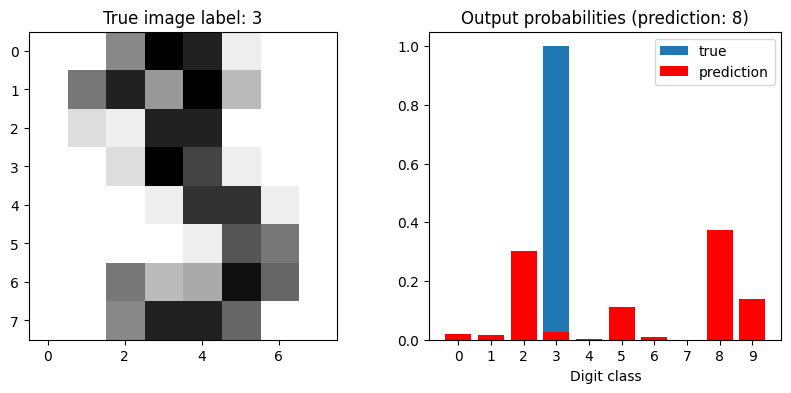

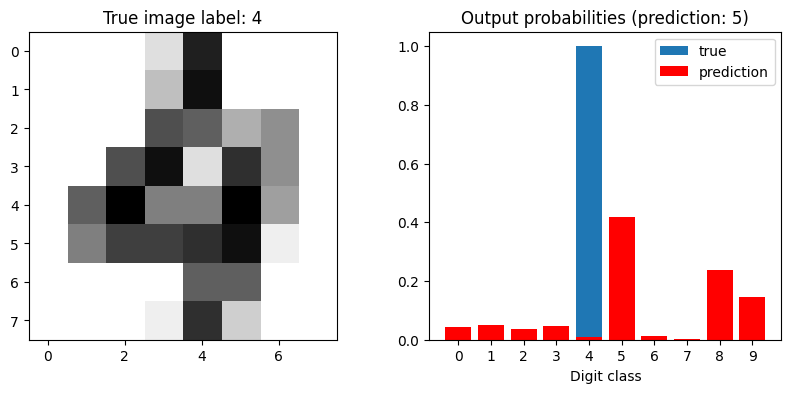

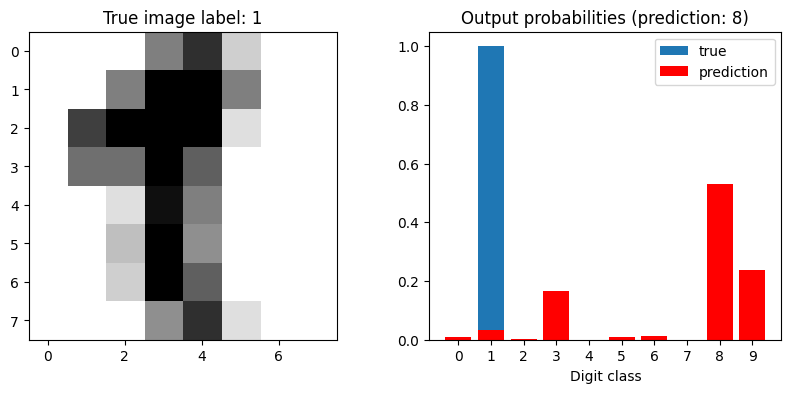

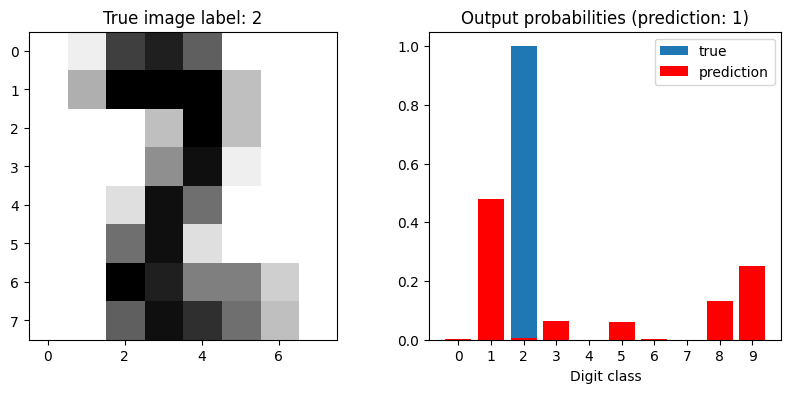

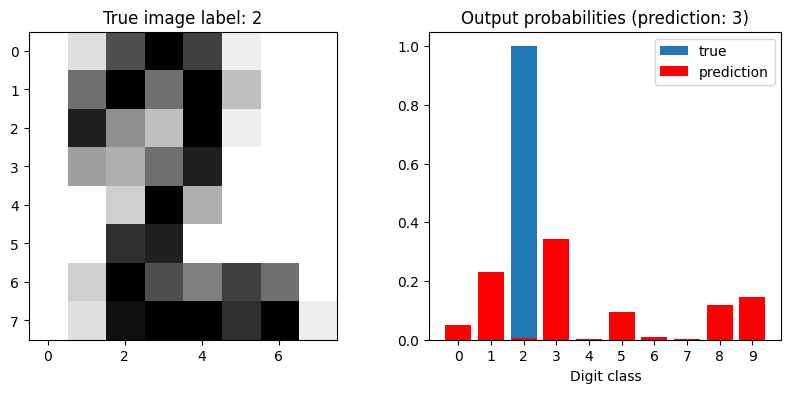

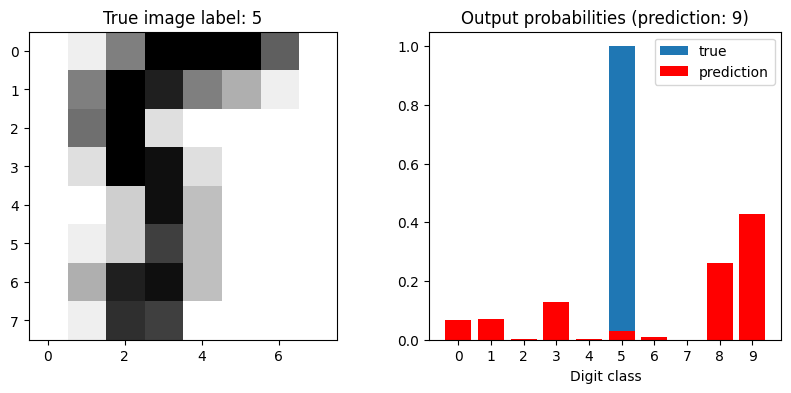

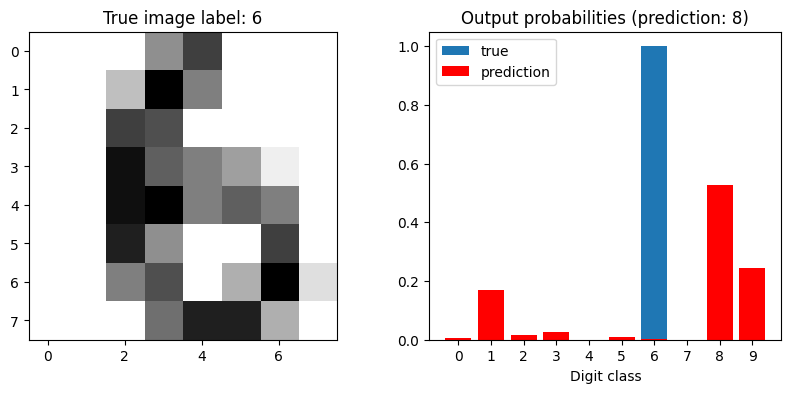

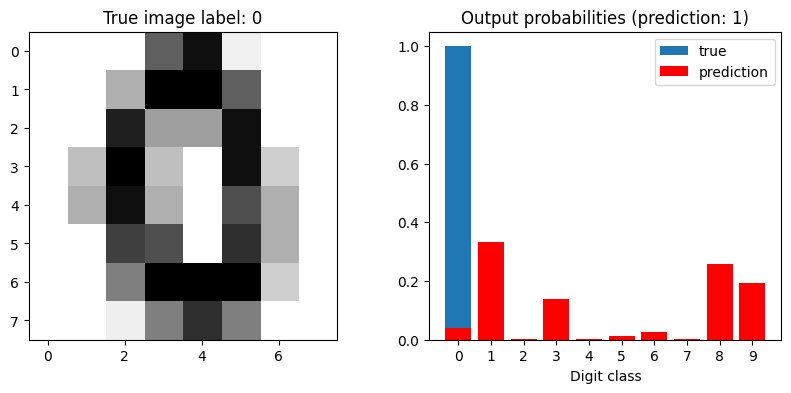

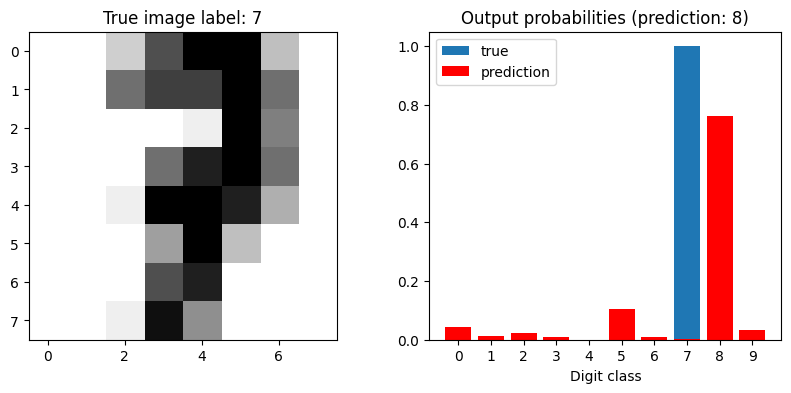

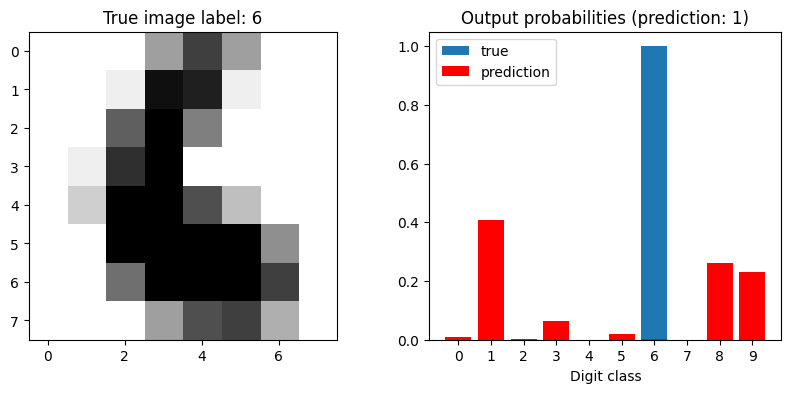

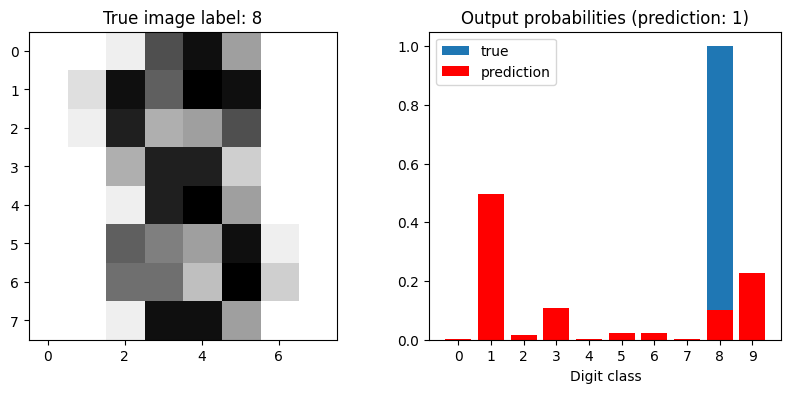

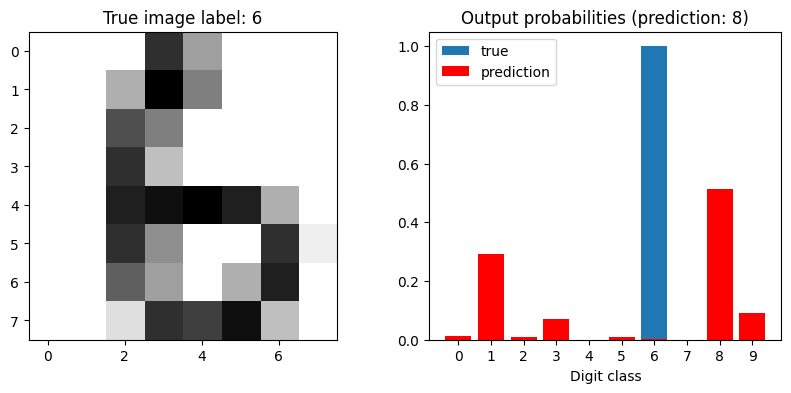

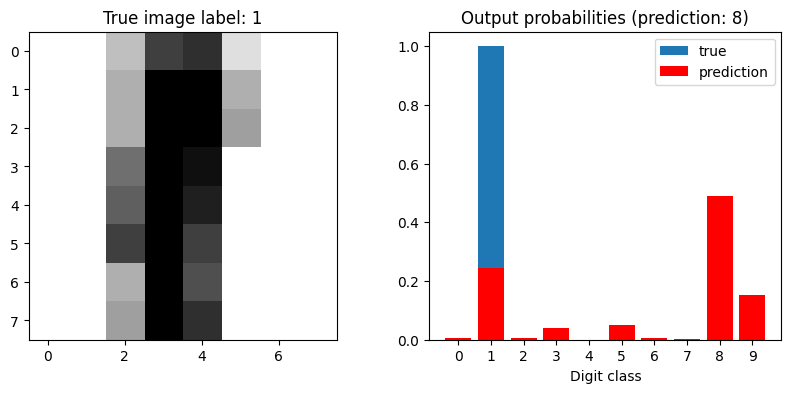

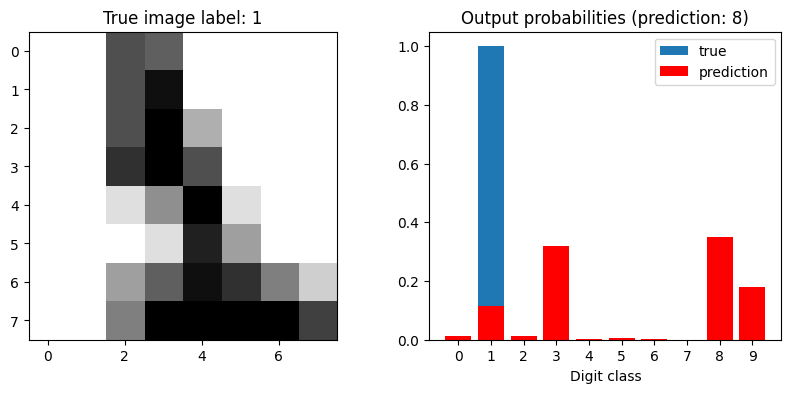

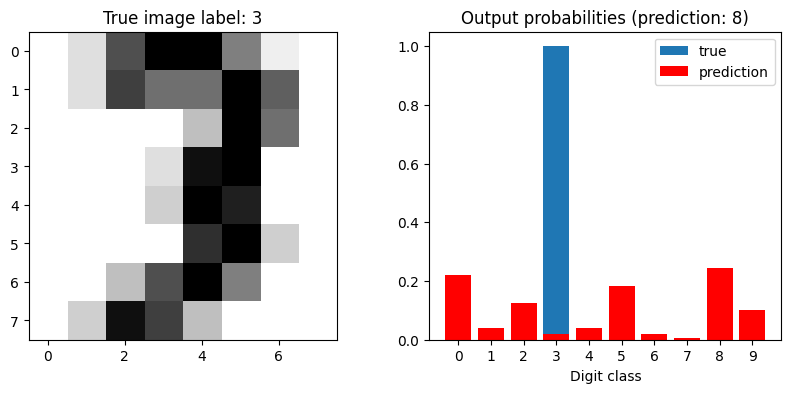

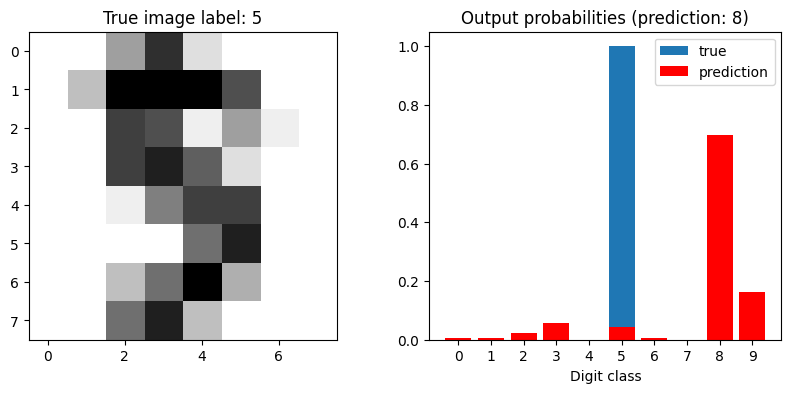

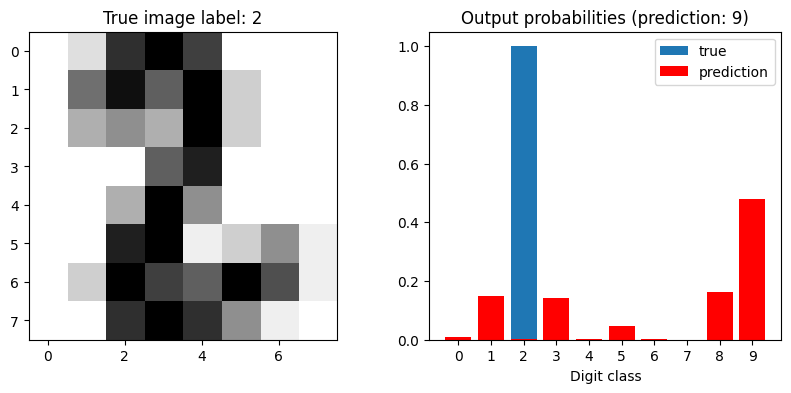

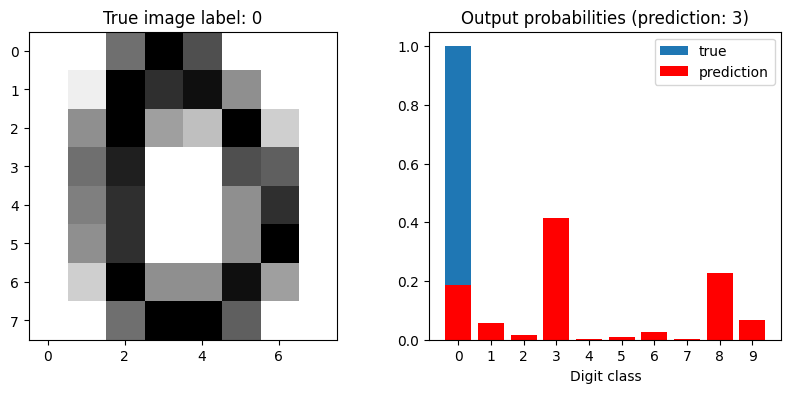

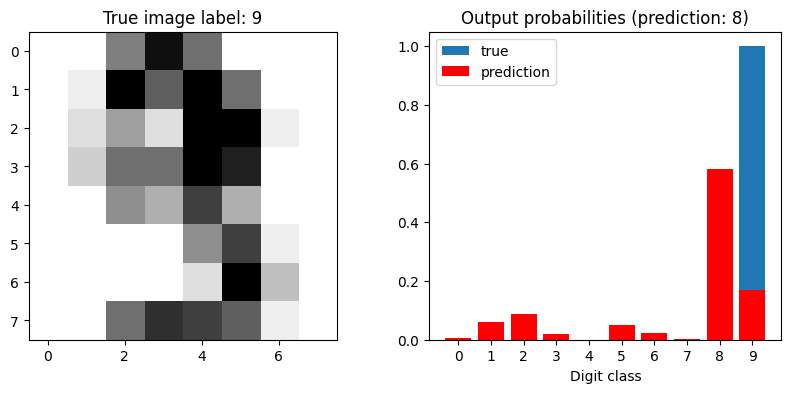

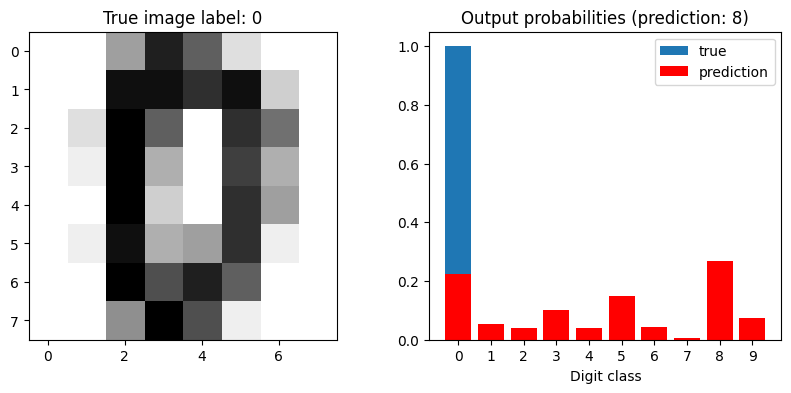

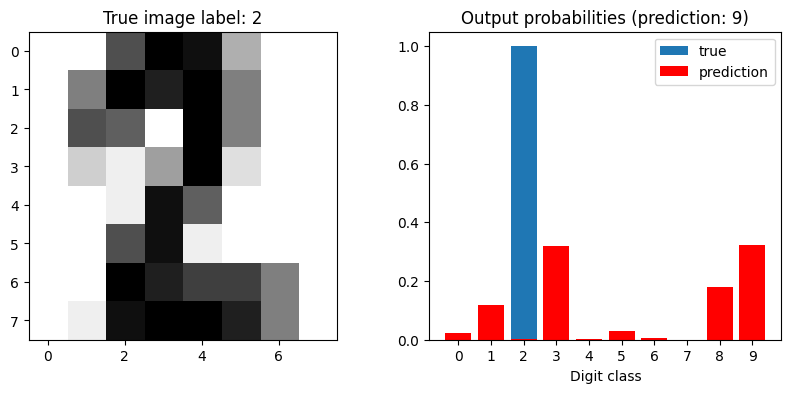

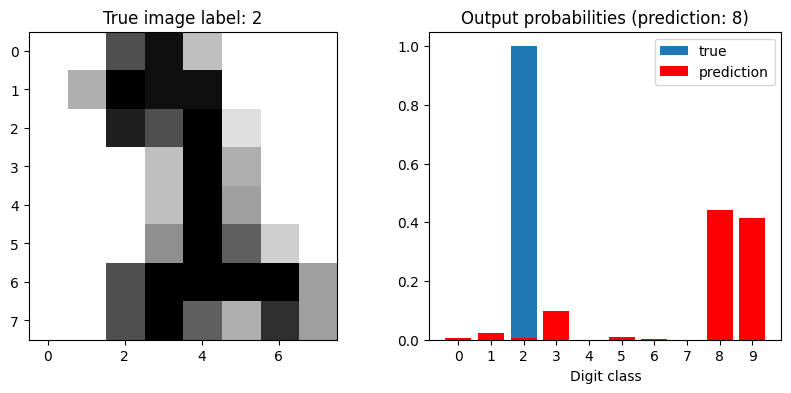

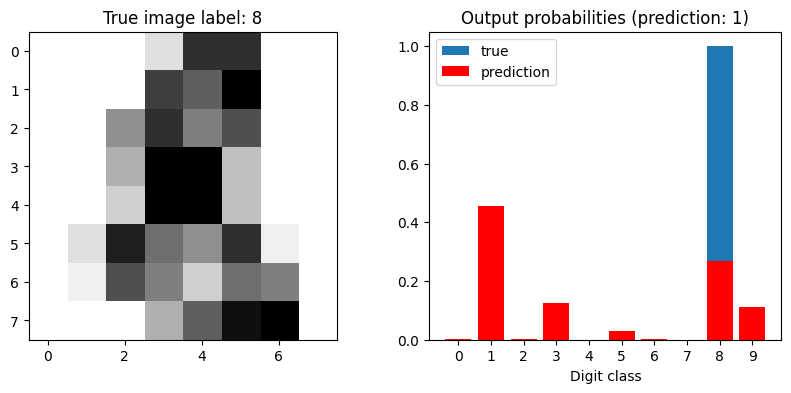

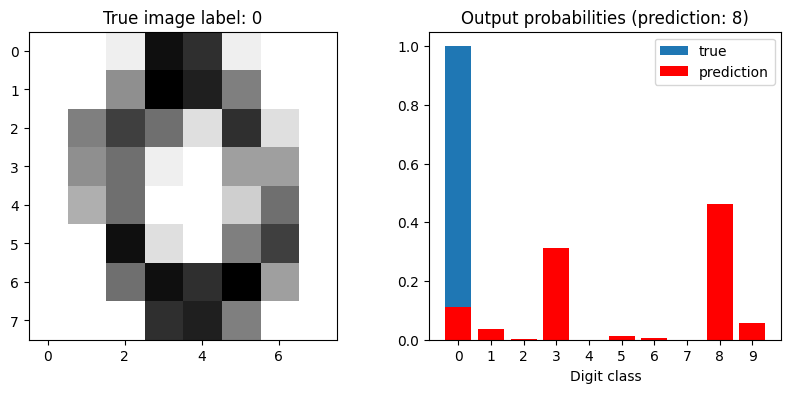

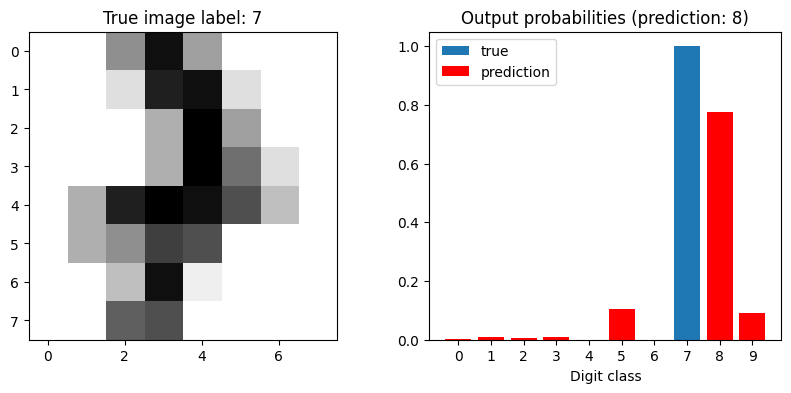

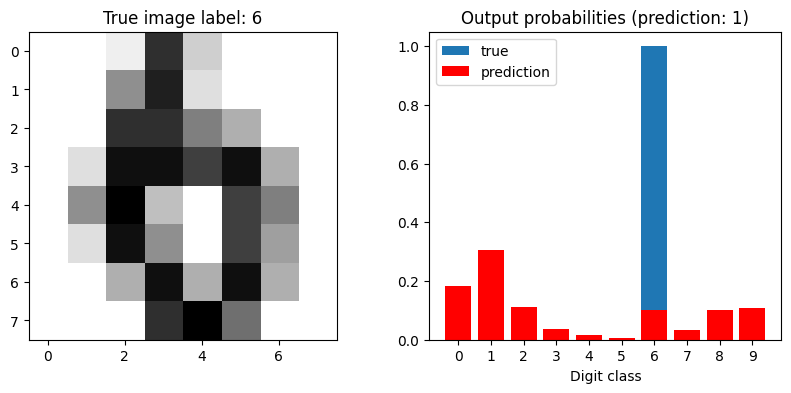

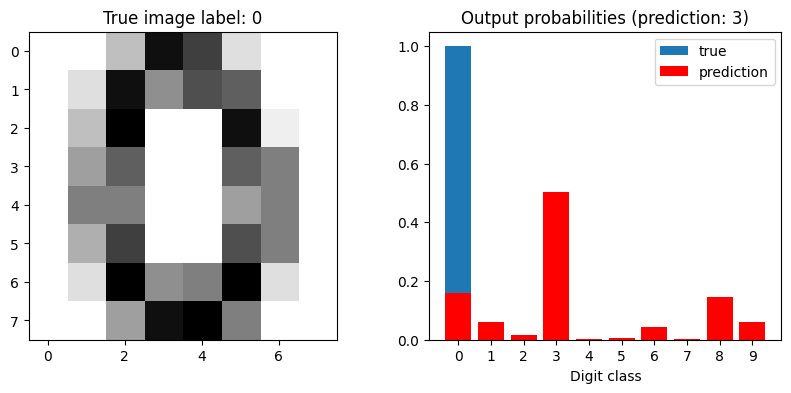

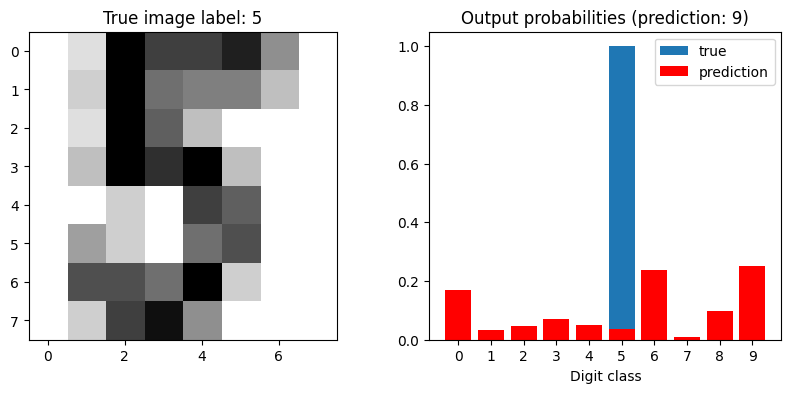

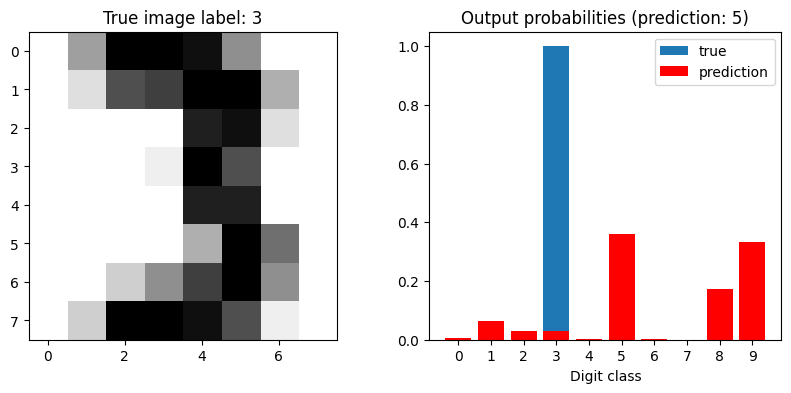

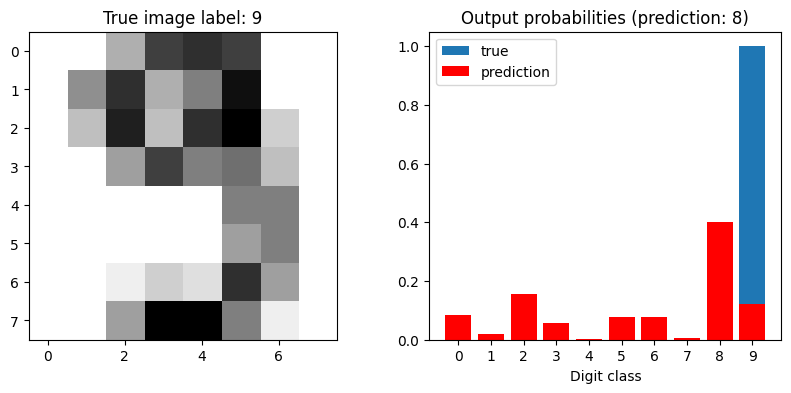

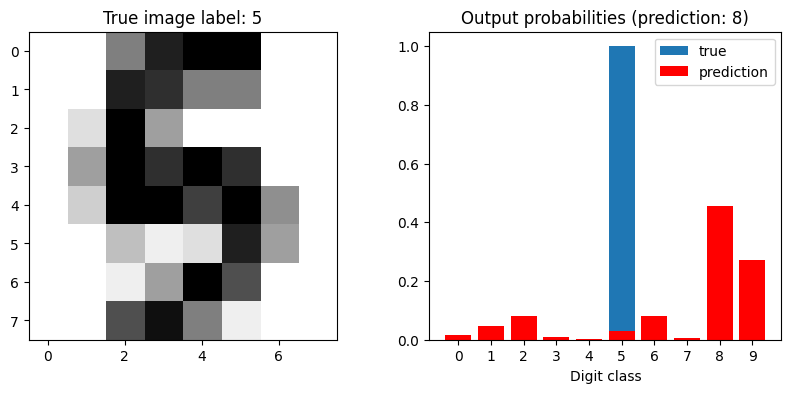

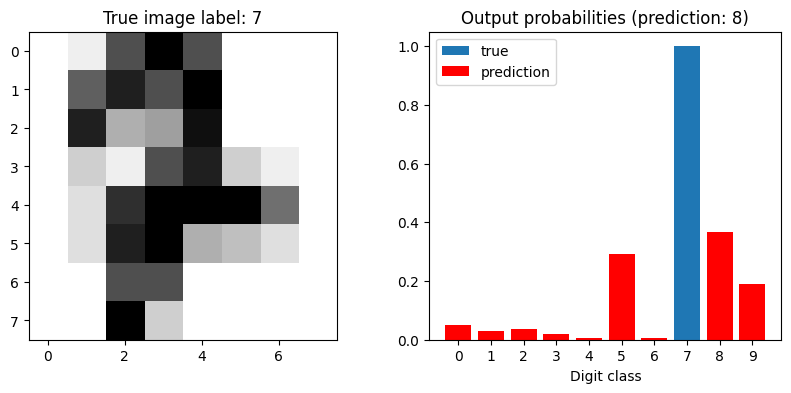

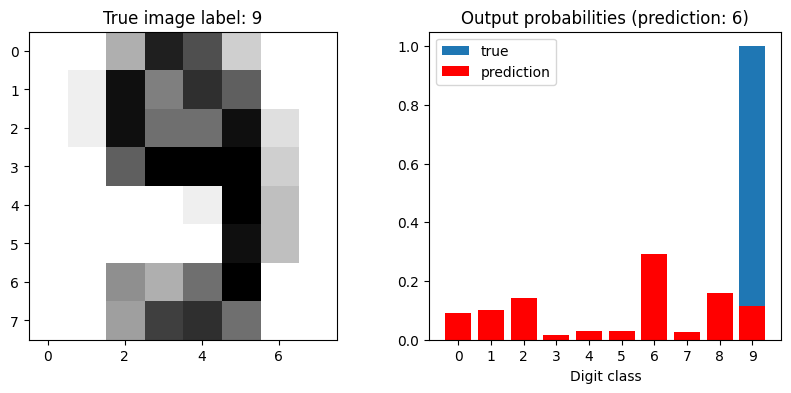

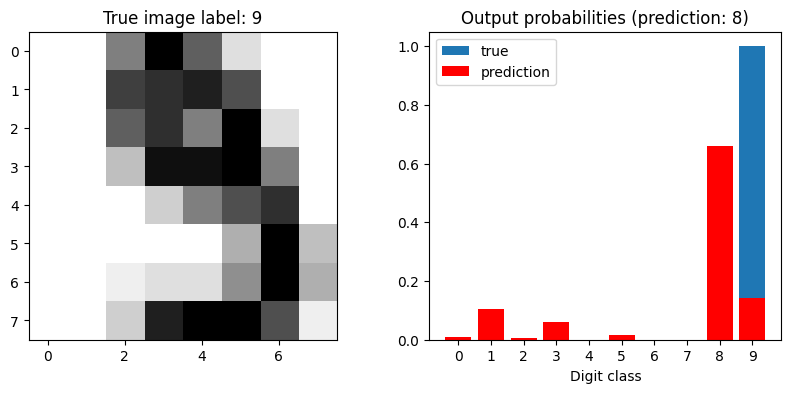

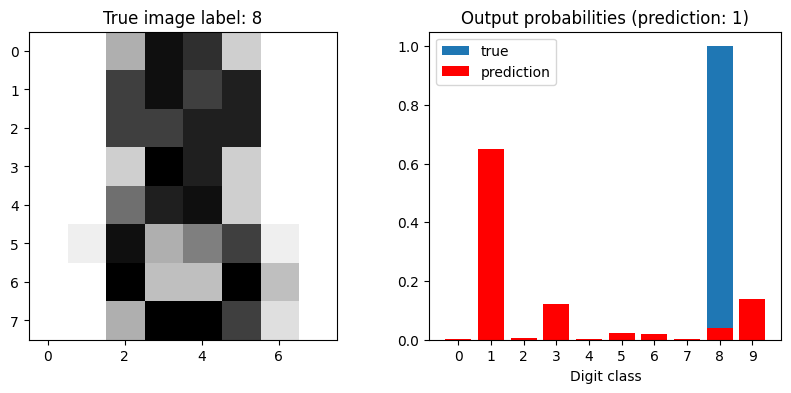

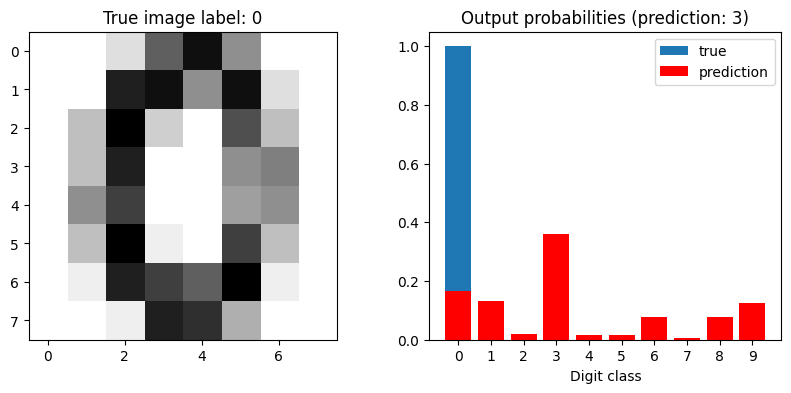

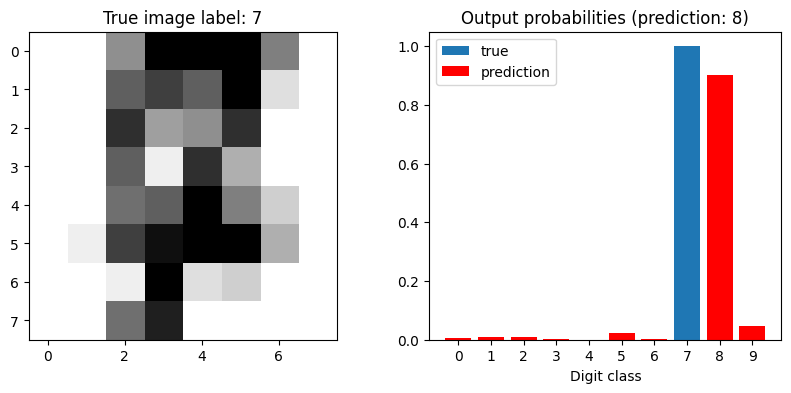

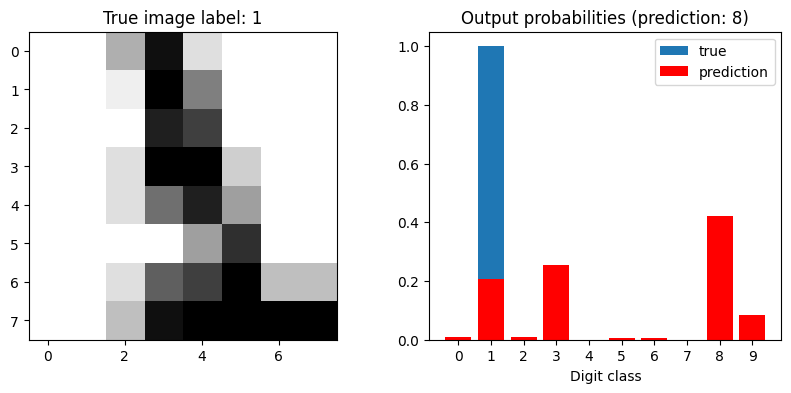

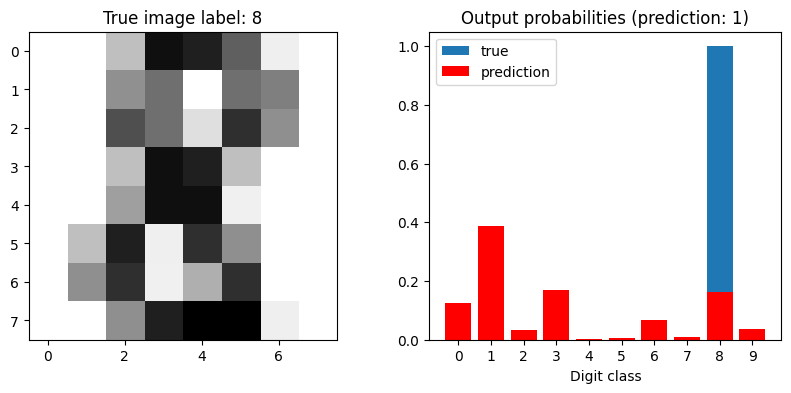

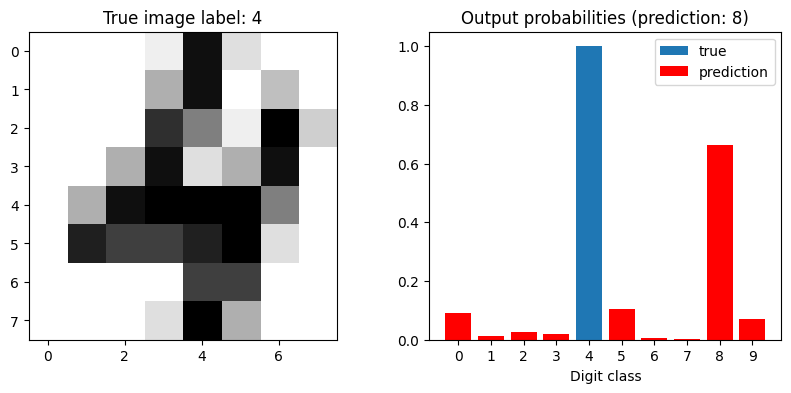

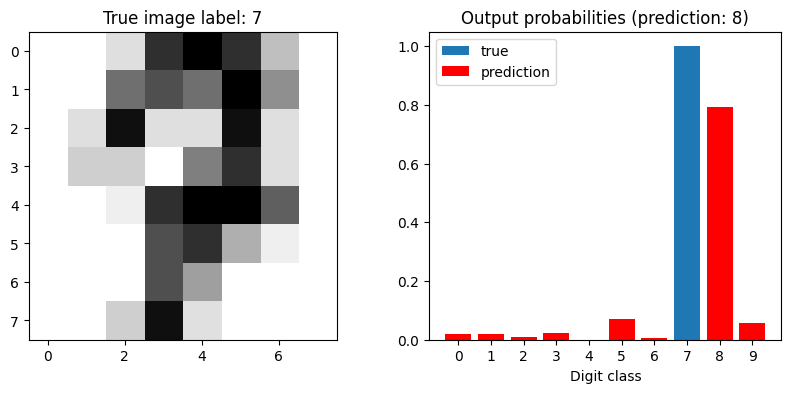

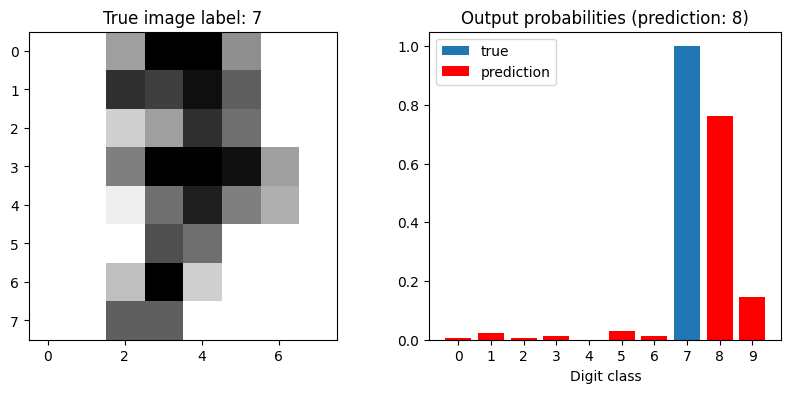

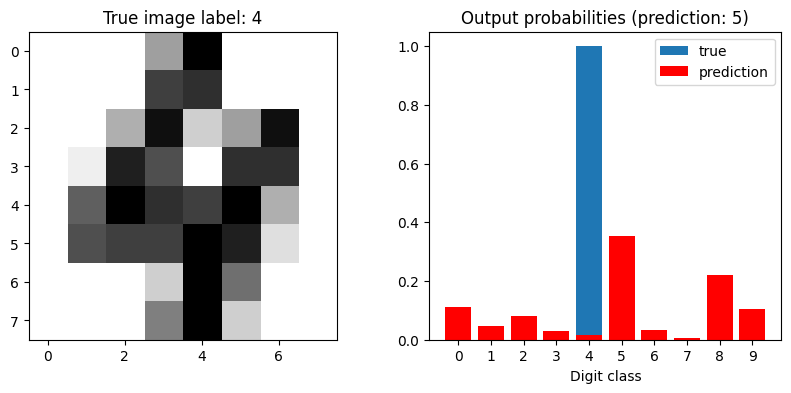

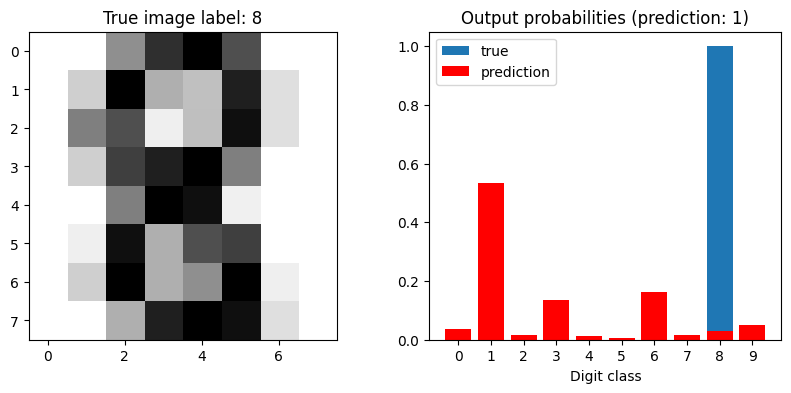

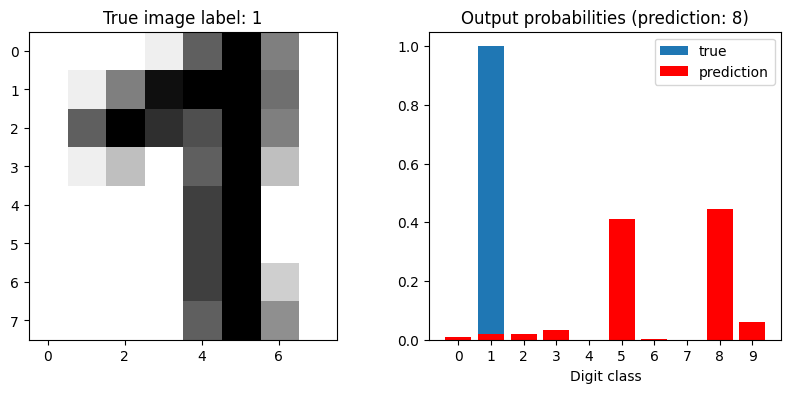

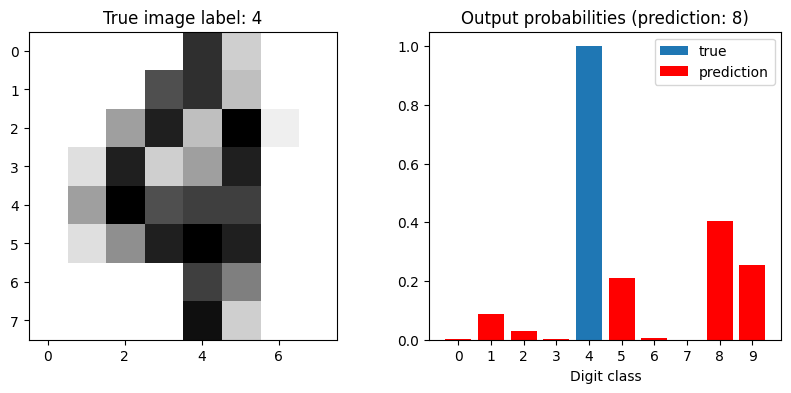

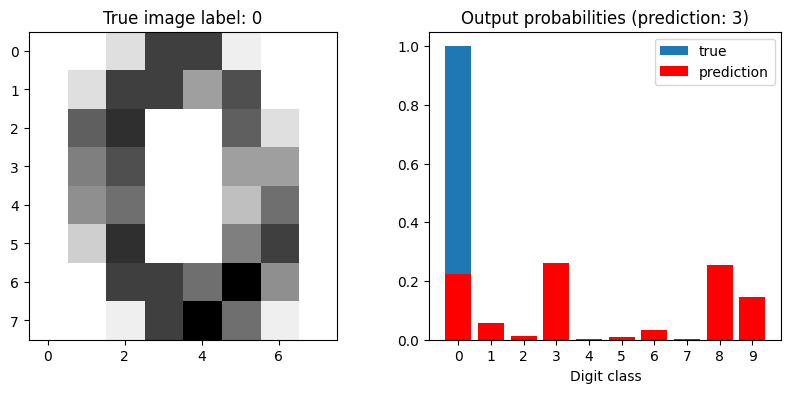

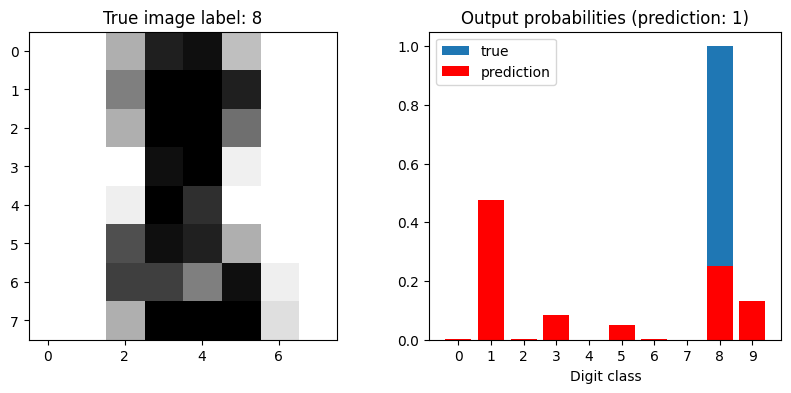

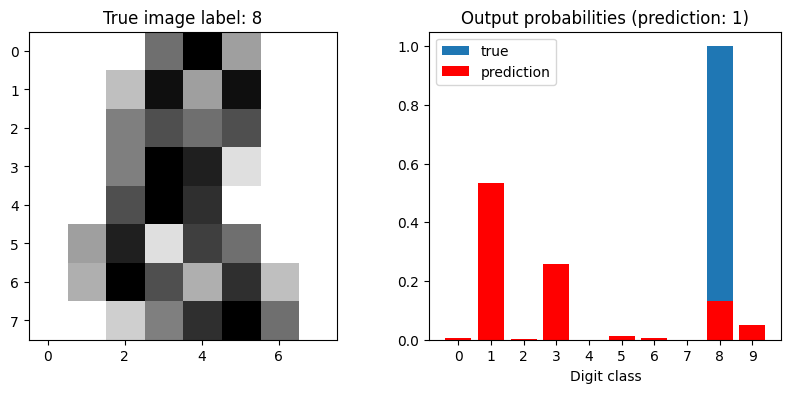

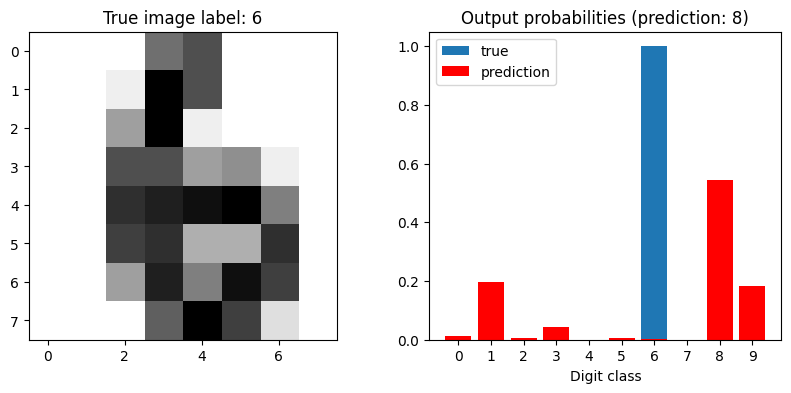

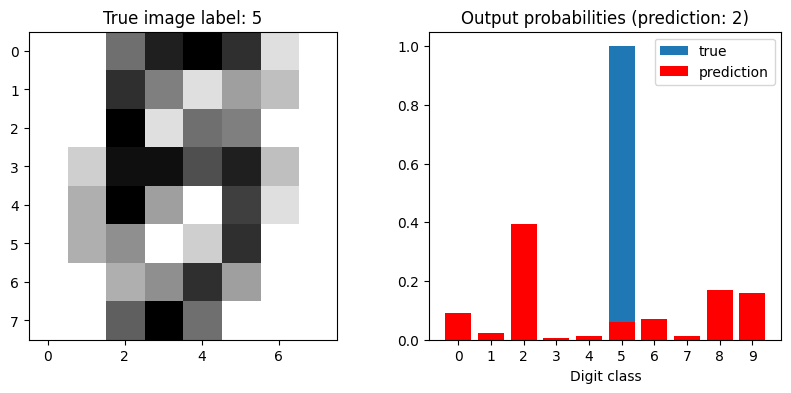

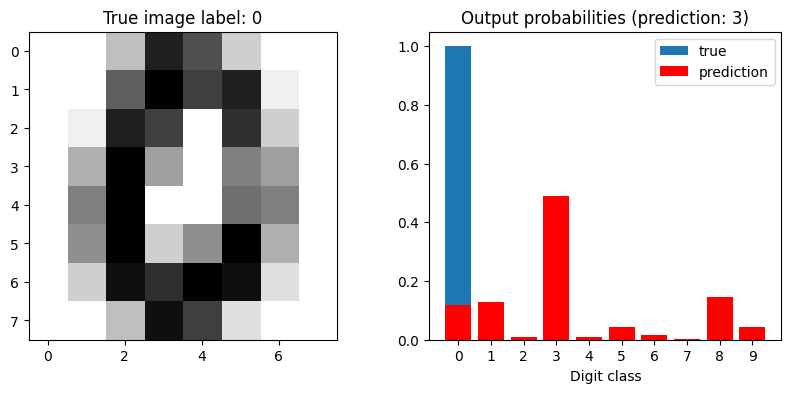

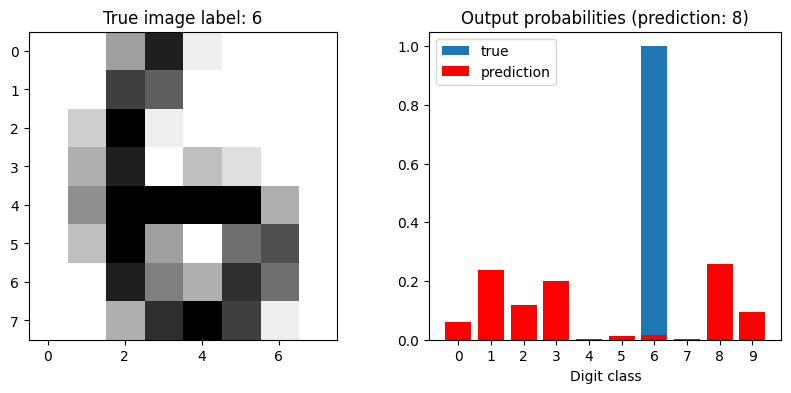

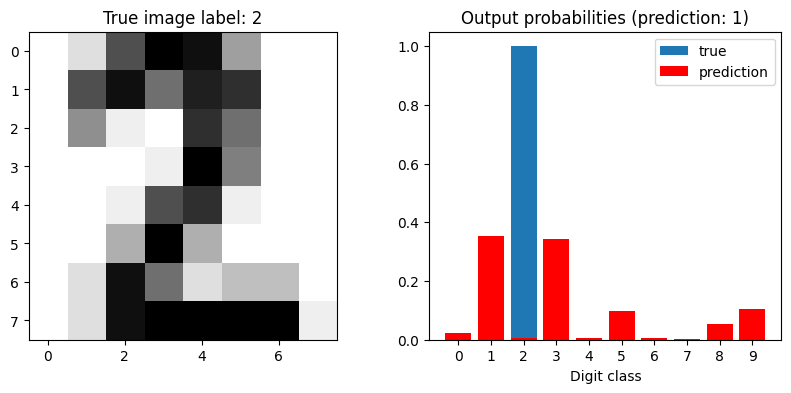

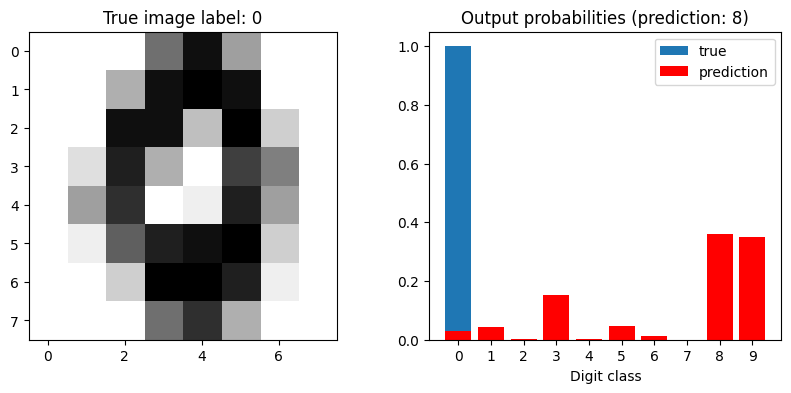

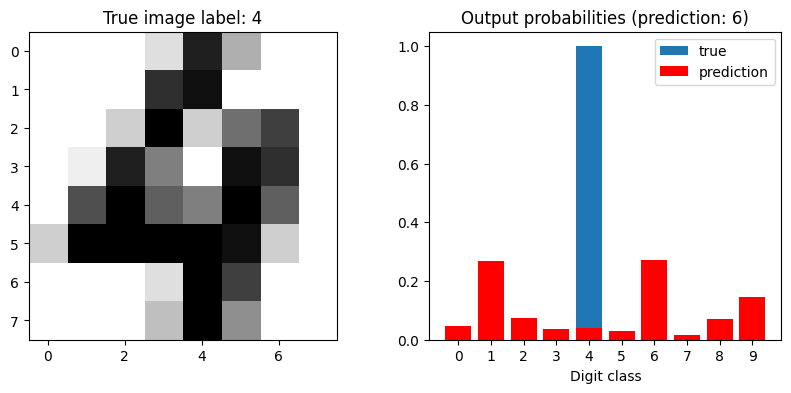

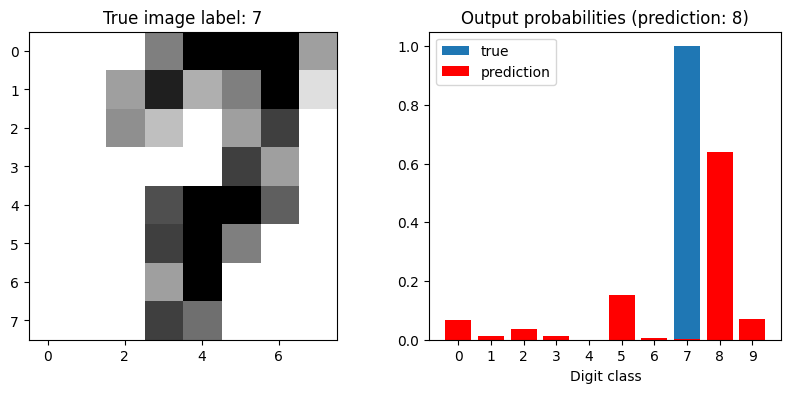

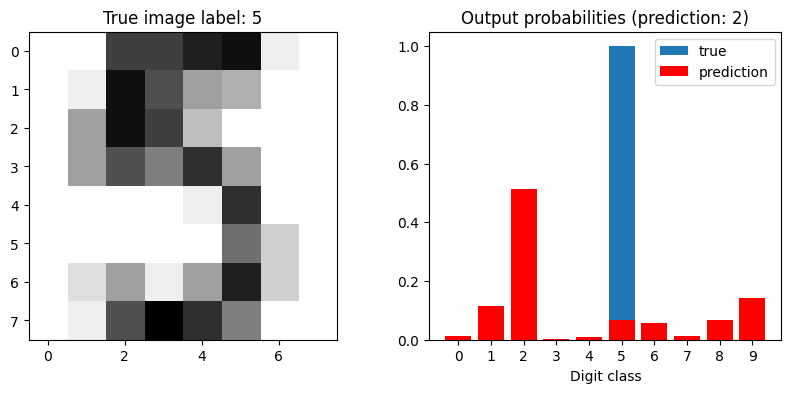

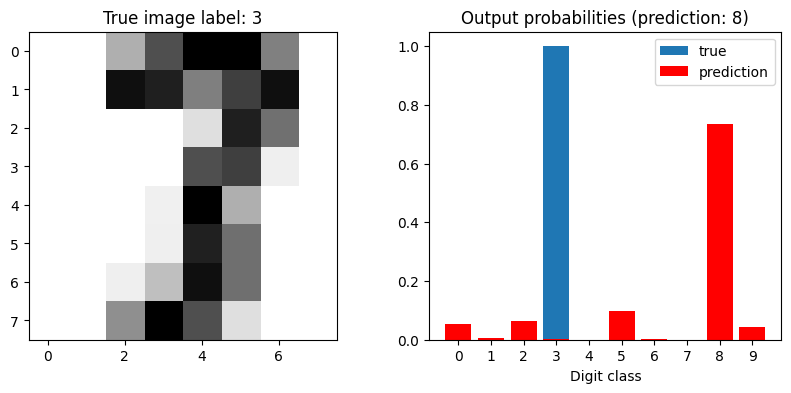

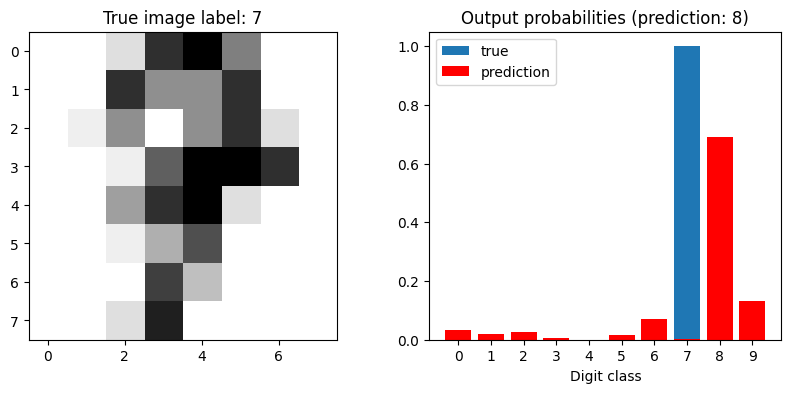

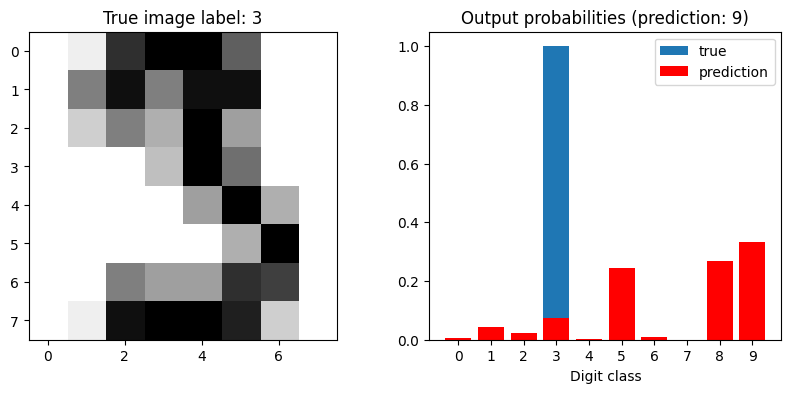

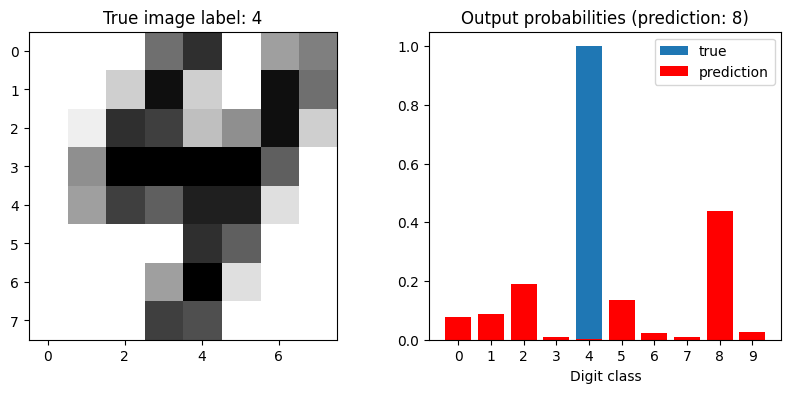

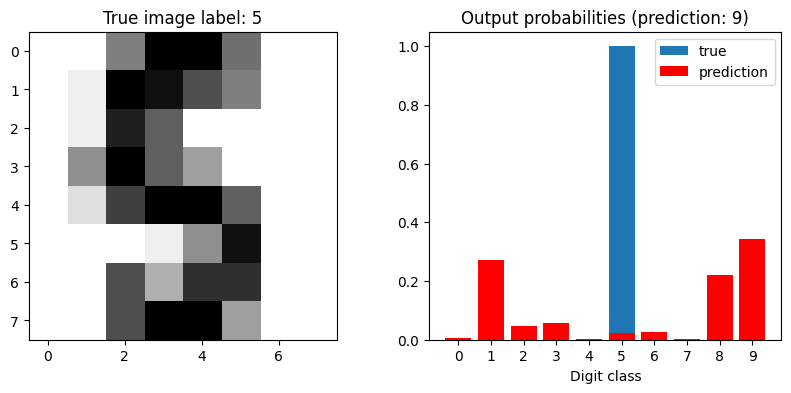

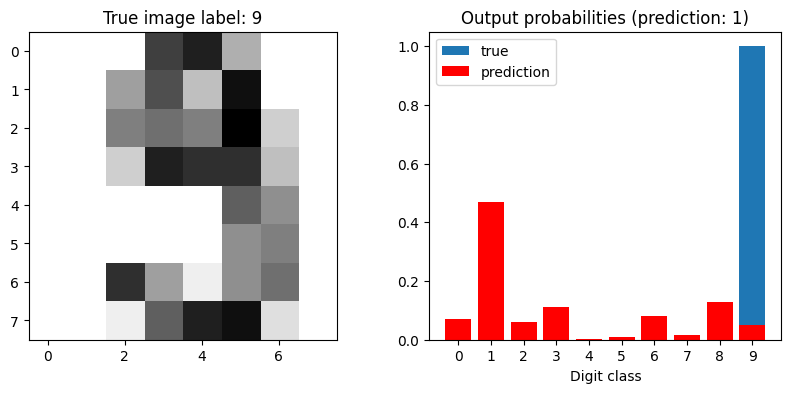

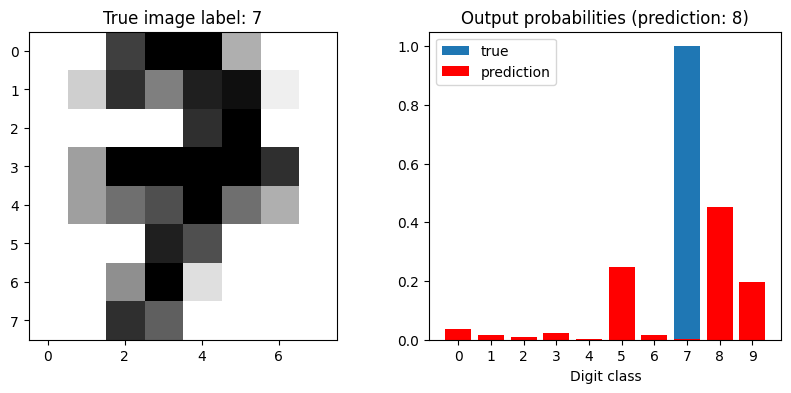

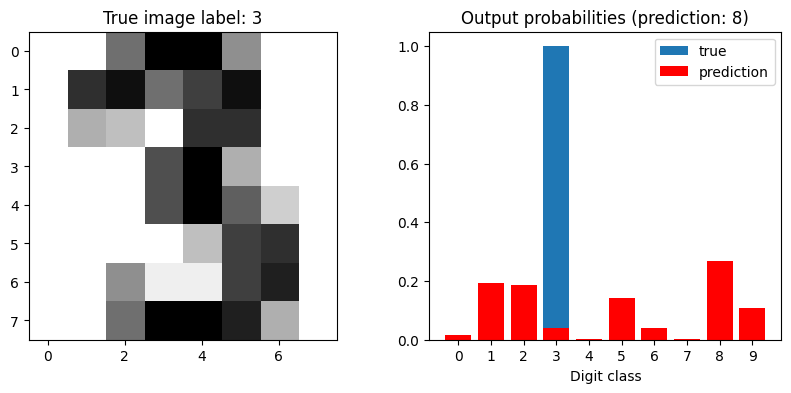

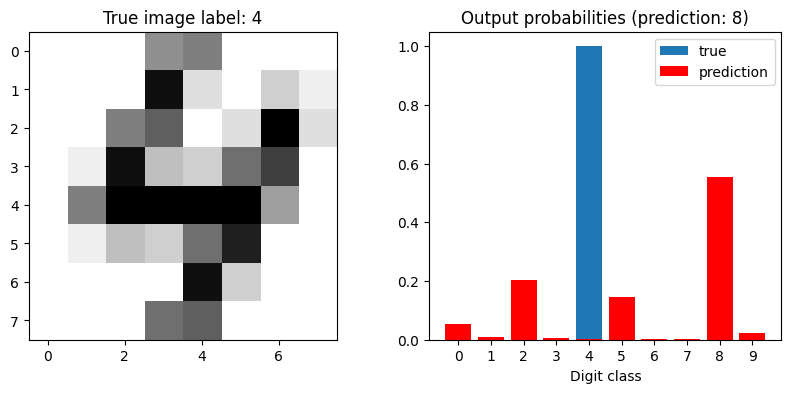

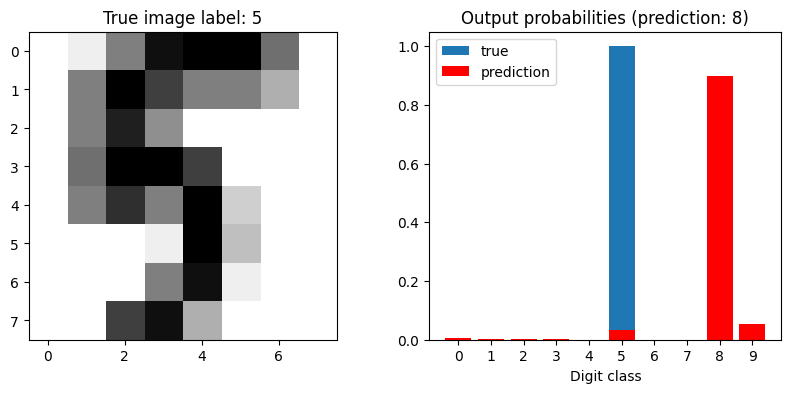

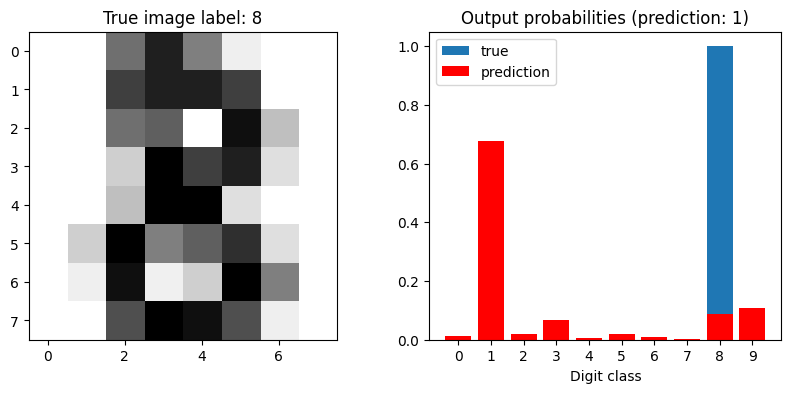

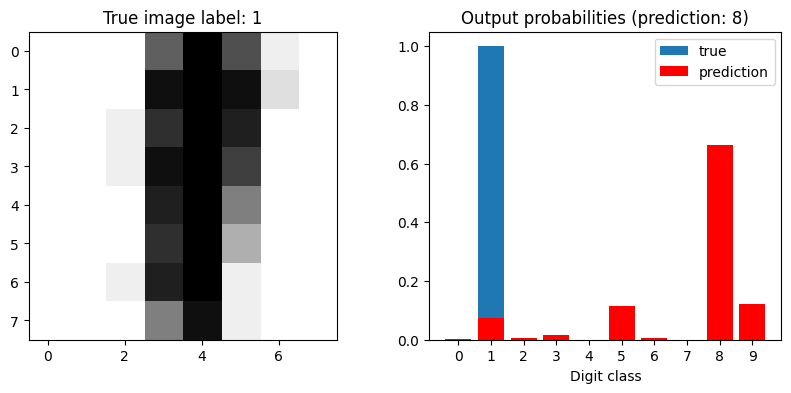

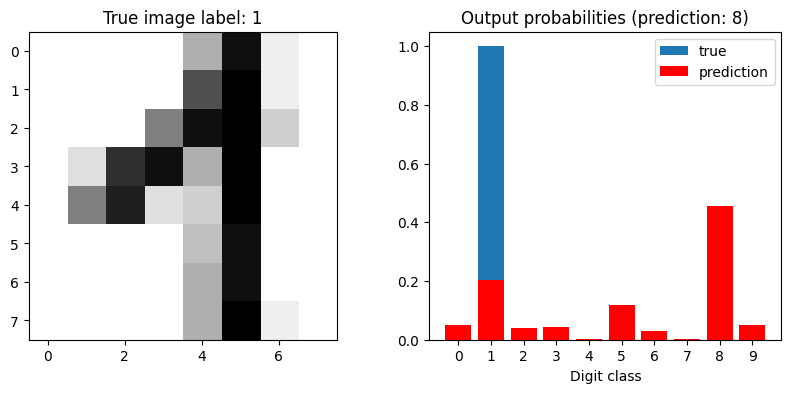

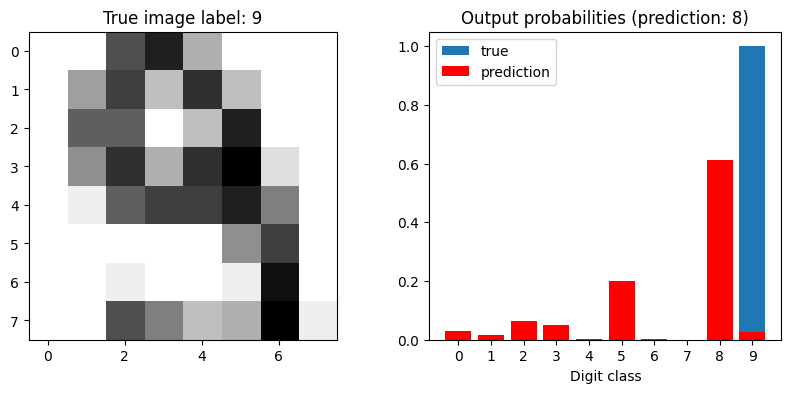

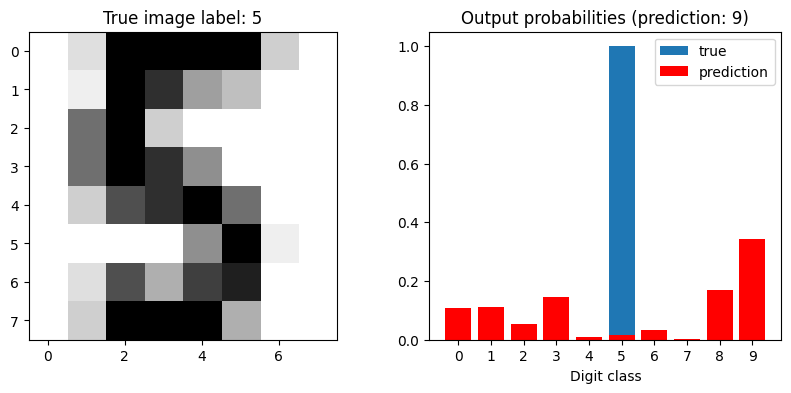

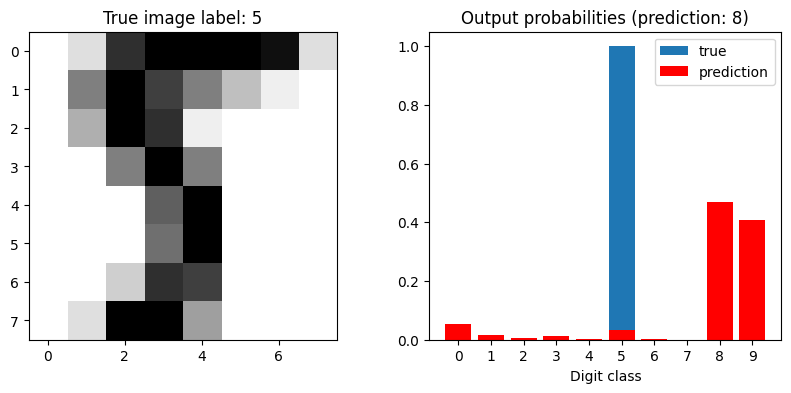

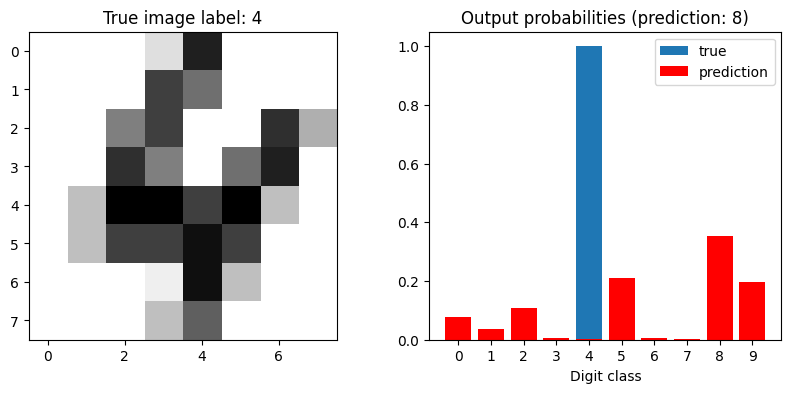

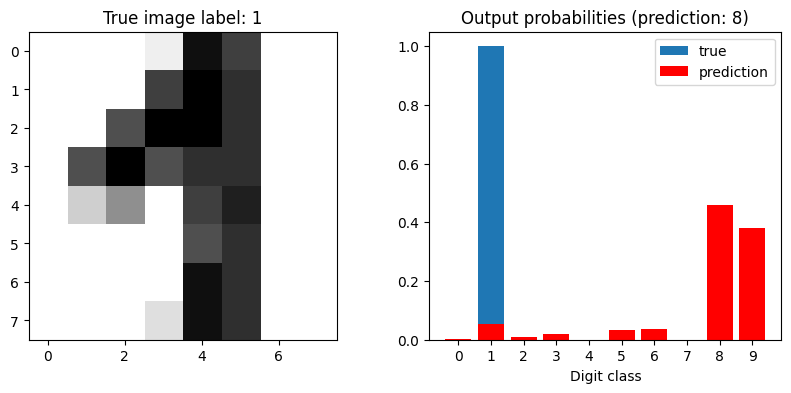

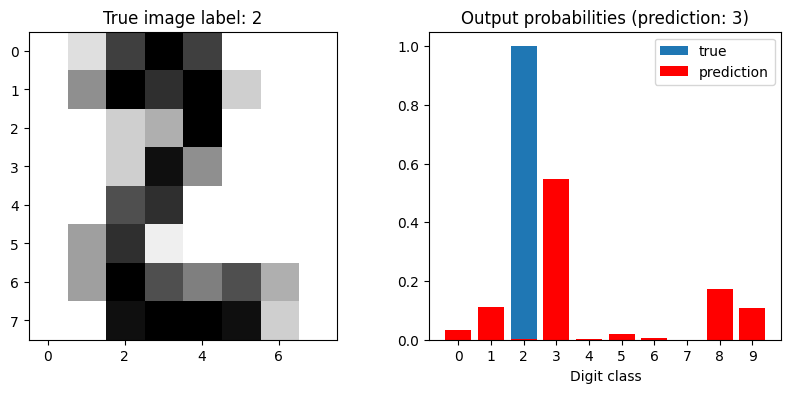

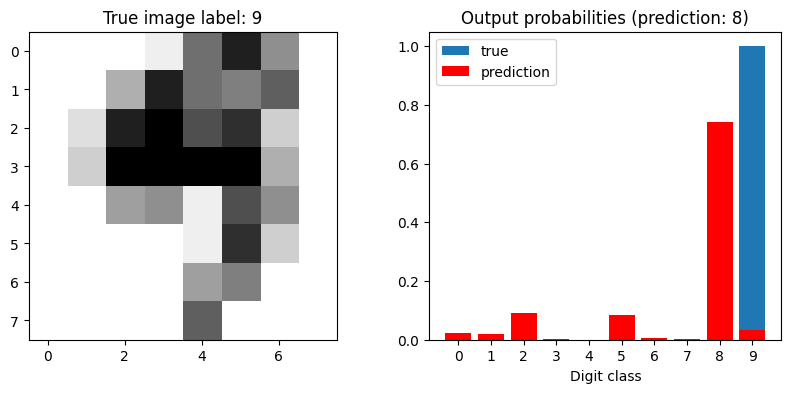

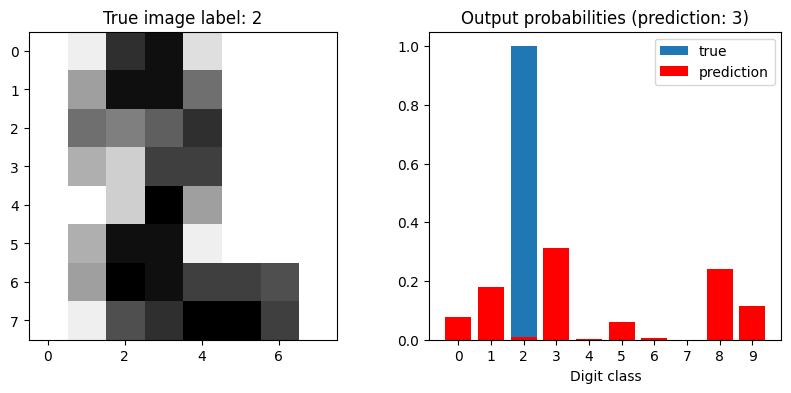

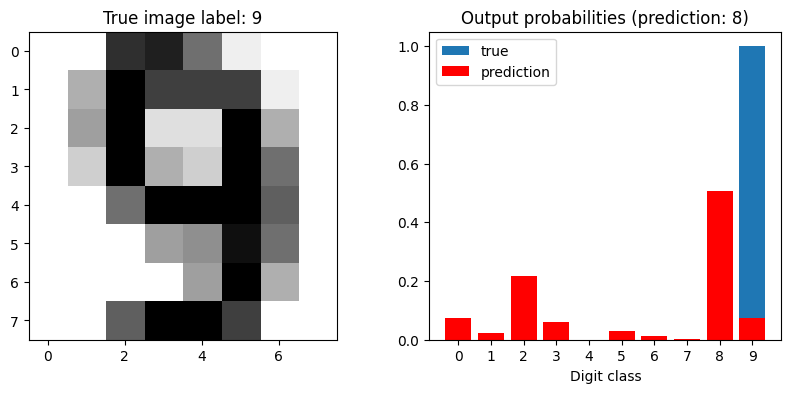

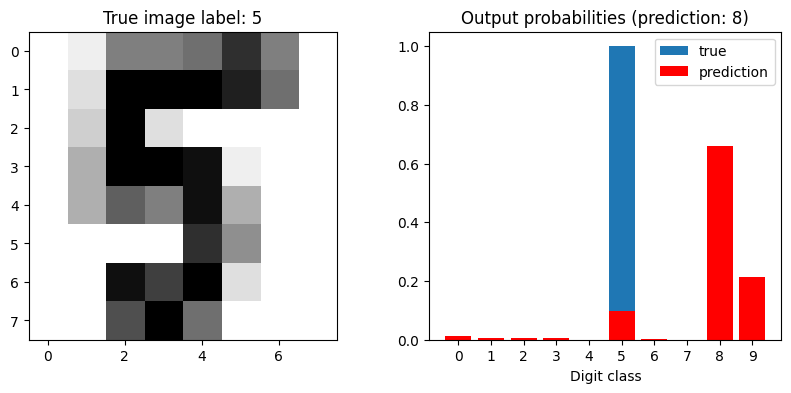

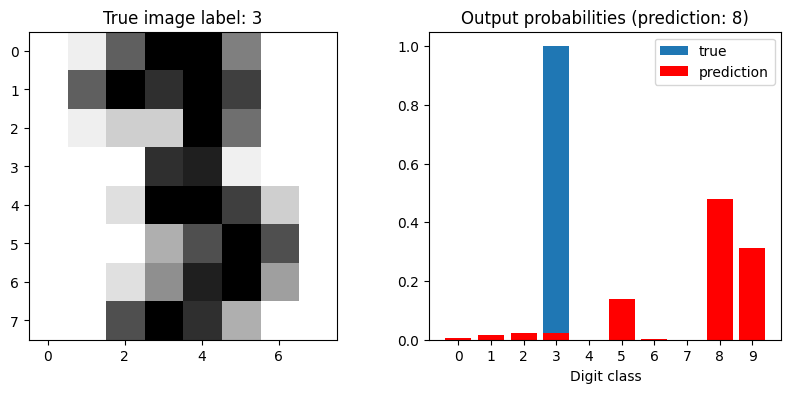

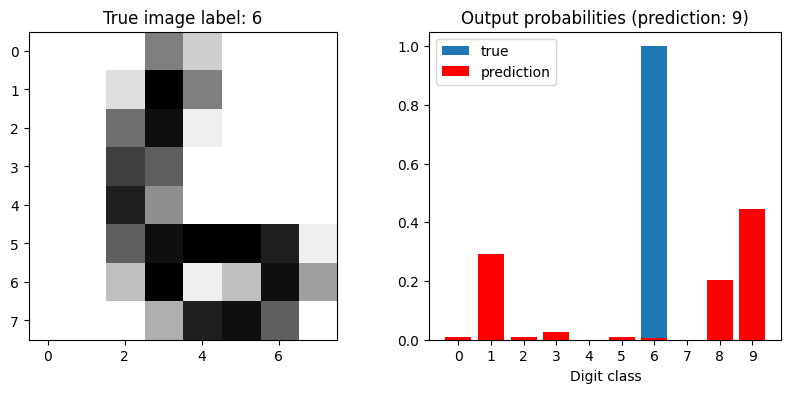

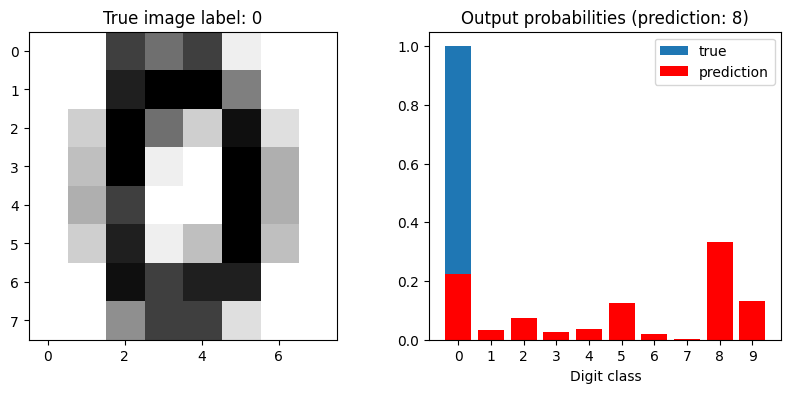

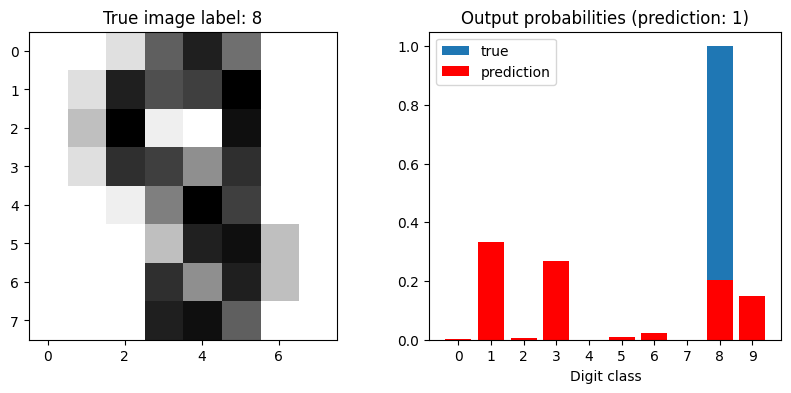

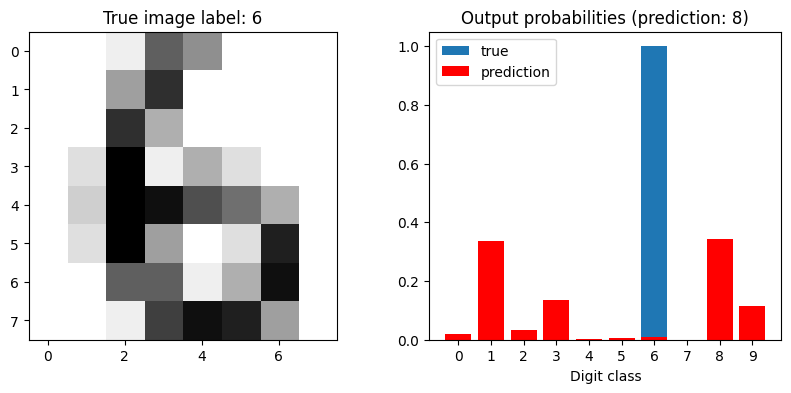

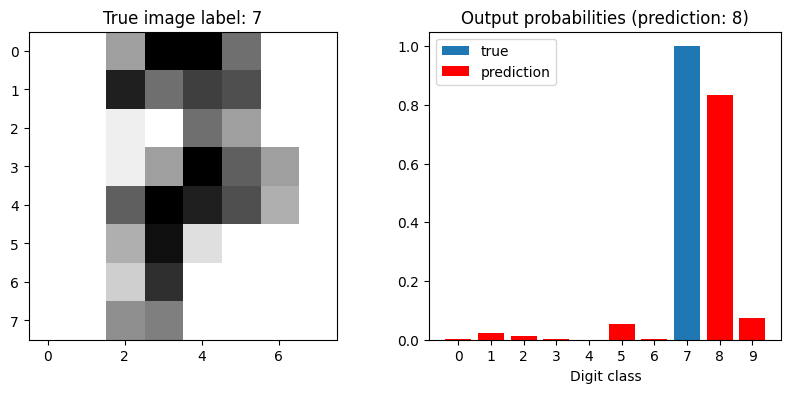

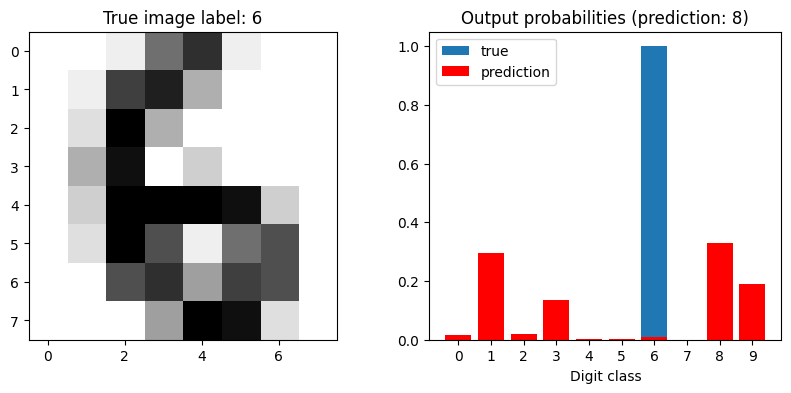

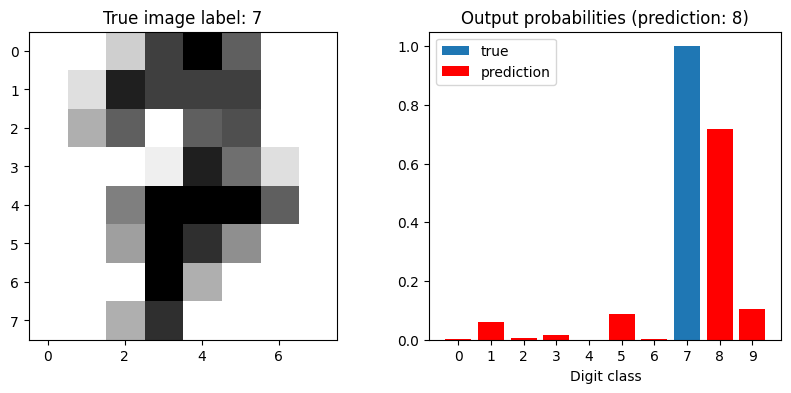

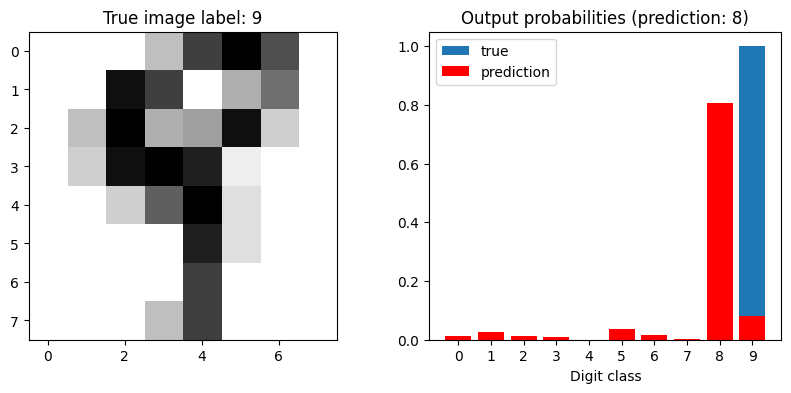

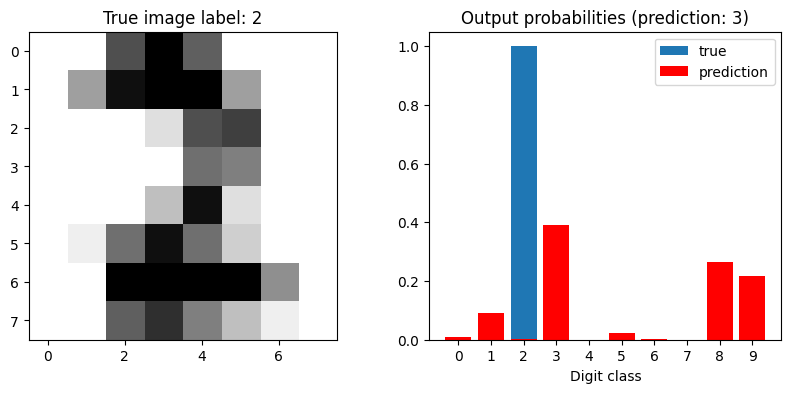

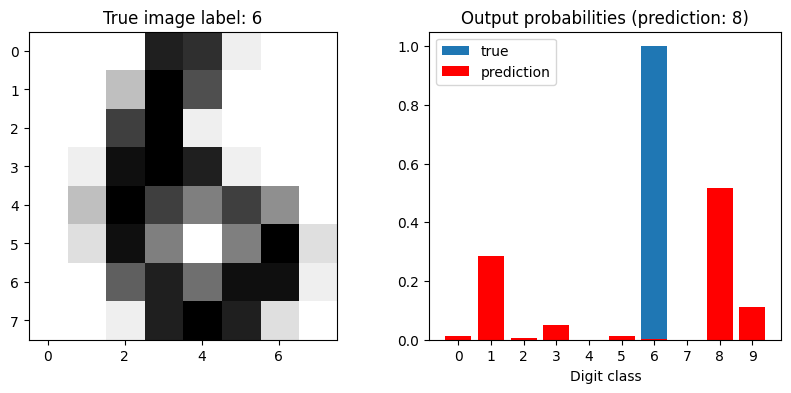

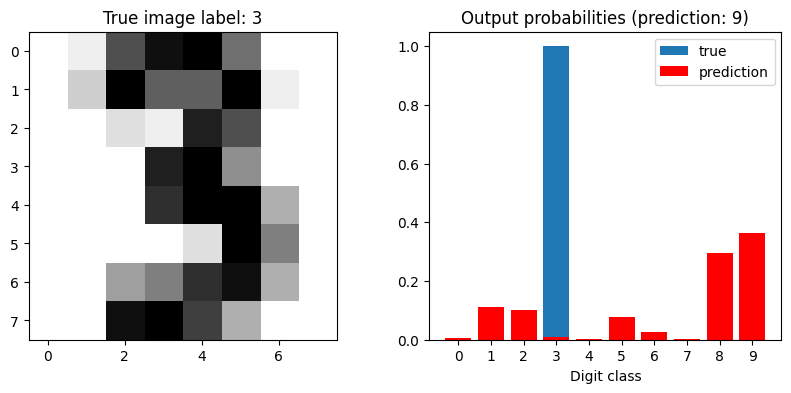

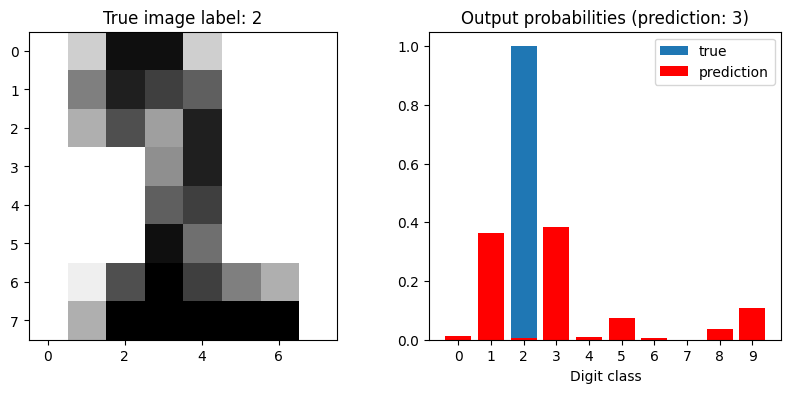

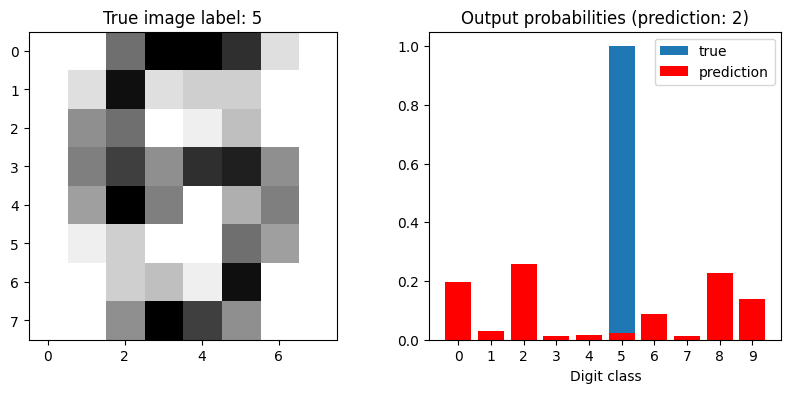

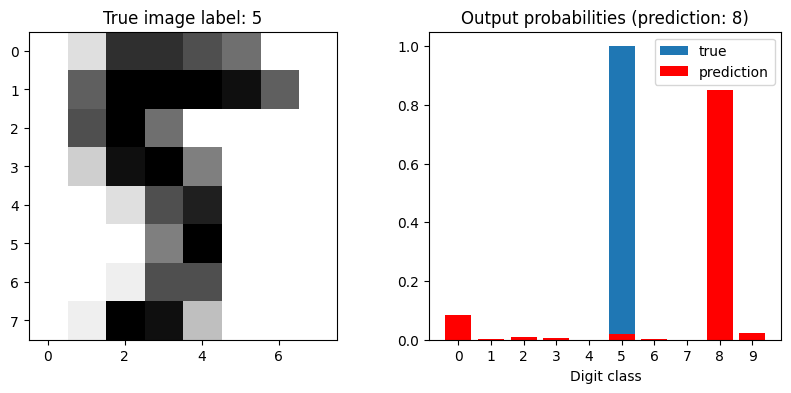

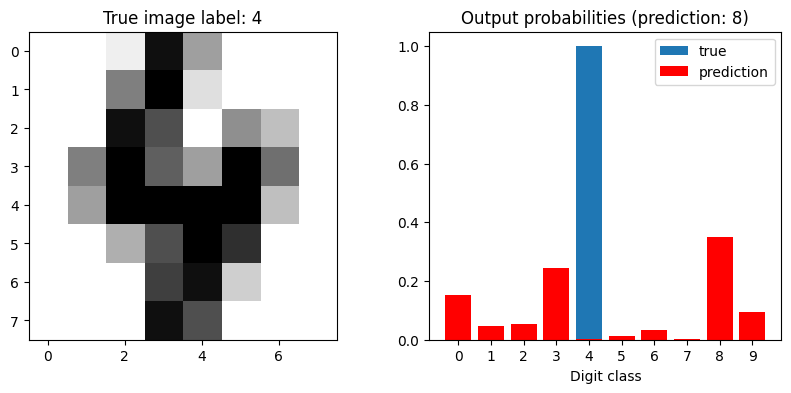

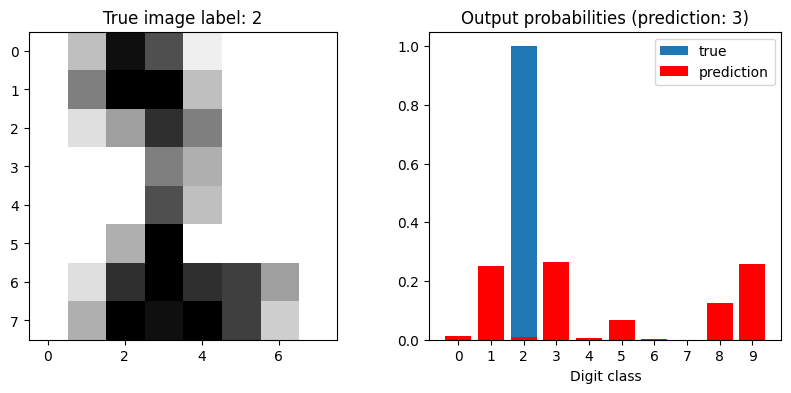

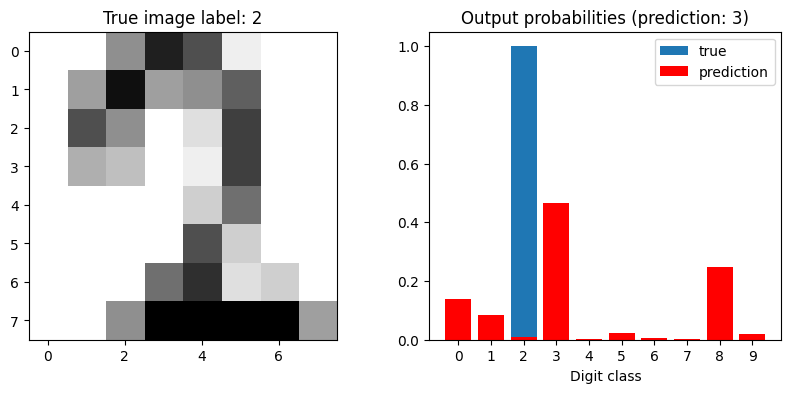

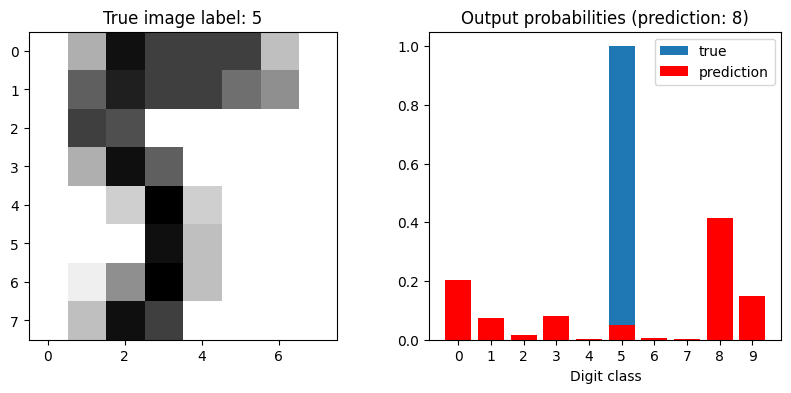

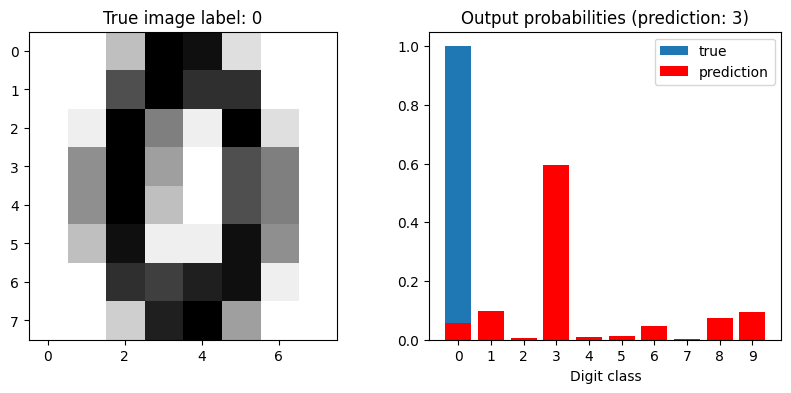

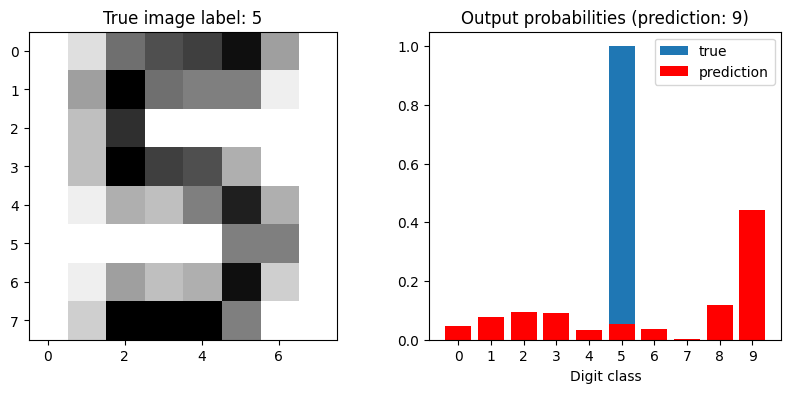

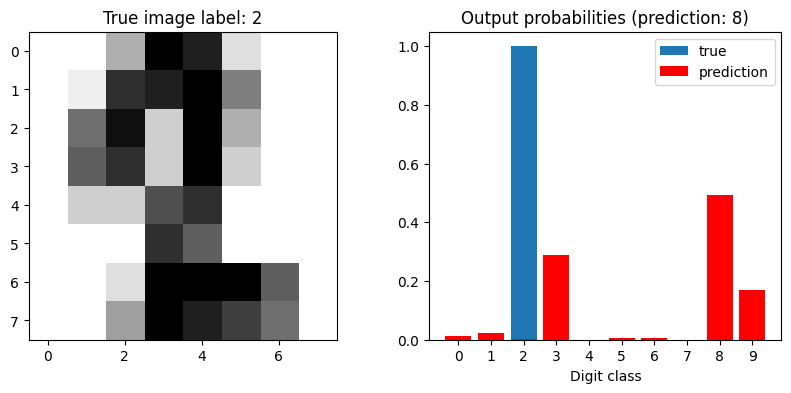

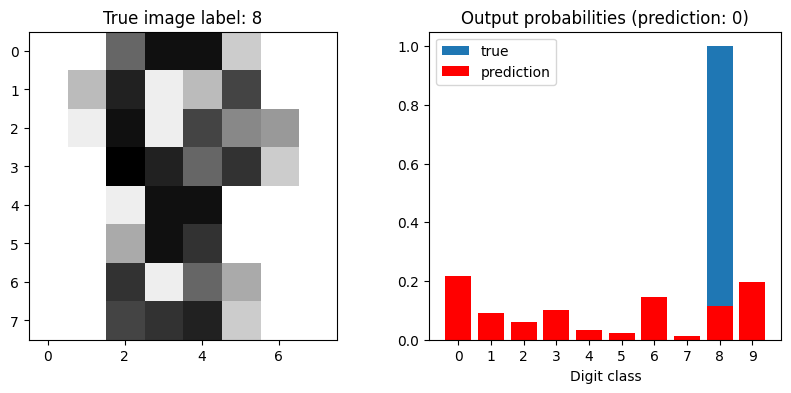

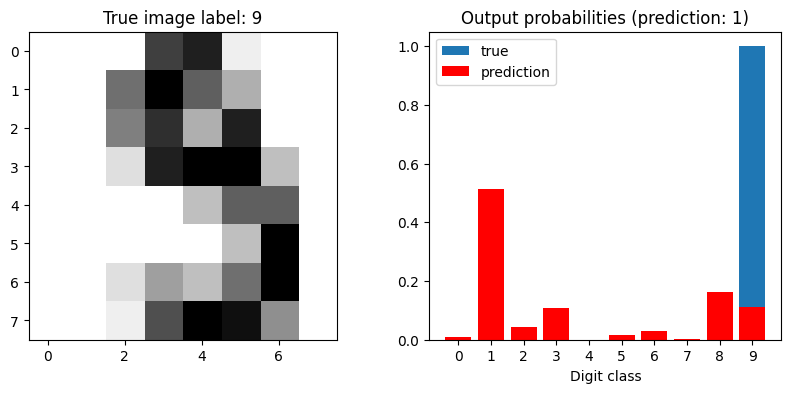

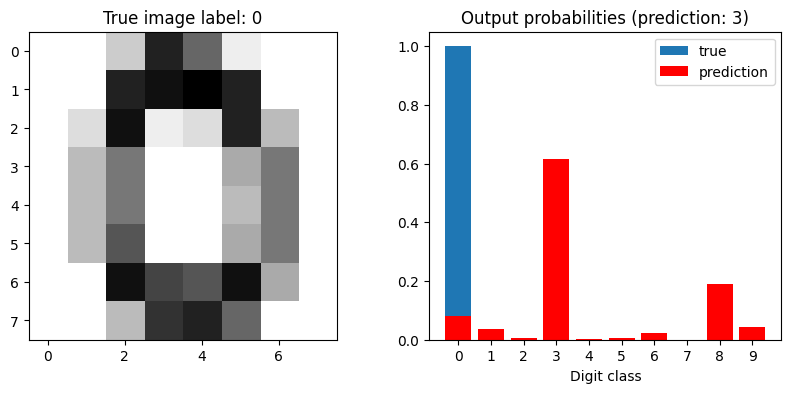

In [42]:
for idx in worst_predictions_indices[0]:
  plot_prediction(model, idx)

Suggestions to do better.

To better the results I can first, increase the number of epochs.
If I am not satisfied, I can change the learning rate too. Increasing the number of hidden layers and neurons can also improve the predictions.

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum


### Back to Keras

- Implement the same network architecture with Keras;

- Check that the Keras model can approximately reproduce the behavior of the Numpy model when using similar hyperparameter values (size of the model, type of activations, learning rate value and use of momentum);

- Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`);

- Compute the average negative log-likelihood on the full test set.

- Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).

Hyperparameters settings

- Learning rate

In [48]:
def train_and_plot(model, learning_rate):
  losses, accuracies, accuracies_test = [], [], []
  losses.append(model.loss(X_train, y_train))
  accuracies.append(model.accuracy(X_train, y_train))
  accuracies_test.append(model.accuracy(X_test, y_test))

  print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
        % (losses[-1], accuracies[-1], accuracies_test[-1]))

  for epoch in range(15):
      for i, (x, y) in enumerate(zip(X_train, y_train)):
          model.train(x, y, learning_rate)

      losses.append(model.loss(X_train, y_train))
      accuracies.append(model.accuracy(X_train, y_train))
      accuracies_test.append(model.accuracy(X_test, y_test))
      print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
            % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
  plt.plot(losses)
  plt.title("Training loss");
  plt.show()
  plt.plot(accuracies, label='train')
  plt.plot(accuracies_test, label='test')
  plt.ylim(0, 1.1)
  plt.ylabel("accuracy")
  plt.legend(loc='best');

Random init: train loss: 6208.32246, train acc: 0.060, test acc: 0.081
Epoch #1, train loss: 616.34463, train acc: 0.866, test acc: 0.833
Epoch #2, train loss: 627.72034, train acc: 0.878, test acc: 0.837
Epoch #3, train loss: 694.02317, train acc: 0.867, test acc: 0.863
Epoch #4, train loss: 480.50313, train acc: 0.921, test acc: 0.900
Epoch #5, train loss: 468.77090, train acc: 0.917, test acc: 0.889
Epoch #6, train loss: 343.49151, train acc: 0.930, test acc: 0.915
Epoch #7, train loss: 447.57501, train acc: 0.919, test acc: 0.904
Epoch #8, train loss: 389.96834, train acc: 0.928, test acc: 0.907
Epoch #9, train loss: 255.23433, train acc: 0.949, test acc: 0.926
Epoch #10, train loss: 258.41807, train acc: 0.953, test acc: 0.926
Epoch #11, train loss: 269.26702, train acc: 0.948, test acc: 0.930
Epoch #12, train loss: 253.84337, train acc: 0.957, test acc: 0.926
Epoch #13, train loss: 326.73663, train acc: 0.946, test acc: 0.911
Epoch #14, train loss: 350.50230, train acc: 0.936, te

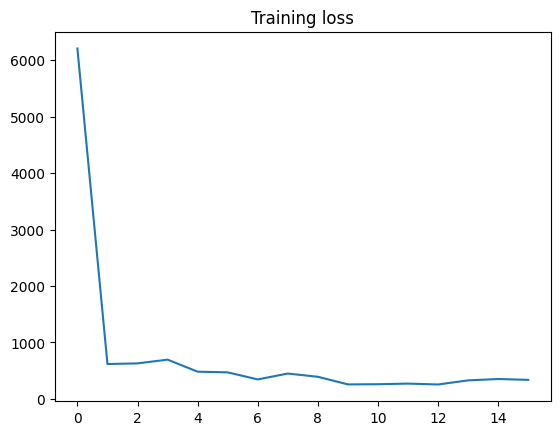

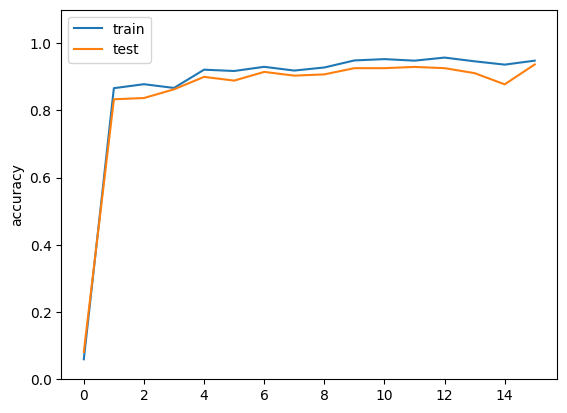

In [44]:
train_and_plot(0.5)

Random init: train loss: 335.68754, train acc: 0.948, test acc: 0.937
Epoch #1, train loss: 202.36227, train acc: 0.965, test acc: 0.956
Epoch #2, train loss: 180.57177, train acc: 0.971, test acc: 0.963
Epoch #3, train loss: 169.56010, train acc: 0.972, test acc: 0.963
Epoch #4, train loss: 160.61811, train acc: 0.974, test acc: 0.967
Epoch #5, train loss: 156.49092, train acc: 0.974, test acc: 0.967
Epoch #6, train loss: 152.73091, train acc: 0.976, test acc: 0.963
Epoch #7, train loss: 148.20135, train acc: 0.976, test acc: 0.963
Epoch #8, train loss: 143.69729, train acc: 0.976, test acc: 0.963
Epoch #9, train loss: 140.65791, train acc: 0.978, test acc: 0.963
Epoch #10, train loss: 134.82556, train acc: 0.978, test acc: 0.963
Epoch #11, train loss: 132.86278, train acc: 0.977, test acc: 0.959
Epoch #12, train loss: 130.96344, train acc: 0.977, test acc: 0.956
Epoch #13, train loss: 130.34134, train acc: 0.977, test acc: 0.959
Epoch #14, train loss: 129.31996, train acc: 0.977, tes

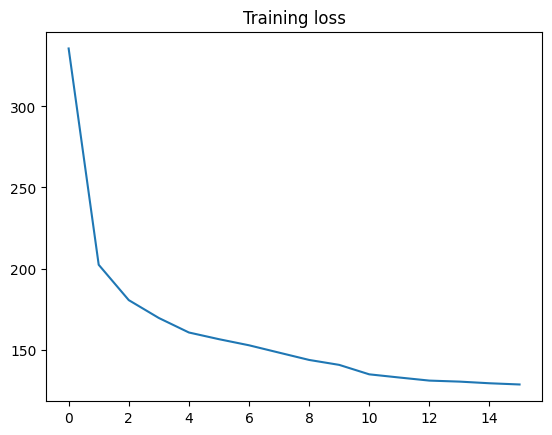

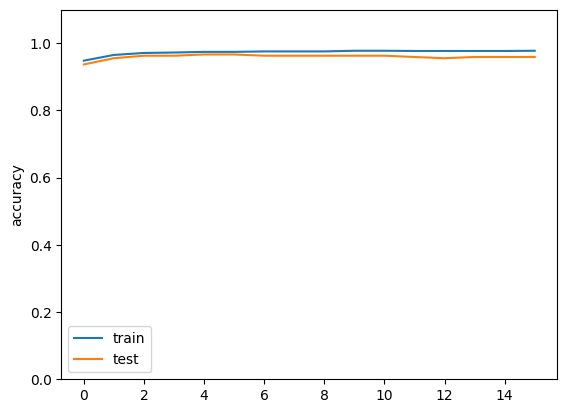

In [45]:
train_and_plot(0.05)

Random init: train loss: 128.57243, train acc: 0.978, test acc: 0.959
Epoch #1, train loss: 129.87151, train acc: 0.976, test acc: 0.956
Epoch #2, train loss: 127.74933, train acc: 0.975, test acc: 0.956
Epoch #3, train loss: 123.83955, train acc: 0.976, test acc: 0.956
Epoch #4, train loss: 115.66183, train acc: 0.978, test acc: 0.952
Epoch #5, train loss: 114.03872, train acc: 0.979, test acc: 0.952
Epoch #6, train loss: 110.27563, train acc: 0.979, test acc: 0.952
Epoch #7, train loss: 110.78676, train acc: 0.980, test acc: 0.952
Epoch #8, train loss: 106.84959, train acc: 0.980, test acc: 0.952
Epoch #9, train loss: 107.59715, train acc: 0.982, test acc: 0.952
Epoch #10, train loss: 103.66649, train acc: 0.982, test acc: 0.956
Epoch #11, train loss: 103.07146, train acc: 0.983, test acc: 0.956
Epoch #12, train loss: 98.38023, train acc: 0.984, test acc: 0.956
Epoch #13, train loss: 98.84863, train acc: 0.984, test acc: 0.956
Epoch #14, train loss: 94.44411, train acc: 0.984, test a

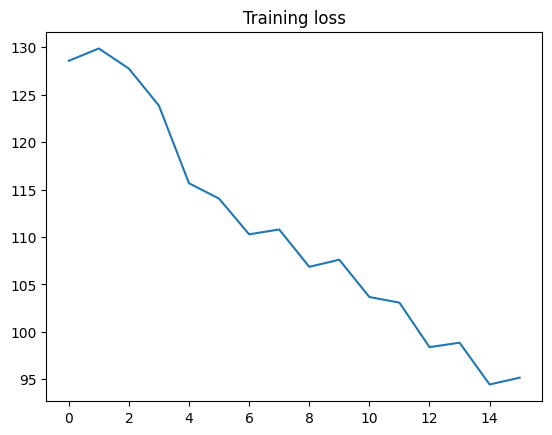

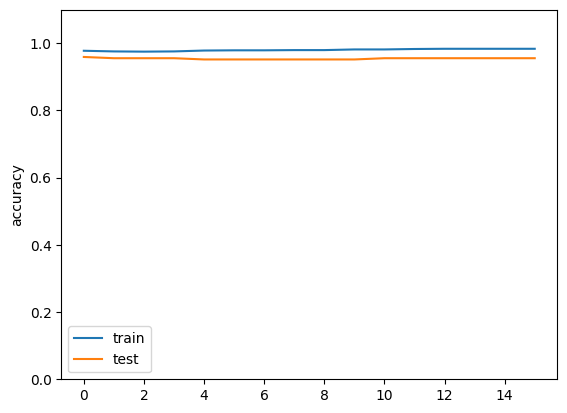

In [46]:
train_and_plot(0.1)

- Hidden layer size

In [55]:
n_hidden = 20
model2 = NeuralNet(n_features, n_hidden, n_classes)

Random init: train loss: 6944.67727, train acc: 0.088, test acc: 0.070
Epoch #1, train loss: 2092.33627, train acc: 0.557, test acc: 0.474
Epoch #2, train loss: 1299.77577, train acc: 0.732, test acc: 0.704
Epoch #3, train loss: 973.92063, train acc: 0.806, test acc: 0.819
Epoch #4, train loss: 783.25894, train acc: 0.859, test acc: 0.848
Epoch #5, train loss: 658.83341, train acc: 0.887, test acc: 0.863
Epoch #6, train loss: 572.32586, train acc: 0.906, test acc: 0.878
Epoch #7, train loss: 506.88607, train acc: 0.917, test acc: 0.900
Epoch #8, train loss: 454.48063, train acc: 0.928, test acc: 0.904
Epoch #9, train loss: 410.56789, train acc: 0.935, test acc: 0.915
Epoch #10, train loss: 375.26767, train acc: 0.942, test acc: 0.915
Epoch #11, train loss: 343.90983, train acc: 0.948, test acc: 0.919
Epoch #12, train loss: 317.66139, train acc: 0.953, test acc: 0.922
Epoch #13, train loss: 295.47764, train acc: 0.956, test acc: 0.926
Epoch #14, train loss: 276.10007, train acc: 0.958, 

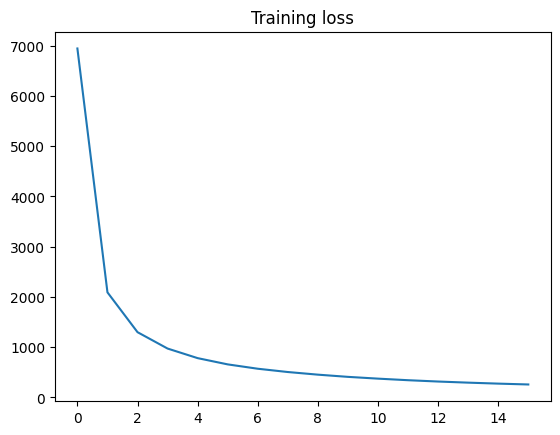

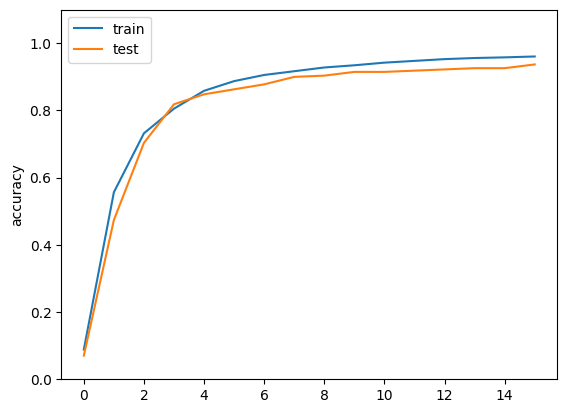

In [56]:
train_and_plot(model2, 0.01)

_ Initialization sheme

In [69]:
np.zeros(3)

array([0., 0., 0.])

In [73]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = np.zeros((input_size, hidden_size))
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.zeros((hidden_size, output_size))
        self.b_o = np.zeros(output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        # TODO
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h

    def forward(self, X):
        y, h, z_h = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        # TODO
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, x, y_true):
        # TODO
        y_pred, h, z_h = self.forward_keep_activations(x)
        output1 =  y_pred - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, output1)
        grad_b_o = output1
        output2 = np.dot(output1, self.W_o.T) * dsigmoid(z_h)
        grad_W_h = np.outer(x, output2)
        grad_b_h = output2
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # TODO
        grads = self.grad_loss(x, y)
        self.W_h -= learning_rate * grads['W_h']
        self.W_o -= learning_rate * grads['W_o']
        self.b_h -= learning_rate * grads['b_h']
        self.b_o -= learning_rate * grads['b_o']


    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [74]:
n_hidden = 20
model2 = NeuralNet(n_features, n_hidden, n_classes)

Random init: train loss: 3516.04744, train acc: 0.099, test acc: 0.100
Epoch #1, train loss: 3542.51801, train acc: 0.102, test acc: 0.089
Epoch #2, train loss: 3526.72588, train acc: 0.102, test acc: 0.089
Epoch #3, train loss: 3370.55061, train acc: 0.191, test acc: 0.156
Epoch #4, train loss: 3074.94312, train acc: 0.251, test acc: 0.211
Epoch #5, train loss: 2879.61832, train acc: 0.259, test acc: 0.211
Epoch #6, train loss: 2771.10463, train acc: 0.269, test acc: 0.215
Epoch #7, train loss: 2702.89383, train acc: 0.280, test acc: 0.226
Epoch #8, train loss: 2652.78325, train acc: 0.298, test acc: 0.230
Epoch #9, train loss: 2611.22332, train acc: 0.316, test acc: 0.259
Epoch #10, train loss: 2574.13002, train acc: 0.324, test acc: 0.278
Epoch #11, train loss: 2539.87193, train acc: 0.337, test acc: 0.296
Epoch #12, train loss: 2507.90329, train acc: 0.345, test acc: 0.289
Epoch #13, train loss: 2478.07081, train acc: 0.358, test acc: 0.300
Epoch #14, train loss: 2450.29918, train 

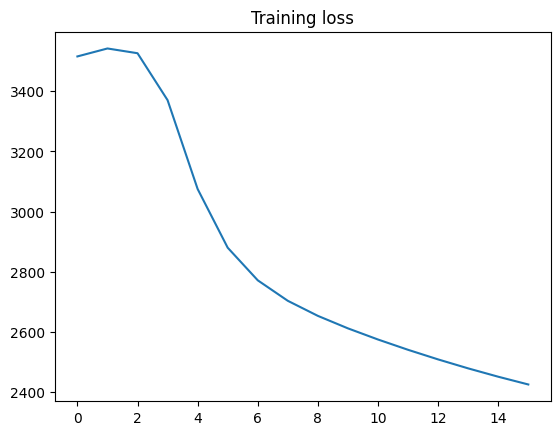

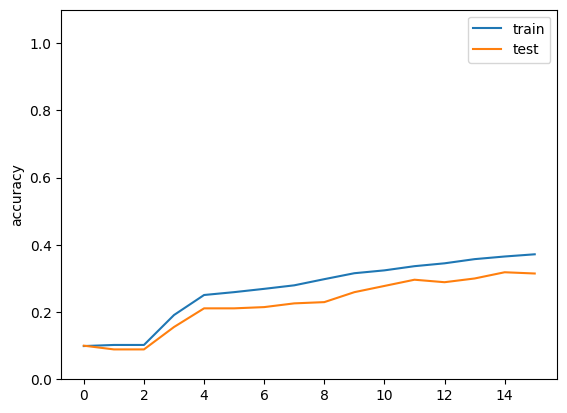

In [75]:
train_and_plot(model2, 0.01)

In [80]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = np.random.uniform(size=(input_size, hidden_size))
        self.b_h = np.random.uniform(size=hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size))
        self.b_o = np.random.uniform(size=output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        # TODO
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h

    def forward(self, X):
        y, h, z_h = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        # TODO
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, x, y_true):
        # TODO
        y_pred, h, z_h = self.forward_keep_activations(x)
        output1 =  y_pred - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, output1)
        grad_b_o = output1
        output2 = np.dot(output1, self.W_o.T) * dsigmoid(z_h)
        grad_W_h = np.outer(x, output2)
        grad_b_h = output2
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # TODO
        grads = self.grad_loss(x, y)
        self.W_h -= learning_rate * grads['W_h']
        self.W_o -= learning_rate * grads['W_o']
        self.b_h -= learning_rate * grads['b_h']
        self.b_o -= learning_rate * grads['b_o']


    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [81]:
n_hidden = 10
model2 = NeuralNet(n_features, n_hidden, n_classes)

Random init: train loss: 3575.05638, train acc: 0.190, test acc: 0.196
Epoch #1, train loss: 3029.71982, train acc: 0.375, test acc: 0.363
Epoch #2, train loss: 2429.66705, train acc: 0.531, test acc: 0.470
Epoch #3, train loss: 1915.06426, train acc: 0.635, test acc: 0.589
Epoch #4, train loss: 1537.74277, train acc: 0.724, test acc: 0.700
Epoch #5, train loss: 1259.91998, train acc: 0.782, test acc: 0.778
Epoch #6, train loss: 1049.94699, train acc: 0.828, test acc: 0.789
Epoch #7, train loss: 882.65325, train acc: 0.866, test acc: 0.837
Epoch #8, train loss: 744.86629, train acc: 0.895, test acc: 0.856
Epoch #9, train loss: 635.65101, train acc: 0.915, test acc: 0.885
Epoch #10, train loss: 552.10967, train acc: 0.925, test acc: 0.900
Epoch #11, train loss: 488.31909, train acc: 0.942, test acc: 0.911
Epoch #12, train loss: 437.58217, train acc: 0.948, test acc: 0.926
Epoch #13, train loss: 396.16100, train acc: 0.954, test acc: 0.930
Epoch #14, train loss: 361.84978, train acc: 0.9

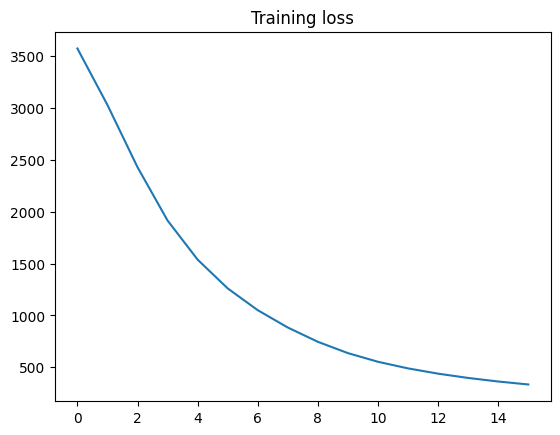

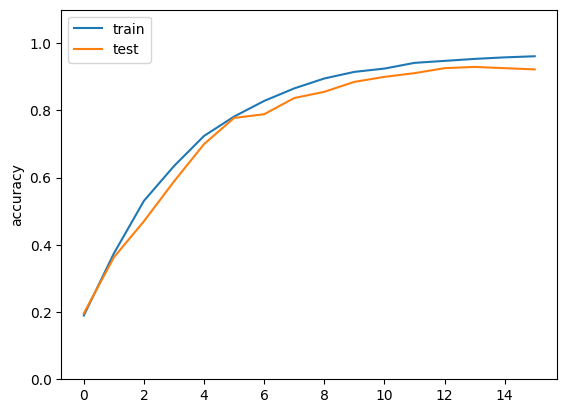

In [82]:
train_and_plot(model2, 0.01)

- Other activations functions

In [33]:

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x) ** 2


def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return np.where(x > 0, 1, 0)


In [83]:
# tanh


class NeuralNet():
    """MLP with 1 hidden layer with a tanh activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.randn(input_size, hidden_size)
        self.b_h = np.random.randn(hidden_size)
        self.W_o = np.random.randn(hidden_size, output_size)
        self.b_o = np.random.randn(output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = tanh(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h

    def forward(self, X):
        y, _, _ = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, x, y_true):
        y_pred, h, z_h = self.forward_keep_activations(x)
        output1 = y_pred - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, output1)
        grad_b_o = output1
        output2 = np.dot(output1, self.W_o.T) * dtanh(z_h)
        grad_W_h = np.outer(x, output2)
        grad_b_h = output2

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h -= learning_rate * grads['W_h']
        self.W_o -= learning_rate * grads['W_o']
        self.b_h -= learning_rate * grads['b_h']
        self.b_o -= learning_rate * grads['b_o']

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [84]:
n_hidden = 10
model2 = NeuralNet(n_features, n_hidden, n_classes)

Random init: train loss: 7373.88840, train acc: 0.142, test acc: 0.178
Epoch #1, train loss: 1868.66916, train acc: 0.600, test acc: 0.530
Epoch #2, train loss: 1268.93145, train acc: 0.713, test acc: 0.685
Epoch #3, train loss: 1029.57092, train acc: 0.768, test acc: 0.711
Epoch #4, train loss: 893.00673, train acc: 0.807, test acc: 0.752
Epoch #5, train loss: 800.76330, train acc: 0.824, test acc: 0.800
Epoch #6, train loss: 720.78783, train acc: 0.844, test acc: 0.826
Epoch #7, train loss: 663.86026, train acc: 0.852, test acc: 0.826
Epoch #8, train loss: 606.76920, train acc: 0.865, test acc: 0.841
Epoch #9, train loss: 555.78008, train acc: 0.886, test acc: 0.859
Epoch #10, train loss: 508.18417, train acc: 0.901, test acc: 0.874
Epoch #11, train loss: 476.66440, train acc: 0.910, test acc: 0.874
Epoch #12, train loss: 441.14740, train acc: 0.917, test acc: 0.893
Epoch #13, train loss: 420.17024, train acc: 0.922, test acc: 0.900
Epoch #14, train loss: 393.48505, train acc: 0.925,

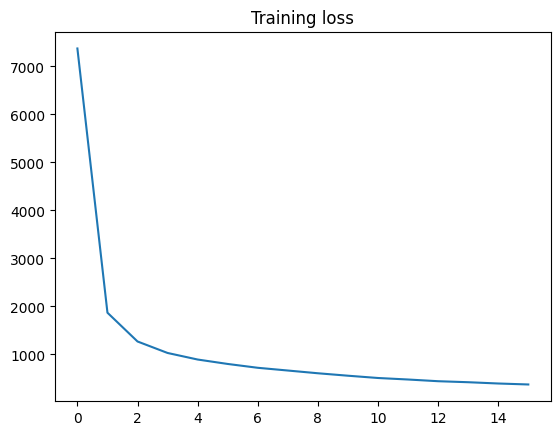

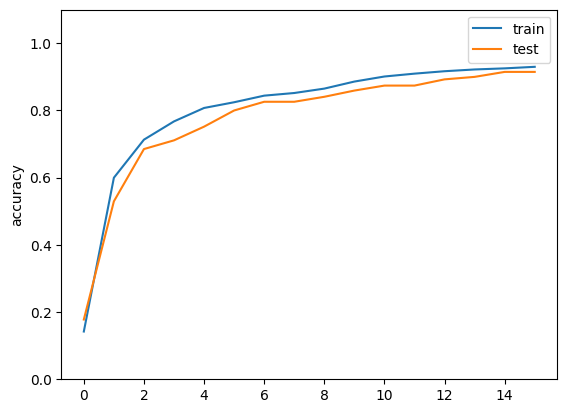

In [85]:
train_and_plot(model2, 0.01)

In [86]:
# Relu

class NeuralNet():
    """MLP with 1 hidden layer with ReLU activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.randn(input_size, hidden_size)
        self.b_h = np.random.randn(hidden_size)
        self.W_o = np.random.randn(hidden_size, output_size)
        self.b_o = np.random.randn(output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = relu(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h

    def forward(self, X):
        y, _, _ = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, x, y_true):
        y_pred, h, z_h = self.forward_keep_activations(x)
        output1 = y_pred - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, output1)
        grad_b_o = output1

        output2 = np.dot(output1, self.W_o.T) * drelu(z_h)
        grad_W_h = np.outer(x, output2)
        grad_b_h = output2

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h -= learning_rate * grads['W_h']
        self.W_o -= learning_rate * grads['W_o']
        self.b_h -= learning_rate * grads['b_h']
        self.b_o -= learning_rate * grads['b_o']

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [87]:
n_hidden = 10
model2 = NeuralNet(n_features, n_hidden, n_classes)

Random init: train loss: 28637.98123, train acc: 0.166, test acc: 0.200
Epoch #1, train loss: 5298.05035, train acc: 0.530, test acc: 0.485
Epoch #2, train loss: 871.05637, train acc: 0.840, test acc: 0.819
Epoch #3, train loss: 671.52066, train acc: 0.877, test acc: 0.867
Epoch #4, train loss: 579.44216, train acc: 0.894, test acc: 0.885
Epoch #5, train loss: 427.61035, train acc: 0.919, test acc: 0.889
Epoch #6, train loss: 350.99453, train acc: 0.932, test acc: 0.893
Epoch #7, train loss: 300.19125, train acc: 0.946, test acc: 0.893
Epoch #8, train loss: 259.38961, train acc: 0.950, test acc: 0.896
Epoch #9, train loss: 217.74619, train acc: 0.956, test acc: 0.904
Epoch #10, train loss: 192.69850, train acc: 0.964, test acc: 0.915
Epoch #11, train loss: 169.33370, train acc: 0.967, test acc: 0.919
Epoch #12, train loss: 148.07223, train acc: 0.970, test acc: 0.919
Epoch #13, train loss: 133.57370, train acc: 0.971, test acc: 0.922
Epoch #14, train loss: 117.62858, train acc: 0.974, 

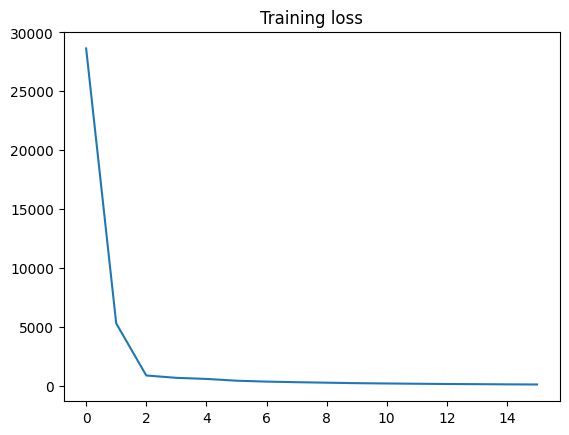

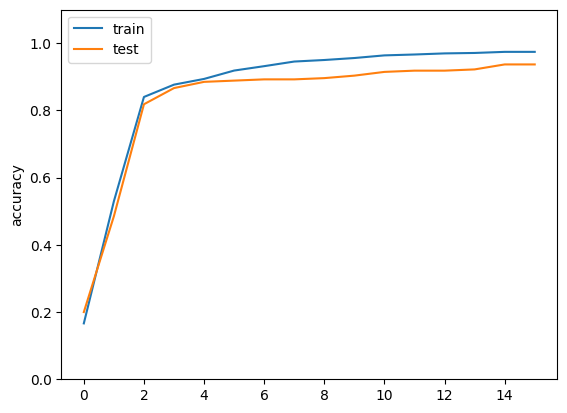

In [88]:
train_and_plot(model2, 0.01)

-

- Second hidden layer

In [91]:
class NeuralNet2():
    """MLP with 2 hidden layers with tanh activation"""

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.W_h1 = np.random.randn(input_size, hidden_size1)
        self.b_h1 = np.random.randn(hidden_size1)
        self.W_h2 = np.random.randn(hidden_size1, hidden_size2)
        self.b_h2 = np.random.randn(hidden_size2)
        self.W_o = np.random.randn(hidden_size2, output_size)
        self.b_o = np.random.randn(output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        z_h1 = np.dot(X, self.W_h1) + self.b_h1
        h1 = tanh(z_h1)
        z_h2 = np.dot(h1, self.W_h2) + self.b_h2
        h2 = tanh(z_h2)
        y = softmax(np.dot(h2, self.W_o) + self.b_o)
        return y, h1, z_h1, h2, z_h2

    def forward(self, X):
        y, _, _, _, _ = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, x, y_true):
        y_pred, h1, z_h1, h2, z_h2 = self.forward_keep_activations(x)
        output1 = y_pred - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h2, output1)
        grad_b_o = output1

        output2 = np.dot(output1, self.W_o.T) * dtanh(z_h2)
        grad_W_h2 = np.outer(h1, output2)
        grad_b_h2 = output2

        output3 = np.dot(output2, self.W_h2.T) * dtanh(z_h1)
        grad_W_h1 = np.outer(x, output3)
        grad_b_h1 = output3

        return {"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_h2": grad_W_h2,
                "b_h2": grad_b_h2, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h1 -= learning_rate * grads['W_h1']
        self.W_h2 -= learning_rate * grads['W_h2']
        self.W_o -= learning_rate * grads['W_o']
        self.b_h1 -= learning_rate * grads['b_h1']
        self.b_h2 -= learning_rate * grads['b_h2']
        self.b_o -= learning_rate * grads['b_o']

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


Random init: train loss: 8888.04369, train acc: 0.098, test acc: 0.059
Epoch #1, train loss: 2131.64663, train acc: 0.558, test acc: 0.522
Epoch #2, train loss: 1573.03835, train acc: 0.678, test acc: 0.659
Epoch #3, train loss: 1293.37034, train acc: 0.745, test acc: 0.737
Epoch #4, train loss: 1046.52395, train acc: 0.798, test acc: 0.756
Epoch #5, train loss: 905.01824, train acc: 0.830, test acc: 0.770
Epoch #6, train loss: 793.57405, train acc: 0.850, test acc: 0.789
Epoch #7, train loss: 700.36240, train acc: 0.880, test acc: 0.807
Epoch #8, train loss: 632.18815, train acc: 0.891, test acc: 0.826
Epoch #9, train loss: 582.10008, train acc: 0.897, test acc: 0.833
Epoch #10, train loss: 541.33576, train acc: 0.898, test acc: 0.844
Epoch #11, train loss: 501.71113, train acc: 0.907, test acc: 0.844
Epoch #12, train loss: 470.47152, train acc: 0.916, test acc: 0.848
Epoch #13, train loss: 446.72009, train acc: 0.922, test acc: 0.852
Epoch #14, train loss: 424.18058, train acc: 0.925

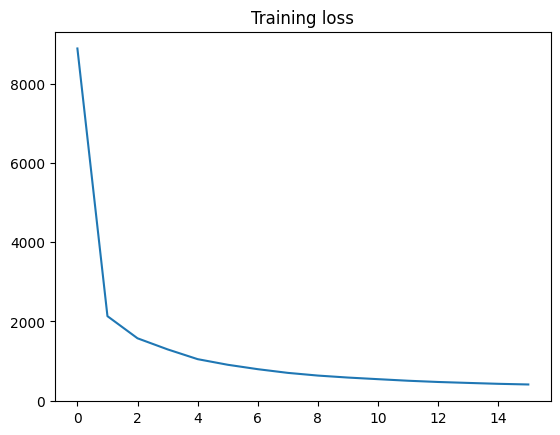

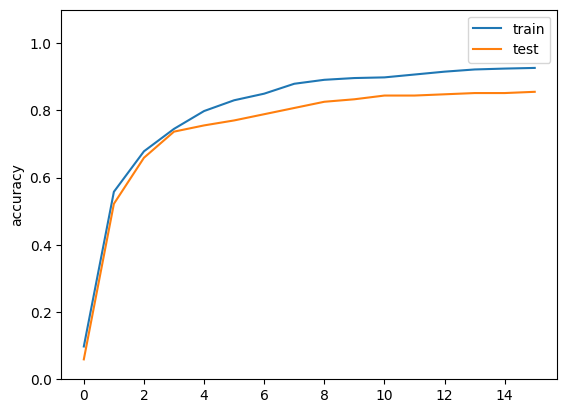

In [94]:
model3 = NeuralNet2(n_features, hidden_size1=10, hidden_size2=10, output_size=n_classes)
train_and_plot(model3, 0.01)

In [95]:
class NeuralNet3():
    """MLP with 2 hidden layers with a tanh activation"""

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.W_h1 = np.random.randn(input_size, hidden_size1)
        self.b_h1 = np.random.randn(hidden_size1)
        self.W_h2 = np.random.randn(hidden_size1, hidden_size2)
        self.b_h2 = np.random.randn(hidden_size2)
        self.W_o = np.random.randn(hidden_size2, output_size)
        self.b_o = np.random.randn(output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        z_h1 = np.dot(X, self.W_h1) + self.b_h1
        h1 = tanh(z_h1)
        z_h2 = np.dot(h1, self.W_h2) + self.b_h2
        h2 = tanh(z_h2)
        y = softmax(np.dot(h2, self.W_o) + self.b_o)
        return y, h1, z_h1, h2, z_h2

    def forward(self, X):
        y, _, _, _, _ = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, x, y_true):
        y_pred, h1, z_h1, h2, z_h2 = self.forward_keep_activations(x)
        output1 = y_pred - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h2, output1)
        grad_b_o = output1

        output2 = np.dot(output1, self.W_o.T) * dtanh(z_h2)
        grad_W_h2 = np.outer(h1, output2)
        grad_b_h2 = output2

        output3 = np.dot(output2, self.W_h2.T) * dtanh(z_h1)
        grad_W_h1 = np.outer(x, output3)
        grad_b_h1 = output3

        return {"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_h2": grad_W_h2,
                "b_h2": grad_b_h2, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h1 -= learning_rate * grads['W_h1']
        self.W_h2 -= learning_rate * grads['W_h2']
        self.W_o -= learning_rate * grads['W_o']
        self.b_h1 -= learning_rate * grads['b_h1']
        self.b_h2 -= learning_rate * grads['b_h2']
        self.b_o -= learning_rate * grads['b_o']

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


Random init: train loss: 8341.11752, train acc: 0.100, test acc: 0.078
Epoch #1, train loss: 1978.56422, train acc: 0.615, test acc: 0.548
Epoch #2, train loss: 1453.91436, train acc: 0.718, test acc: 0.633
Epoch #3, train loss: 1200.83495, train acc: 0.764, test acc: 0.685
Epoch #4, train loss: 1014.97883, train acc: 0.802, test acc: 0.730
Epoch #5, train loss: 884.80168, train acc: 0.828, test acc: 0.763
Epoch #6, train loss: 799.31240, train acc: 0.851, test acc: 0.778
Epoch #7, train loss: 726.89624, train acc: 0.860, test acc: 0.767
Epoch #8, train loss: 664.88958, train acc: 0.872, test acc: 0.793
Epoch #9, train loss: 613.88310, train acc: 0.880, test acc: 0.781
Epoch #10, train loss: 575.14417, train acc: 0.891, test acc: 0.789
Epoch #11, train loss: 541.32472, train acc: 0.898, test acc: 0.800
Epoch #12, train loss: 510.36889, train acc: 0.902, test acc: 0.793
Epoch #13, train loss: 485.71406, train acc: 0.902, test acc: 0.804
Epoch #14, train loss: 458.13489, train acc: 0.910

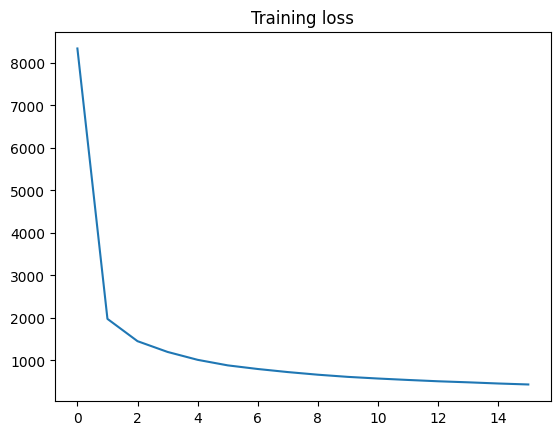

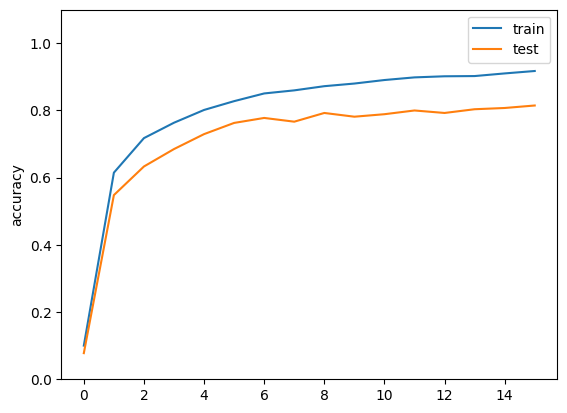

In [96]:
model3 = NeuralNet3(n_features, hidden_size1=10, hidden_size2=10, output_size=n_classes)
train_and_plot(model3, 0.01)

- Mini batches

In [49]:
class NeuralNet4():
    """MLP with 2 hidden layers with tanh activation"""

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.W_h1 = np.random.randn(input_size, hidden_size1)
        self.b_h1 = np.random.randn(hidden_size1)
        self.W_h2 = np.random.randn(hidden_size1, hidden_size2)
        self.b_h2 = np.random.randn(hidden_size2)
        self.W_o = np.random.randn(hidden_size2, output_size)
        self.b_o = np.random.randn(output_size)
        self.output_size = output_size

    def forward_keep_activations(self, X):
        z_h1 = np.dot(X, self.W_h1) + self.b_h1
        h1 = tanh(z_h1)
        z_h2 = np.dot(h1, self.W_h2) + self.b_h2
        h2 = tanh(z_h2)
        y = softmax(np.dot(h2, self.W_o) + self.b_o)
        return y, h1, z_h1, h2, z_h2

    def forward(self, X):
        y, _, _, _, _ = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, X_batch, y_true_batch):
        batch_size = X_batch.shape[0]
        grads = {
            "W_h1": np.zeros_like(self.W_h1),
            "b_h1": np.zeros_like(self.b_h1),
            "W_h2": np.zeros_like(self.W_h2),
            "b_h2": np.zeros_like(self.b_h2),
            "W_o": np.zeros_like(self.W_o),
            "b_o": np.zeros_like(self.b_o),
        }

        for x, y_true in zip(X_batch, y_true_batch):
            y_pred, h1, z_h1, h2, z_h2 = self.forward_keep_activations(x)
            output1 = y_pred - one_hot(self.output_size, y_true)

            grads['W_o'] += np.outer(h2, output1)
            grads['b_o'] += output1

            output2 = np.dot(output1, self.W_o.T) * dtanh(z_h2)
            grads['W_h2'] += np.outer(h1, output2)
            grads['b_h2'] += output2

            output3 = np.dot(output2, self.W_h2.T) * dtanh(z_h1)
            grads['W_h1'] += np.outer(x, output3)
            grads['b_h1'] += output3

        for key in grads:
            grads[key] /= batch_size

        return grads

    def train(self, X, y, batch_size, learning_rate, epochs):

        num_samples = X.shape[0]
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]

            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            grads = self.grad_loss(X_batch, y_batch)
            self.W_h1 -= learning_rate * grads['W_h1']
            self.W_h2 -= learning_rate * grads['W_h2']
            self.W_o -= learning_rate * grads['W_o']
            self.b_h1 -= learning_rate * grads['b_h1']
            self.b_h2 -= learning_rate * grads['b_h2']
            self.b_o -= learning_rate * grads['b_o']


    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [53]:
def train_and_plot(model, batch_size, learning_rate, epochs):

  losses, accuracies, accuracies_test = [], [], []
  losses.append(model.loss(X_train, y_train))
  accuracies.append(model.accuracy(X_train, y_train))
  accuracies_test.append(model.accuracy(X_test, y_test))

  print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
        % (losses[-1], accuracies[-1], accuracies_test[-1]))

  for epoch in range(epochs):
      # for i, (x, y) in enumerate(zip(X_train, y_train)):
      model.train(X_train, y_train, batch_size, learning_rate, epochs)
      # model.train(x, y, learning_rate)

      losses.append(model.loss(X_train, y_train))
      accuracies.append(model.accuracy(X_train, y_train))
      accuracies_test.append(model.accuracy(X_test, y_test))
      print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
            % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
  plt.plot(losses)
  plt.title("Training loss");
  plt.show()
  plt.plot(accuracies, label='train')
  plt.plot(accuracies_test, label='test')
  plt.ylim(0, 1.1)
  plt.ylabel("accuracy")
  plt.legend(loc='best');

Random init: train loss: 9.69726, train acc: 0.071, test acc: 0.081
Epoch #1, train loss: 9.21247, train acc: 0.089, test acc: 0.104
Epoch #2, train loss: 8.80368, train acc: 0.109, test acc: 0.119
Epoch #3, train loss: 8.47491, train acc: 0.136, test acc: 0.126
Epoch #4, train loss: 8.21331, train acc: 0.158, test acc: 0.141
Epoch #5, train loss: 7.99977, train acc: 0.172, test acc: 0.152
Epoch #6, train loss: 7.82585, train acc: 0.195, test acc: 0.193
Epoch #7, train loss: 7.68676, train acc: 0.222, test acc: 0.219
Epoch #8, train loss: 7.57102, train acc: 0.275, test acc: 0.233
Epoch #9, train loss: 7.47126, train acc: 0.303, test acc: 0.274
Epoch #10, train loss: 7.38197, train acc: 0.325, test acc: 0.304
Epoch #11, train loss: 7.30340, train acc: 0.359, test acc: 0.322
Epoch #12, train loss: 7.23576, train acc: 0.374, test acc: 0.341
Epoch #13, train loss: 7.17743, train acc: 0.398, test acc: 0.378
Epoch #14, train loss: 7.12537, train acc: 0.420, test acc: 0.396
Epoch #15, train 

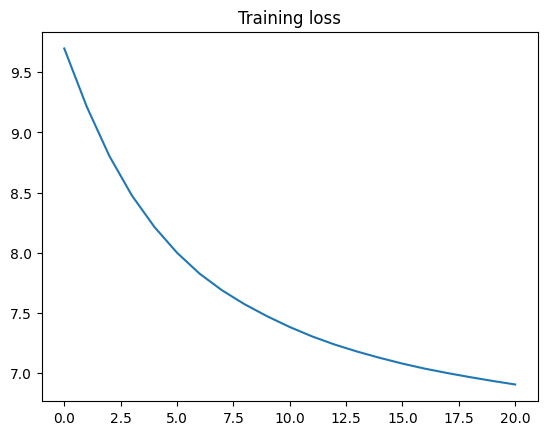

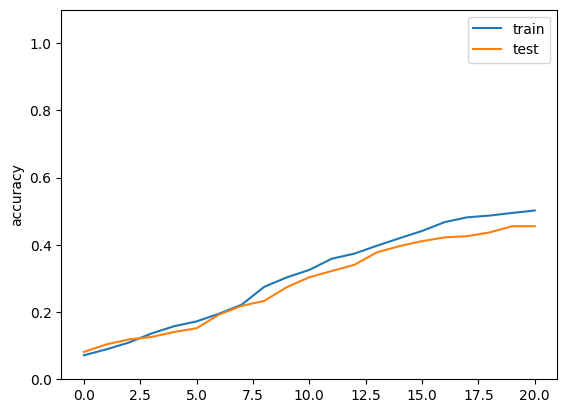

In [54]:
model4 = NeuralNet4(n_features, hidden_size1=10, hidden_size2=10, output_size=n_classes)
train_and_plot(model4,  batch_size=32, learning_rate=0.01, epochs=20)

- Momentum

In [56]:
class NeuralNet5():
    """MLP with 2 hidden layers with tanh activation"""

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.W_h1 = np.random.randn(input_size, hidden_size1)
        self.b_h1 = np.random.randn(hidden_size1)
        self.W_h2 = np.random.randn(hidden_size1, hidden_size2)
        self.b_h2 = np.random.randn(hidden_size2)
        self.W_o = np.random.randn(hidden_size2, output_size)
        self.b_o = np.random.randn(output_size)
        self.output_size = output_size

        # Initialize velocity terms for momentum
        self.v_W_h1 = np.zeros_like(self.W_h1)
        self.v_b_h1 = np.zeros_like(self.b_h1)
        self.v_W_h2 = np.zeros_like(self.W_h2)
        self.v_b_h2 = np.zeros_like(self.b_h2)
        self.v_W_o = np.zeros_like(self.W_o)
        self.v_b_o = np.zeros_like(self.b_o)

    def forward_keep_activations(self, X):
        z_h1 = np.dot(X, self.W_h1) + self.b_h1
        h1 = tanh(z_h1)
        z_h2 = np.dot(h1, self.W_h2) + self.b_h2
        h2 = tanh(z_h2)
        y = softmax(np.dot(h2, self.W_o) + self.b_o)
        return y, h1, z_h1, h2, z_h2

    def forward(self, X):
        y, _, _, _, _ = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        output = nll(one_hot(self.output_size, y), self.forward(X))
        return output

    def grad_loss(self, X_batch, y_true_batch):
        batch_size = X_batch.shape[0]
        grads = {
            "W_h1": np.zeros_like(self.W_h1),
            "b_h1": np.zeros_like(self.b_h1),
            "W_h2": np.zeros_like(self.W_h2),
            "b_h2": np.zeros_like(self.b_h2),
            "W_o": np.zeros_like(self.W_o),
            "b_o": np.zeros_like(self.b_o),
        }

        for x, y_true in zip(X_batch, y_true_batch):
            y_pred, h1, z_h1, h2, z_h2 = self.forward_keep_activations(x)
            output1 = y_pred - one_hot(self.output_size, y_true)

            grads['W_o'] += np.outer(h2, output1)
            grads['b_o'] += output1

            output2 = np.dot(output1, self.W_o.T) * dtanh(z_h2)
            grads['W_h2'] += np.outer(h1, output2)
            grads['b_h2'] += output2

            output3 = np.dot(output2, self.W_h2.T) * dtanh(z_h1)
            grads['W_h1'] += np.outer(x, output3)
            grads['b_h1'] += output3

        # Average gradients over the batch
        for key in grads:
            grads[key] /= batch_size

        return grads

    def train(self, X, y, batch_size, learning_rate, epochs, momentum=0.9):
        num_samples = X.shape[0]

        # for epoch in range(epochs):
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]

            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            grads = self.grad_loss(X_batch, y_batch)

            # Update velocities with momentum
            self.v_W_h1 = momentum * self.v_W_h1 - learning_rate * grads['W_h1']
            self.v_b_h1 = momentum * self.v_b_h1 - learning_rate * grads['b_h1']
            self.v_W_h2 = momentum * self.v_W_h2 - learning_rate * grads['W_h2']
            self.v_b_h2 = momentum * self.v_b_h2 - learning_rate * grads['b_h2']
            self.v_W_o = momentum * self.v_W_o - learning_rate * grads['W_o']
            self.v_b_o = momentum * self.v_b_o - learning_rate * grads['b_o']

            # Update weights and biases
            self.W_h1 += self.v_W_h1
            self.b_h1 += self.v_b_h1
            self.W_h2 += self.v_W_h2
            self.b_h2 += self.v_b_h2
            self.W_o += self.v_W_o
            self.b_o += self.v_b_o

            # # Optionally print the loss at each epoch
            # epoch_loss = self.loss(X, y)
            # print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


Random init: train loss: 9.62719, train acc: 0.094, test acc: 0.074
Epoch #1, train loss: 7.73128, train acc: 0.281, test acc: 0.267
Epoch #2, train loss: 7.06092, train acc: 0.394, test acc: 0.422
Epoch #3, train loss: 6.82330, train acc: 0.484, test acc: 0.530
Epoch #4, train loss: 6.67811, train acc: 0.551, test acc: 0.559
Epoch #5, train loss: 6.57316, train acc: 0.589, test acc: 0.593
Epoch #6, train loss: 6.48893, train acc: 0.629, test acc: 0.659
Epoch #7, train loss: 6.41887, train acc: 0.646, test acc: 0.689
Epoch #8, train loss: 6.36827, train acc: 0.663, test acc: 0.700
Epoch #9, train loss: 6.31689, train acc: 0.691, test acc: 0.704
Epoch #10, train loss: 6.26665, train acc: 0.704, test acc: 0.711
Epoch #11, train loss: 6.22436, train acc: 0.714, test acc: 0.722
Epoch #12, train loss: 6.19042, train acc: 0.731, test acc: 0.722
Epoch #13, train loss: 6.15354, train acc: 0.743, test acc: 0.733
Epoch #14, train loss: 6.12492, train acc: 0.752, test acc: 0.733
Epoch #15, train 

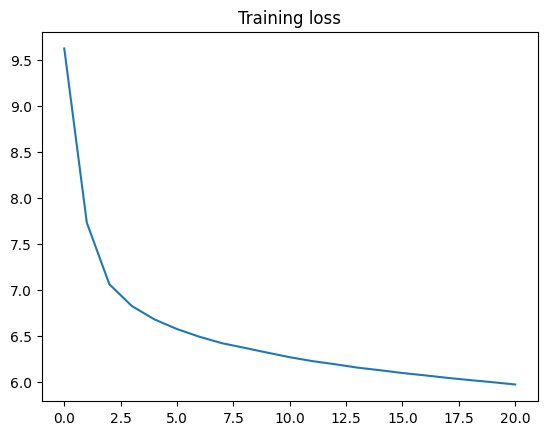

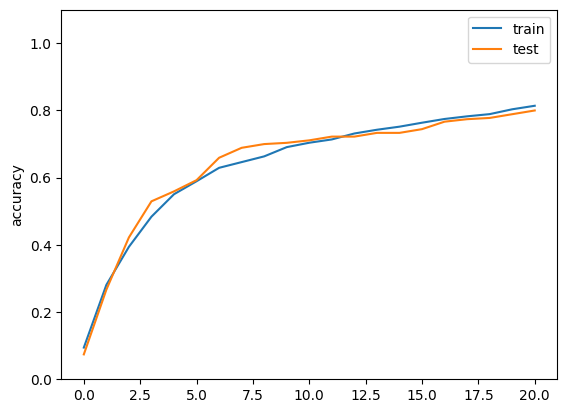

In [57]:
model5 = NeuralNet5(n_features, hidden_size1=10, hidden_size2=10, output_size=n_classes)
train_and_plot(model5,  batch_size=32, learning_rate=0.01, epochs=20)

- Keras

In [58]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


In [59]:
model = Sequential([
    Dense(10, input_dim=n_features, activation='tanh'),
    Dense(10, activation='tanh'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes=n_classes)

model.fit(X_train, y_train_one_hot, batch_size=32, epochs=20)

y_test_one_hot = to_categorical(y_test, num_classes=n_classes)
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2660 - loss: 2.1038
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6982 - loss: 1.2816
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.8689
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9034 - loss: 0.6050
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9300 - loss: 0.4692
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9512 - loss: 0.3509
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.2851
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9683 - loss: 0.2374
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.2007
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9786 - loss: 0.1800
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.1517
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.1412
